# **CUHK-STAT3009** Notebook

This is a combined Jupyter notebook of CUHK-STAT3009 used as a blackboard for Python programming. The notebook for each section can be find in [statmlben/CUHK-STAT3009](https://github.com/statmlben/CUHK-STAT3009). More information about this course can be found [here](https://www.bendai.org/STAT3009/).

# Software preparation


- [ ] Explore **Colab** and **Kaggle**, and use **markdown**

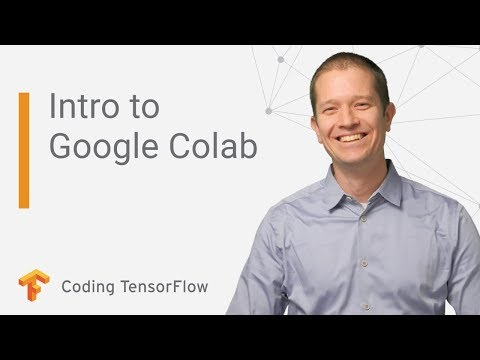

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('inN8seMm7UI')

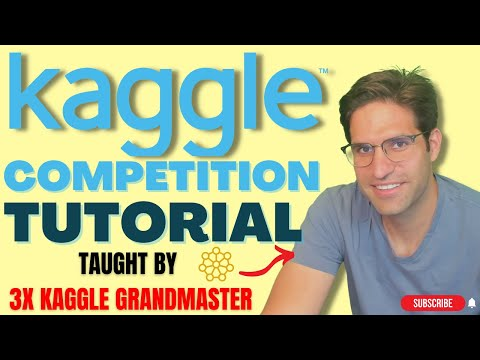

In [ ]:
YouTubeVideo('4BOtr1PZ2D8')

- [ ] Markdown
  - We will documentate the Python code by using `markdown`
  - [Markdown Cheat Sheet](https://www.markdownguide.org/cheat-sheet/)
  - Make sure a general audit could understand your notebook
  - [x] Create a to-do item
  - [x] done

- [ ] Install `numpy`, `pandas`, `seaborn` in your colab

In [ ]:
!pip install numpy pandas seaborn scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- [ ] Initialize a Jupyter notebook, load `numpy`, print the numpy version in your notebook

In [ ]:
import numpy as np
print(np.__version__)

import pandas as pd
print(pd.__version__)

1.21.6
1.3.5


- [ ] Participate one competition in **Kaggle**, and try to make a submission
  - The first competition for most kaggler is: [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic)
  - Join the competion and make your first submission.
  - Try to provide the prediction by your own Python code. You can also check this [top-voted notebook](https://www.kaggle.com/code/startupsci/titanic-data-science-solutions) as well.

# Overview of Recommender Systems

## Examples (RS) in Kaggle

- [Elo Merchant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation/data?select=Data+Dictionary.xlsx): `merchant_id` and `card_id`.

- [WSDM - KKBox's Music Recommendation Challenge](https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data): `user` and `music`.

- [Event Recommendation Engine Challenge](https://www.kaggle.com/c/event-recommendation-engine-challenge/overview/evaluation): `user` and `event`.


## Load Netflix dataset

- Dowload [Netflix Prize Data](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data). (For illustration, we only take the first subset.)

- Dataset is pre-processed by [`pre-process.py`](https://github.com/statmlben/CUHK-STAT3009/tree/main/dataset)

- Load data into Python

- Re-orginize the data structure as a standard form

- For testing set, we remove the real ratings.



In [ ]:
import numpy as np
import pandas as pd

## Upload Netflix dataset in CUHK-STAT3009 Github repo

train_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/train.csv"
test_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/test.csv"

dtrain = pd.read_csv(train_url)
dtest = pd.read_csv(test_url)

In [ ]:
dtrain.sample(5).T

,3569,56,4720,1286,12835
movie_id,1872,3543,2753,2216,2946
user_id,766,104,1643,663,1558
rating,4,5,3,5,3
date,2005-03-14,2005-12-30,2003-06-03,2005-09-16,2004-01-29


In [ ]:
dtest.sample(5).T

,13157,30022,40949,18877,8341
movie_id,2151,458,602,1860,730
user_id,671,1867,1009,663,641
rating,4,5,5,3,5
date,2005-08-17,2004-01-28,2005-11-02,2005-01-27,2004-11-27


### Pre-process the data as a `np.array`

In [ ]:
## save (user_id, item_id) and rating separately
train_rating = dtrain['rating'].values
train_rating = np.array(train_rating, dtype=float)
train_pair = dtrain[['user_id', 'movie_id']].values

test_rating = dtest['rating'].values
test_rating = np.array(test_rating, dtype=float)
test_pair = dtest[['user_id', 'movie_id']].values

## we want to predict `test_rating` based on `train_pair`, `train_rating`, `test_pair`

In [ ]:
test_pair[:,1]

array([2956,  791, 1547, ...,  653, 2195, 3081])

In [ ]:
## find the number of users/items
n_user = max( max(train_pair[:,0]), max(test_pair[:,0]) ) + 1
print('total number of users: %d' %n_user)

n_item = max( max(train_pair[:,1]), max(test_pair[:,1]) ) + 1
print('total number of items: %d' %n_item)

total number of users: 2000
total number of items: 3568


## Evaluation

- Define a function to compute `rmse` for the predicted rating

- Test your function

In [ ]:
## define RMSE function
def rmse(true_rating, pred_rating):
  return np.sqrt(np.mean((true_rating - pred_rating)**2))

In [ ]:
## Test `rmse` function

pred = np.zeros(len(test_rating))
print('rmse for zero rating: %.3f' %rmse(test_rating, pred))
print('rmse for true rating: %.3f' %rmse(test_rating, test_rating))

rmse for zero rating: 3.787
rmse for true rating: 0.000


## Implement Baseline methods

- Inpout: training set.

- Output: return predicted ratings for (user id, item id) user-item pairs in testing set.

- Goal: make prediction for testing set

### Global mean

$$
\bar{r} = \frac{1}{|\Omega|} \sum_{(u,i) \in \Omega} r_{ui}, \quad \hat{r}_{ui} = \bar{r}
$$

In [ ]:
## create a potential prediction for `test_rating`
pred = np.zeros(len(test_rating))

## Compute global mean based on `train_rating`
global_pred = pred.copy()
global_mean = train_rating.mean()
global_pred = global_mean*np.ones(len(pred))

print(global_pred[:10])
print('rmse for global mean: %.3f' %rmse(test_rating, global_pred))

[3.62115674 3.62115674 3.62115674 3.62115674 3.62115674 3.62115674
 3.62115674 3.62115674 3.62115674 3.62115674]
rmse for global mean: 1.085


### user average

$$
		\bar{r}_{u} = \frac{1}{|\mathcal{I}_u|} \sum_{i \in \mathcal{I}_u} r_{ui}, \text{ for } u=1, \cdots, n; \quad \hat{r}_{ui} = \bar{r}_u
$$

- Loop for all users
  - Find all records for this user in both training and testing sets.
  - Compute the average ratings for this user in the training set.
  - Predict the ratings for this users in the testing set.

In [ ]:
## (InClass Practice) user average
UA_pred = np.zeros_like(test_rating, dtype=float)
for u in range(n_user):
    # find the index for both train and test for user_id = u
    ind_test = np.where(test_pair[:,0] == u)[0]
    ind_train = np.where(train_pair[:,0] == u)[0]
    ## if there is no record; predict as the global mean
    if len(ind_test) == 0:
        continue
    ## (Practice) if the records for the users is too small, then predict as global mean
    if len(ind_train) < 3:
        UA_pred[ind_test] = global_mean
    else:
        # predict as user average
        UA_pred[ind_test] = train_rating[ind_train].mean()
print(UA_pred[:10])

print('rmse for user mean: %.3f' %rmse(test_rating, UA_pred))

[3.73684211 3.35714286 3.66037736 2.84931507 3.70909091 3.27419355
 3.16666667 3.57142857 4.1        3.375     ]
rmse for user mean: 1.013


### item average

$$
		\bar{r}_{i} = \frac{1}{|\mathcal{U}_i|} \sum_{u \in \mathcal{U}_i} r_{ui}, \text{ for } i=1, \cdots, m; \quad \hat{r}_{ui} = \bar{r}_i,
$$

In [ ]:
## (InClass Practice) item average

IA_pred = np.zeros_like(test_rating, dtype=float)
for i in range(n_item):
    # find the index for both train and test for item_id = i
    ind_test = np.where(test_pair[:,1] == i)[0]
    ind_train = np.where(train_pair[:,1] == i)[0]
    if len(ind_test) == 0:
        continue
    if len(ind_train) < 3:
        IA_pred[ind_test] = global_mean
    else:
        # predict as item average
        IA_pred[ind_test] = train_rating[ind_train].mean()

print('rmse for item mean: %.3f' %rmse(test_rating, IA_pred))

rmse for item mean: 1.039


## Package Python functions


- *Input*: 'train_rating', 'test_pair'

- *Return*: Predicted ratings.

In [ ]:
def glb_mean(train_rating, test_pair):
    pred = train_rating.mean() * np.ones(len(test_pair))
    return pred

In [ ]:
def user_mean(train_pair, train_rating, test_pair):
    n_user = max(train_pair[:,0].max(), test_pair[:,0].max())+1
    pred = np.zeros(len(test_pair))
    glb_mean_value = train_rating.mean()
    for u in range(n_user):
        # find the index for both train and test for user_id = u
        ind_test = np.where(test_pair[:,0] == u)[0]
        ind_train = np.where(train_pair[:,0] == u)[0]
        if len(ind_test) == 0:
            continue
        if len(ind_train) < 3:
            pred[ind_test] = glb_mean_value
        else:
            # predict as user average
            pred[ind_test] = train_rating[ind_train].mean()
    return pred

In [ ]:
def item_mean(train_pair, train_rating, test_pair):
    n_item = max(train_pair[:,1].max(), test_pair[:,1].max())+1
    pred = np.zeros(len(test_pair))
    glb_mean_value = train_rating.mean()
    for i in range(n_item):
        # find the index for both train and test for item_id = i
        ind_test = np.where(test_pair[:,1] == i)[0]
        ind_train = np.where(train_pair[:,1] == i)[0]
        if len(ind_test) == 0:
            continue
        if len(ind_train) < 3:
            pred[ind_test] = glb_mean_value
        else:
            # predict as user average
            pred[ind_test] = train_rating[ind_train].mean()
    return pred

## Sequential models; user-item mean

- We can predict the rating by the `user_mean`, then fit the residual by `item_mean`

$$\hat{r}_{ui} = \mu_u + \mu_i$$

where
		$$\mu_u = \frac{1}{|\mathcal{I}_u|} \sum_{i \in \mathcal{I}_u} r_{ui}, \quad \mu_i = \frac{1}{|\mathcal{U}_i|} \sum_{u \in \mathcal{U}_i} (r_{ui} - \mu_u)$$

In [ ]:
## compute user-mean
pred_rating = user_mean(train_pair, train_rating, test_pair)

print('rmse for user mean: %.3f' %rmse(test_rating, pred_rating))

rmse for user mean: 1.013


In [ ]:
## compute the residual rating, and fit item_mean based on residual
# get res in the training set
train_res = train_rating - user_mean(train_pair, train_rating, train_pair)
# fit the res by item_mean
pred_rating = pred_rating + item_mean(train_pair, train_res, test_pair)

# final prediction add prediction of residual to the final prediction
print('rmse for user mean: %.3f' %rmse(test_rating, pred_rating))

rmse for user mean: 0.964


## To-do list

- **STAT**
  - [ ] Background of RS  
  - [ ] The data types in RS
  - [ ] Evaluation metrics
  - [ ] Statistical models for baseline methods

- **Code**

  - [ ] Load data to Python `pd.read_csv`
  - [ ] implementation of baseline methods
  - [ ] define Python functions

# Correlation-based Recommender Systems


In [ ]:
# Load and pro-processed dataset
import numpy as np
import pandas as pd

np.random.seed(0)
## Upload Netflix dataset in CUHK-STAT3009 Github repo

train_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/train.csv"
test_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/test.csv"

dtrain = pd.read_csv(train_url)
dtest = pd.read_csv(test_url)

train_rating = dtrain['rating'].values
train_rating = np.array(train_rating, dtype=float)
train_pair = dtrain[['user_id', 'movie_id']].values

test_rating = dtest['rating'].values
test_rating = np.array(test_rating, dtype=float)
test_pair = dtest[['user_id', 'movie_id']].values

n_user = max( max(train_pair[:,0]), max(test_pair[:,0]) ) + 1
n_item = max( max(train_pair[:,1]), max(test_pair[:,1]) ) + 1

## Implement Correlation-based (user-based) recommender systems

- Method 1: store distance matrix

  - Steps
    - develop `user_co_rating` function
    - define `user_d` function
    - define `user_d_mat`
    - make prediction based on Algo1

- Method 2: without store distance matrix

  - Steps
    - Loop over $u$ then loop over $i \in \mathcal{I}_u$
    - Compute distance for user u in the loop over u
    - find a valid neighbor in the loop *over* $i$


- Note
  - time-space trade-off: [how to profiling and timing Code](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html)?

### `user_co_rating`: find co-rating items for two users

- Structure:

  - **Input**: pair of users $(u,v)$; training set
  - **Output**: co-rating items and their ratings

- Steps:

  - Find all indices for $u$ and $v$
  - Find co-rated items
  - Find indices for co-rated items for $u$ and $v$ separately

- Tips:

  - save indices for all users/items

In [ ]:
# save indices for all users/items
index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]

In [ ]:
# test index sets
train_pair[index_user[0]].T

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [2720, 1935, 3126, 3386, 1118, 1686,  151, 1456, 2893,  571,  712,
         586, 3148, 2306, 3295,  395, 2198, 1546, 1164, 3256,  426,  977,
        2885, 1019, 3487, 1292, 3383, 1577, 2790, 2337, 2345,  945, 1428,
        1306, 2977, 2531, 1133, 1778, 1473, 3276, 2157, 1501,  993, 3516,
        2716, 2497,  453,  916, 2554, 3114, 1790, 1931, 2505, 2922, 1734,
        1395, 3007, 1504,  133, 3058, 1423,  183,  634, 1333,  132,  467,
         285, 1555, 224

In [ ]:
def user_co_rating(index_u,index_v,train_pair,train_rating):
    """
    Find co-rated items of two users.

    Input
    -----
    index_u: index set of rated records for user u
    index_v: index set of rated records for user v
    train_pair: user-item pairs in training set
    train_rating: ratings for `train_pair`

    Output
    ------
    indices for co-rated items by users u and v
    """
    ## Step 1: find co-rated item

    # find items for u and v
    item_u, item_v = train_pair[index_u,1], train_pair[index_v,1]
    # find co-rating items by `set`
    item_co = list( set(item_u).intersection(set(item_v)) )
    if len(item_co) == 0:
        return [], []
    else:
        ## Step 2: indices for co-rated items for both users
        # find the co-rating vectors by using `np.isin`
        ind_co_u = np.where(np.isin(item_u, item_co))[0]
        ind_co_v = np.where(np.isin(item_v, item_co))[0]

        # Make sure the indices for both users are corresponding to the same items
        ind_co_u = ind_co_u[np.argsort(item_u[ind_co_u])]
        ind_co_v = ind_co_v[np.argsort(item_v[ind_co_v])]

        return index_u[ind_co_u], index_v[ind_co_v]

In [ ]:
## test function
ind_co_u, ind_co_v = user_co_rating(index_user[0],index_user[1],train_pair,train_rating)
train_pair[ind_co_u].T

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [ 133,  229,  571,  712,  916, 1118, 1133, 1306, 1448, 1456, 1501,
        1504, 1778, 2198, 2497, 2505, 2893, 2922, 2977, 3058, 3114, 3386,
        3543]])

In [ ]:
train_pair[ind_co_v].T

array([[   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1],
       [ 133,  229,  571,  712,  916, 1118, 1133, 1306, 1448, 1456, 1501,
        1504, 1778, 2198, 2497, 2505, 2893, 2922, 2977, 3058, 3114, 3386,
        3543]])

### Define `user_d` function

- Structure:
  - Input: pair of ind of users (𝑢,𝑣); training set
  - Output: co-rating items and their ratings

- Steps:
  - Find indices for co-rated items for 𝑢 and 𝑣 by `user_co_rating`
  - Compute distance



In [ ]:
from scipy.spatial import distance as ds

def user_d(index_u,index_v,train_pair,train_rating,distance='euclidean'):
    """
    Compute distance btw two users.

    Input
    -----
    index_u: index set of rated records for user u
    index_v: index set of rated records for user v
    train_pair: user-item pairs in training set
    train_rating: ratings for `train_pair`
    distance: kind of distance btw two users

    Output
    ------
    distance btw users u and v
    """

    ind_co_u, ind_co_v = user_co_rating(index_u,index_v,train_pair,train_rating)
    if (len(ind_co_u)==0) or (len(ind_co_v)==0):
      return 0.
    ## get the rating vectors for users (u,v) with shared items
    rating_co_u, rating_co_v = train_rating[ind_co_u], train_rating[ind_co_v]
    if distance == 'euclidean':
      distance_tmp = np.sqrt(np.sum((rating_co_u - rating_co_v)**2))
    elif distance == 'cosine':
      distance_tmp = ds.cosine(rating_co_u, rating_co_v)
    elif distance == 'correlation':
      distance_tmp = ds.correlation(rating_co_u, rating_co_v)
    else:
      raise Exception("Sorry, distance must be euclidean, cosine, or correlation")
    ## make a distance to exactly zero
    return distance_tmp + 1e-4

In [ ]:
## test function
user_d(index_user[0],index_user[1],train_pair,train_rating,distance='correlation')

0.5674789876514349

In [ ]:
## test (u,v) = (0,4); None co-rated items
print(user_co_rating(index_user[0],index_user[4],train_pair,train_rating))
print(user_d(index_user[0],index_user[4],train_pair,train_rating))

(None, None)
0.0


### Define `user_d_mat` function

- Structure:
  - Input: training set
  - Output: distance matrix for all users

- Steps:
  - call `user_d` in a pairwise look

- Note:
  - save the distance matrix by `scipy.sparse.lil_matrix`

In [ ]:
from scipy.sparse import lil_matrix

def user_d_mat(train_pair, train_rating, distance='euclidean'):
    ## Compute the similarity matrix for all users
    # sparse matrix
    D = lil_matrix((n_user, n_user))
    # pairwise loop over users
    for u in range(n_user):
        if u%500 == 0:
            print('dis-vec for user_id %d' %u)
          # remove users without records
        for v in range(u):
          if (len(index_user[u]) == 0) or (len(index_user[v]) == 0):
            continue
          else:
            D[u,v] = user_d(index_user[u], index_user[v], train_pair, train_rating, distance)
    return D + D.T

In [ ]:
D_mat = user_d_mat(train_pair, train_rating)

dis-vec for user_id 0
dis-vec for user_id 500
dis-vec for user_id 1000
dis-vec for user_id 1500


In [ ]:
D_mat.nnz
print('sparseness: %.3f' %(1-D_mat.nnz/(n_user**2)))

sparseness: 0.558


In [ ]:
D_mat[0,1]

4.6905157598234295

### Make prediction based on `D_mat`

- Steps
  - Loop over $(u,i) \in \Omega^{te}$
  - Find a valid top-k neighbor with C1 & C2
  - Average over the neighbor

In [ ]:
glb_mean = train_rating.mean()
pred_rating = np.zeros_like(test_rating)

# loop over test records
for j in range(len(test_pair)):
    ## find user_id and item_id for each record in test_pair
    user_tmp, item_tmp = test_pair[j,0], test_pair[j,1]

    # C1: find which users rated `item_tmp`
    ## find index of all records rated item_tmp
    rated_users = train_pair[index_item[item_tmp],0]
    rated_rating = train_rating[index_item[item_tmp]]

    ## from `index_tmp`, we find the users rated `item_tmp`, and its ratings

    # C2: compute the distance of `rated_users`
    D_tmp = D_mat[user_tmp, rated_users].toarray()[0]

    ## remove dissimilar users: 0 means no corated items for two users
    rated_users = rated_users[D_tmp > 0]
    rated_rating = rated_rating[D_tmp > 0]
    D_tmp = D_tmp[D_tmp > 0]

    if (len(D_tmp) == 0):
        # if no rated users or no similar users, predicted by user_mean
        ## find the records for `user_tmp`
        index_user_tmp = index_user[user_tmp]
        # if no records for user_tmp
        ## predict by glb mean
        if len(index_user_tmp) == 0:
            pred_rating[j] = glb_mean
        else:
            pred_rating[j] = train_rating[index_user_tmp].mean()
    else:
        # if we do find similar co-rated user
        ## predict by average of top-K users

        # find top K rated-users
        top_index = np.argsort(D_tmp)[:10]
        pred_rating[j] = np.mean(rated_rating[top_index])

In [ ]:
## RMSE for correlation based RS
rmse_crs = np.sqrt(np.mean((pred_rating - test_rating)**2))
print('RMSE for correlation-base RS: %.3f' %rmse_crs)

RMSE for correlation-base RS: 1.055


## Prediction without distance matrix

- Steps
  - Loop over $u$ then loop over $i \in \mathcal{I}_u$
  - Compute distance for user u in the loop over u
  - find a valid neighbor in the loop *over* $i$

In [ ]:
pred_rating = np.zeros_like(test_rating)
glb_mean = train_rating.mean()

# loop over user
for user_tmp in range(n_user):
    if user_tmp%500 == 0:
        print('predict for user_id %d' %user_tmp)
    # find all records for user_tmp in test_pair
    # which we want to make prediction in this loop
    index_user_tmp = np.where(test_pair[:,0] == user_tmp)[0]
    if len(index_user_tmp) == 0:
        # no record to predict for this user, skip this user
        continue
    # the index of records that `user_tmp` rated in training set
    train_index_user_tmp = index_user[user_tmp]
    # compute weights of `user_tmp` across others
    d_all = [user_d(index_user[user_tmp], index_user[v], train_pair, train_rating) for v in range(n_user)]
    d_all = np.array(d_all)
    # loop over items in test set of `user_tmp`
    for record in index_user_tmp:
        item_tmp = test_pair[record, 1]
        # find co-rated users on `item_tmp`
        ## find the index of `item_tmp`
        index_item_tmp = index_item[item_tmp]
        ## find the rated_users of `item_tmp`
        rated_users = train_pair[index_item_tmp,0]
        rated_rating = train_rating[index_item_tmp]
        d_rated = d_all[rated_users]
        ## remove the users with 0 weights, which means no shared record with user u
        rated_users = rated_users[d_rated>0]
        rated_rating = rated_rating[d_rated>0]
        d_rated = d_rated[d_rated>0]
        ## find the weight of rated users
        if len(rated_users) == 0:
            # if no rated users, then predict by user-mean
            if len(train_index_user_tmp) == 0:
                pred_rating[record] = glb_mean
            else:
                pred_rating[record] = train_rating[train_index_user_tmp].mean()
        else:
          ## Knn prediction: averaging over Top-K users
          top_index = np.argsort(d_rated)[:20]
          pred_rating[record] = np.mean( rated_rating[top_index] )

predict for user_id 0
predict for user_id 500
predict for user_id 1000
predict for user_id 1500


In [ ]:
## RMSE for correlation based RS
rmse_crs = np.sqrt(np.mean((pred_rating - test_rating)**2))
print('RMSE for correlation-base RS: %.3f' %rmse_crs)

RMSE for correlation-base RS: 1.040


## Package user-based correlation RS as a Python function

In [ ]:
def cor_rs_user(train_pair, train_rating, test_pair, top=20):
    # compute basic quatities
    n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1
    index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
    index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]

    pred_rating = np.zeros(len(test_pair))
    # compute glb mean
    glb_mean = train_rating.mean()

    # loop over user
    for user_tmp in range(n_user):
        if user_tmp%500 == 0:
            print('predict for user_id %d' %user_tmp)
        # find all records for user_tmp in test_pair
        # which we want to make prediction in this loop
        index_user_tmp = np.where(test_pair[:,0] == user_tmp)[0]
        if len(index_user_tmp) == 0:
            # no record to predict for this user, skip this user
            continue
        # the index of records that `user_tmp` rated in training set
        train_index_user_tmp = index_user[user_tmp]
        # compute weights of `user_tmp` across others
        d_all = [user_d(index_user[user_tmp],index_user[v],train_pair,train_rating) for v in range(n_user)]
        d_all = np.array(d_all)
        # loop over items in test set of `user_tmp`
        for record in index_user_tmp:
            item_tmp = test_pair[record,1]
            # find co-rated users on `item_tmp`
            ## find the index of `item_tmp`
            index_item_tmp = index_item[item_tmp]
            ## find the rated_users of `item_tmp`
            rated_users = train_pair[index_item_tmp][:,0]
            rated_ratings = train_rating[index_item_tmp]
            d_rated = d_all[rated_users]
            ## remove the users with 0 weights, which means no shared record with user u
            rated_users = rated_users[d_rated>0]
            rated_ratings = rated_ratings[d_rated>0]
            d_rated = d_rated[d_rated>0]
            ## find the weight of rated users
            if len(rated_users) == 0:
                # if no rated users, then predict by user-mean
                if len(train_index_user_tmp) == 0:
                    pred_rating[record] = glb_mean
                else:
                    pred_rating[record] = train_rating[train_index_user_tmp].mean()
            else:
                top_index = np.argsort(d_rated)[:top]
                pred_rating[record] = np.mean(rated_ratings[top_index])
    return pred_rating

In [ ]:
## test function
pred_rating = cor_rs_user(train_pair, train_rating, test_pair)

predict for user_id 0
predict for user_id 500
predict for user_id 1000
predict for user_id 1500


In [ ]:
## RMSE for correlation based RS
rmse_crs = np.sqrt(np.mean((pred_rating - test_rating)**2))
print('RMSE for correlation-base RS: %.3f' %rmse_crs)

RMSE for correlation-base RS: 1.040


## Sequential models: baseline + correlation RS

- fit `user-mean` and `item-mean`
- then use `correlation-based` RS

In [ ]:
## recall baseline methods

def user_mean(train_pair, train_rating, test_pair):
    n_user = max(train_pair[:,0].max(), test_pair[:,0].max())+1
    pred = np.zeros(len(test_pair))
    glb_mean_value = train_rating.mean()
    for u in range(n_user):
        # find the index for both train and test for user_id = u
        ind_test = np.where(test_pair[:,0] == u)[0]
        ind_train = np.where(train_pair[:,0] == u)[0]
        if len(ind_test) == 0:
            continue
        if len(ind_train) < 3:
            pred[ind_test] = glb_mean_value
        else:
            # predict as user average
            pred[ind_test] = train_rating[ind_train].mean()
    return pred

def item_mean(train_pair, train_rating, test_pair):
    n_item = max(train_pair[:,1].max(), test_pair[:,1].max())+1
    pred = np.zeros(len(test_pair))
    glb_mean_value = train_rating.mean()
    for i in range(n_item):
        # find the index for both train and test for item_id = i
        ind_test = np.where(test_pair[:,1] == i)[0]
        ind_train = np.where(train_pair[:,1] == i)[0]
        if len(ind_test) == 0:
            continue
        if len(ind_train) < 3:
            pred[ind_test] = glb_mean_value
        else:
            # predict as user average
            pred[ind_test] = train_rating[ind_train].mean()
    return pred

def rmse(true_rating, pred_rating):
  return np.sqrt(np.mean((true_rating - pred_rating)**2))

In [ ]:
pred_rating = user_mean(train_pair=train_pair, train_rating=train_rating, test_pair=test_pair)
print('rmse for user mean: %.3f' %rmse(test_rating, pred_rating))

rmse for user mean: 1.013


In [ ]:
## compute the residual rating
res_rating = train_rating - user_mean(train_pair=train_pair, train_rating=train_rating, test_pair=train_pair)
pred_rating = pred_rating + item_mean(train_pair, res_rating, test_pair)
print('rmse for user mean: %.3f' %rmse(test_rating, pred_rating))

rmse for user mean: 0.964


In [ ]:
res_rating = res_rating - item_mean(train_pair, res_rating, train_pair)
pred_rating = pred_rating + cor_rs_user(train_pair, res_rating, test_pair, top=50)

predict for user_id 0
predict for user_id 500
predict for user_id 1000
predict for user_id 1500


In [ ]:
print('rmse for user mean: %.3f' %rmse(test_rating, pred_rating))

rmse for user mean: 0.975


## To-do list

- **STAT**
  - [ ] Understand the motivation of correlation based methods
  - [ ] strength and weakness for each method
  - [ ] Understand various distance

- **Code**
  - [ ] implement `item_co_rating`, `item_d`
  - [ ] explore `np.where`, `np.isin`, [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html)
  - [ ] implement Algos 3 and 4 for item-based correlation RS

# ML Method Overview




## Case study in **fetch_california_housing**

### Explore the document of the routine [sklearn.datasets.fetch_california_housing](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html)

In [ ]:
## The fetch_california_housing is already installed in `sklearn`,
## we can directly load the dataset from the library
from sklearn.datasets import fetch_california_housing
import numpy as np

california_housing = fetch_california_housing(as_frame=True)
print(dir(california_housing))

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']


### EDA for the dataset

- Look at the available description

In [ ]:
## check the description in the dataset

print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [ ]:
print(california_housing.data.sample(5).T)

                 1116         18469       12770       11628        8955 
MedInc        2.963000     7.500000    2.605500    3.879200     3.437500
HouseAge     25.000000    14.000000   42.000000   22.000000    45.000000
AveRooms      5.320132     7.402810    5.054745    4.715254     4.205333
AveBedrms     1.033003     1.062451    0.996350    1.145763     1.122667
Population  837.000000  4108.000000  740.000000  810.000000  1042.000000
AveOccup      2.762376     3.206870    2.700730    2.745763     2.778667
Latitude     39.770000    37.130000   38.630000   33.800000    34.020000
Longitude  -121.610000  -121.600000 -121.420000 -118.070000  -118.390000


- check the features in the dataset

In [ ]:
# we will take transpose to let `feats` in the row for a better display
print(california_housing.data.sample(5).T)

                 15079        20505        13507       15118       1902 
MedInc        2.142200     6.036800     2.244900    3.428600    3.500000
HouseAge     19.000000    22.000000    30.000000   31.000000   16.000000
AveRooms      3.799517     6.611336     7.508039    5.658009    9.308383
AveBedrms     1.137681     1.070850     1.167203    1.060606    1.712575
Population  844.000000  1595.000000  1214.000000  752.000000  885.000000
AveOccup      2.038647     3.228745     3.903537    3.255411    2.649701
Latitude     32.810000    34.290000    34.130000   32.840000   38.900000
Longitude  -116.970000  -118.720000  -117.330000 -116.950000 -119.980000


In [ ]:
# check the target of the dataset
print(california_housing.target_names)
print(california_housing.target.sample(5))

['MedHouseVal']
19177    2.027
14167    1.583
5204     1.299
2304     1.109
9463     1.650
Name: MedHouseVal, dtype: float64


### plot the marginal distribution of the features

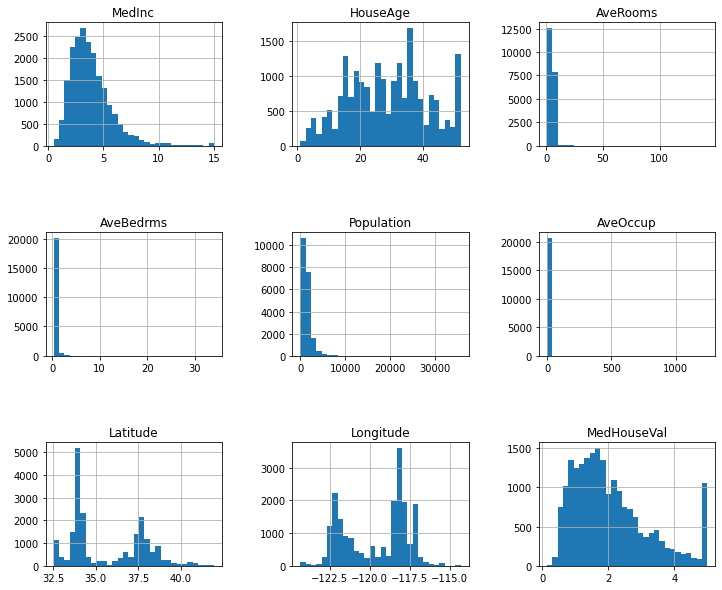

In [ ]:
import matplotlib.pyplot as plt

california_housing.frame.hist(bins=30, figsize=(12,10))
plt.subplots_adjust(hspace=.7, wspace=.4)

In [ ]:
## Standard the features
X, y = california_housing.data, california_housing.target

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X)
X = scaler.transform(X)

# X = scaler.fit_transform(X)

## double-check the feature
print(X.mean(axis=0))
print(X.std(axis=0))

[ 6.60969987e-17  5.50808322e-18  6.60969987e-17 -1.06030602e-16
 -1.10161664e-17  3.44255201e-18 -1.07958431e-15 -8.52651283e-15]
[1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
## create training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Make prediction based on **kNN regression** `sklearn.neighbors.KNeighborsRegressor`

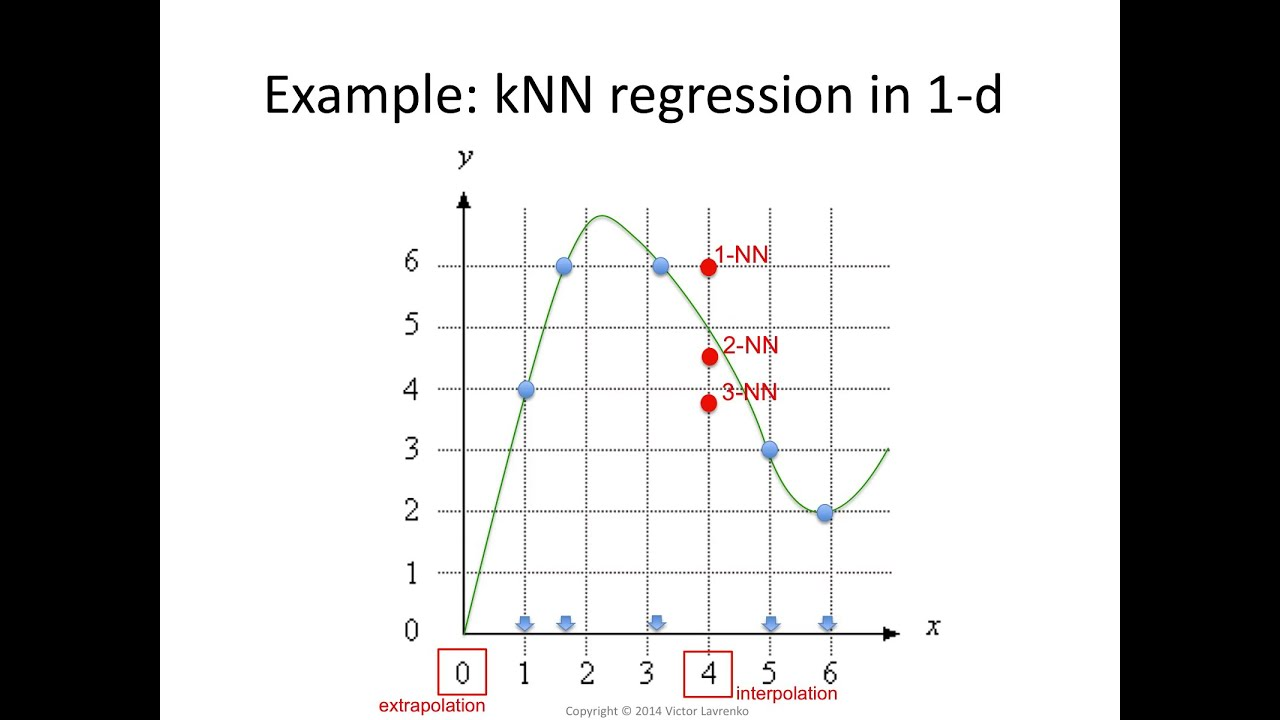

In [ ]:
## kNN regression (training)
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=X_train, y=y_train)
pred_y = knn.predict(X = X_test)
print(pred_y)

[0.487      0.67366667 5.00000667 ... 2.51466667 1.563      2.319     ]


In [ ]:
## report the performance
rmse = np.sqrt(np.mean((pred_y - y_test)**2))
print('n_neighbors = 3; RMSE: %.3f' %rmse)

n_neighbors = 3; RMSE: 0.684


In [ ]:
for k in range(1,30,3):
  knn = KNeighborsRegressor(n_neighbors=k)
  knn.fit(X=X_train, y=y_train)
  pred_y = knn.predict(X = X_test)
  rmse = np.sqrt(np.mean((pred_y - y_test)**2))
  print('n_neighbors: %d; RMSE: %.3f' %(k, rmse))

n_neighbors: 1; RMSE: 0.818
n_neighbors: 4; RMSE: 0.668
n_neighbors: 7; RMSE: 0.652
n_neighbors: 10; RMSE: 0.648
n_neighbors: 13; RMSE: 0.648
n_neighbors: 16; RMSE: 0.648
n_neighbors: 19; RMSE: 0.650
n_neighbors: 22; RMSE: 0.653
n_neighbors: 25; RMSE: 0.654
n_neighbors: 28; RMSE: 0.655


## **Overfitting** VS. **underfitting**

- When k 📈 => train mse 📉 && test mse 📉 + 📈



## Use **Cross-validation** to find the optimal hyperparameters
- The number of neighbors in kNN model is a hyperparamter
- The weight for the l2 penality in ridge regression is a hyperparamter

### Further split **train set** into **train set** and **valid set**

In [ ]:
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train, y_train, test_size = 0.33, random_state=42)

### Cross-validation for `KNeighborsRegressor`



In [ ]:
## Cross-validation
valid_mse_lst = []
candidate_k = [1, 5, 10, 20, 50, 100]
for k in candidate_k:
  knn = KNeighborsRegressor(n_neighbors=k)
  knn.fit(X=X_train_sub, y=y_train_sub)

  pred_y_train = knn.predict(X=X_train_sub)
  pred_y = knn.predict(X = X_valid)

  train_mse = np.mean((y_train_sub - pred_y_train)**2)
  valid_mse = np.mean((pred_y - y_valid)**2)
  valid_mse_lst.append(valid_mse)
  print('n_neighbors: %d; train_MSE: %.3f; valid_MSE: %.3f' %(k, train_mse, valid_mse))

n_neighbors: 1; train_MSE: 0.000; valid_MSE: 0.648
n_neighbors: 5; train_MSE: 0.287; valid_MSE: 0.435
n_neighbors: 10; train_MSE: 0.345; valid_MSE: 0.426
n_neighbors: 20; train_MSE: 0.387; valid_MSE: 0.433
n_neighbors: 50; train_MSE: 0.436; valid_MSE: 0.457
n_neighbors: 100; train_MSE: 0.474; valid_MSE: 0.487


- Find the optimal k which minimizes the validation MSE

In [ ]:
optimal_k = candidate_k[np.argmin(valid_mse_lst)]
print('the optimal k determined by cross-validation is %d' %optimal_k)

the optimal k determined by cross-validation is 10


- Refit the whole dataset with **optimal** hyperparameter

In [ ]:
optimal_knn = KNeighborsRegressor(n_neighbors=optimal_k)
optimal_knn.fit(X=X_train, y=y_train)

KNeighborsRegressor(n_neighbors=10)

- Predict `X_test` based on the model fitted with the optimal hyperparameter

In [ ]:
## kNN regression (prediction)
y_pred = optimal_knn.predict(X_test)
mse_test = np.mean((y_pred - y_test)**2)
print('test_mse: %.3f' %mse_test)

test_mse: 0.420


### Cross-validation for `sklearn.linear_model.Ridge`
- ||y - Xw||^2_2 + alpha * ||w||^2_2
- The hyperparameter is *norm of linear coefficients*, i.e., control the magnitude of the parameters to control the *model complexity*
- Some rules to select your **Grid**

In [ ]:
from sklearn.linear_model import Ridge
candidate_alpha = [0.00, .0001, .05, .1, .5, 1, 10, 50, 100, 1000]
# candidate_alpha = 10**np.arange(-3,3,.3)
valid_mse_lst = []

for alpha in candidate_alpha:
  clf = Ridge(alpha=alpha)
  clf.fit(X_train_sub, y_train_sub)

  y_pred_train = clf.predict(X_train_sub)
  y_pred_valid = clf.predict(X_valid)

  train_mse = np.mean((y_pred_train - y_train_sub)**2)
  valid_mse = np.mean((y_pred_valid - y_valid)**2)

  print('alpha: %.3f; train_MSE: %.4f; valid_MSE: %.4f' %(alpha, train_mse, valid_mse))

  valid_mse_lst.append(valid_mse)

alpha: 0.000; train_MSE: 0.5192; valid_MSE: 0.5231
alpha: 0.000; train_MSE: 0.5192; valid_MSE: 0.5231
alpha: 0.050; train_MSE: 0.5192; valid_MSE: 0.5231
alpha: 0.100; train_MSE: 0.5192; valid_MSE: 0.5231
alpha: 0.500; train_MSE: 0.5192; valid_MSE: 0.5231
alpha: 1.000; train_MSE: 0.5192; valid_MSE: 0.5231
alpha: 10.000; train_MSE: 0.5193; valid_MSE: 0.5230
alpha: 50.000; train_MSE: 0.5199; valid_MSE: 0.5233
alpha: 100.000; train_MSE: 0.5216; valid_MSE: 0.5246
alpha: 1000.000; train_MSE: 0.5746; valid_MSE: 0.5784


In [ ]:
optimal_alpha = candidate_alpha[np.argmin(valid_mse_lst)]
print('the optimal alpha determined by cross-validation is %d' %optimal_alpha)

the optimal alpha determined by cross-validation is 10


In [ ]:
## make prediction based on the best param
clf_best = Ridge(alpha=optimal_alpha)
clf_best.fit(X_train, y_train)

y_pred_test = clf.predict(X_test)

test_mse = np.mean((y_pred_test - y_test)**2)
print(test_mse)

0.581422212415965


## k-Fold Cross Validation

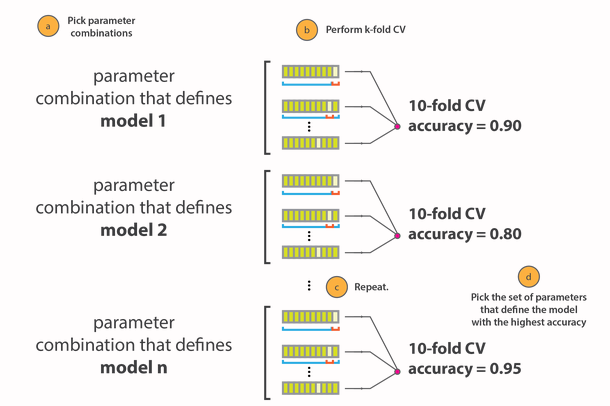

**Homework**: program 5-fold Cross-validation based on `fetch_california_housing` dataset for kNN regression and ridge regression.

## To-do list

- **STAT**

  - [ ] Understand the framework of ML methods
  - [ ] Understand underfitting, overfitting, and how to solve them
  - [ ] cross-validation
  - [ ] derive baseline models based on the ML framework

- **Code**

  - [ ] Preprocessing; standardize features
  - [ ] Python class; parameters; and methods
  - [ ] implement a simple ML regression task
  - [ ] implement cross-validation

# Matrix Factorization I: BCD/ALS


In [ ]:
# Load and pro-processed dataset
import numpy as np
import pandas as pd

## Upload Netflix dataset in CUHK-STAT3009 Github repo

train_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/train.csv"
test_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/test.csv"

dtrain = pd.read_csv(train_url)
dtest = pd.read_csv(test_url)

train_rating = dtrain['rating'].values
train_rating = np.array(train_rating, dtype=float)
train_pair = dtrain[['user_id', 'movie_id']].values

test_rating = dtest['rating'].values
test_rating = np.array(test_rating, dtype=float)
test_pair = dtest[['user_id', 'movie_id']].values

n_user = max( max(train_pair[:,0]), max(test_pair[:,0]) ) + 1
n_item = max( max(train_pair[:,1]), max(test_pair[:,1]) ) + 1

def rmse(test_rating, pred_rating):
    return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

## ALS-MF
### Idea
  - BCD perfectly fits our formulation
  - solve $\mathbf{Q}$ (fixed $\mathbf{P}$) $\to$ solve $\mathbf{P}$ (fixed $\mathbf{Q}$) $\to$ ...

### Steps

- When $\mathbf{P}$ is fixed, the objective function for $\mathbf{Q}$ is a standard QP, and each $\mathbf{q}_i$ can be solved **parallelly** with an **analytic solution**:
$$ \mathbf{q}^{(l+1)}_i = ( \sum_{u \in \mathcal{U}_i} \mathbf{p}^{(l)}_u (\mathbf{p}^{(l)}_u)^\intercal + \lambda |\Omega| \mathbf{I})^{-1} \sum_{u \in \mathcal{U}_i} r_{ui} \mathbf{p}^{(l)}_u $$

- When $\mathbf{Q}$ is fixed, the objective function for $\mathbf{P}$ is a standard QP, and each $\mathbf{p}_i$ can be solved **parallelly** with an **analytic solution**.
$$\mathbf{p}^{(l+1)}_u =  ( \sum_{i \in \mathcal{I}_u} \mathbf{q}^{(l+1)}_i (\mathbf{q}^{(l+1)}_i)^\intercal + \lambda |\Omega| \mathbf{I})^{-1} \sum_{i \in \mathcal{I}_u} r_{ui} \mathbf{q}^{(l+1)}_i$$


### illustrated with user-0 and item-0

In [ ]:
## Initialization
K, lam = 5, .1 # hps
n_obs = len(train_rating)
P = np.random.randn(n_user, K)
Q = np.random.randn(n_item, K)

index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]

In [ ]:
## illustrated with user-0 and item-0
# update q0
item_id = 0
# find index for item
index_item_tmp = index_item[item_id]
# compute `sum_pu` and `sum_matrix`
sum_pu, sum_matrix = np.zeros(K), np.zeros((K,K))
for record in index_item_tmp:
  user_id, rating_tmp = train_pair[record, 0], train_rating[record]
  sum_pu = sum_pu + rating_tmp*P[user_id,:]
  sum_matrix = sum_matrix + np.outer(P[user_id,:], P[user_id,:])

[425   0]
[161   0]
[566   0]


In [ ]:
Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)),sum_pu)
print('the one-step sol of q0: %s' %Q[item_id,:])

the one-step sol of q0: [ 0.00253745  0.00015233 -0.00067777  0.00078553  0.00110766]


In [ ]:
# update p0
user_id = 0
# find index for user
index_user_tmp = index_user[user_id]
# compute `sum_qi` and `sum_matrix`
sum_qi, sum_matrix = np.zeros(K), np.zeros((K,K))
for record in index_user_tmp:
  item_tmp, rating_tmp = train_pair[record, 1], train_rating[record]
  sum_qi = sum_qi + rating_tmp * Q[item_tmp,:]
  sum_matrix = sum_matrix + np.outer(Q[item_tmp,:], Q[item_tmp,:])

In [ ]:
P[user_id,:] = np.linalg.inv( sum_matrix + lam*n_obs*np.identity(K)) @ sum_qi
print('the one-step sol of q0: %s' %P[user_id,:])

the one-step sol of q0: [ 0.00658533  0.01476455 -0.00387359 -0.00691572  0.01143219]


### Make a `skikit-learn` compatible class


- **Parameter**:
    - #Users: `n`
    - #Items: `m`
    - latent factors for users: `P`
    - latent factors for items: `Q`
    - l2-weight (*hp*): `lam`
    - #Latent factors (*hp*): `K`

- **Method**:

  - `fit`:
    - *input*: `train_pair`, `train_rating`
    - *output*: fitted P and Q
  - `predict`:
    - *input*: `test_pair`
    - *output*: predicted ratings
  - `rmse`:
    - *input*: `test_pair`, `test_rating`
    - *output*: RMSE for the predicted ratings

  - `obj`:
    - *input*: `test_pair`, `test_rating`
    - *output*: objective function for the MF method


In [ ]:
class MF(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=50, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam

        ## store user/item index set
        index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]

        if self.verbose:
            print('Fitting Reg-MF: K: %d, lam: %.5f' %(K, lam))

        for i in range(iterNum):
            obj_old = self.obj(test_pair=train_pair, test_rating=train_rating)
            ## item update
            for item_id in range(n_item):
              index_item_tmp = index_item[item_id]
              # compute `sum_pu` and `sum_matrix`
              sum_pu, sum_matrix = np.zeros(K), np.zeros((K,K))
              for record in index_item_tmp:
                user_id, rating_tmp = train_pair[record, 0], train_rating[record]
                sum_pu = sum_pu + rating_tmp*self.P[user_id,:]
                sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
              self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)),sum_pu)

            ## User update
            for user_id in range(n_user):
              index_user_tmp = index_user[user_id]
              # compute `sum_qi` and `sum_matrix`
              sum_qi, sum_matrix = np.zeros(K), np.zeros((K,K))
              for record in index_user_tmp:
                item_tmp, rating_tmp = train_pair[record, 1], train_rating[record]
                sum_qi = sum_qi + rating_tmp * self.Q[item_tmp,:]
                sum_matrix = sum_matrix + np.outer(self.Q[item_tmp,:], self.Q[item_tmp,:])
              self.P[user_id,:] = np.linalg.inv( sum_matrix + lam*n_obs*np.identity(K)) @ sum_qi

            ## check the objective function
            obj_new = self.obj(test_pair=train_pair, test_rating=train_rating)
            diff = abs(obj_new - obj_old)
           # compute the new rmse score
            if self.verbose:
                print("Reg-MF: ite: %d; diff: %.3f Obj: %.3f" %(i, diff, obj_new))
            if(diff < tol):
              break

    def predict(self, test_pair):
      pred_rating = [ np.dot(self.P[record[0]], self.Q[record[1]]) for record in test_pair]
      return np.array(pred_rating)

    def rmse(self, test_pair, test_rating):
      pred_rating = self.predict(test_pair)
      return np.mean((test_rating - pred_rating)**2)

    def obj(self, test_pair, test_rating):
      return self.rmse(test_pair, test_rating) + self.lam*( np.sum((self.P)**2) + np.sum((self.Q)**2))


In [ ]:
# fitting
cue = MF(n_user=n_user, n_item=n_item, K=10, lam=.00001)
cue.fit(train_pair=train_pair, train_rating=train_rating)

Fitting Reg-MF: K: 10, lam: 0.00001
Reg-MF: ite: 0; diff: 17.851 Obj: 6.919
Reg-MF: ite: 1; diff: 5.626 Obj: 1.293
Reg-MF: ite: 2; diff: 0.545 Obj: 0.748
Reg-MF: ite: 3; diff: 0.104 Obj: 0.644
Reg-MF: ite: 4; diff: 0.046 Obj: 0.598
Reg-MF: ite: 5; diff: 0.027 Obj: 0.571
Reg-MF: ite: 6; diff: 0.018 Obj: 0.553
Reg-MF: ite: 7; diff: 0.013 Obj: 0.540
Reg-MF: ite: 8; diff: 0.010 Obj: 0.530
Reg-MF: ite: 9; diff: 0.008 Obj: 0.523
Reg-MF: ite: 10; diff: 0.006 Obj: 0.516
Reg-MF: ite: 11; diff: 0.005 Obj: 0.511
Reg-MF: ite: 12; diff: 0.004 Obj: 0.507
Reg-MF: ite: 13; diff: 0.004 Obj: 0.503
Reg-MF: ite: 14; diff: 0.004 Obj: 0.499
Reg-MF: ite: 15; diff: 0.003 Obj: 0.496
Reg-MF: ite: 16; diff: 0.003 Obj: 0.493
Reg-MF: ite: 17; diff: 0.003 Obj: 0.491
Reg-MF: ite: 18; diff: 0.002 Obj: 0.488
Reg-MF: ite: 19; diff: 0.002 Obj: 0.486
Reg-MF: ite: 20; diff: 0.002 Obj: 0.484
Reg-MF: ite: 21; diff: 0.002 Obj: 0.482
Reg-MF: ite: 22; diff: 0.002 Obj: 0.480
Reg-MF: ite: 23; diff: 0.002 Obj: 0.479
Reg-MF: ite: 

In [ ]:
pred_train_rating = cue.predict(train_pair)
pred_rating = cue.predict(test_pair)

In [ ]:
# pediction
print('train rmse: %.3f; test rmse: %.3f' %(rmse(train_rating, pred_train_rating), rmse(test_rating, pred_rating)))

train rmse: 0.492; test rmse: 1.370


### Make a `skikit-learn` compatible class for baseline methods

| Method |  Model                   | param                            |
|--------| ----------------------   |----------------------------------|
| Glb    | $\hat{r}_{ui}$ = $\mu_0$ |$\mu_0$                           |
|User    | $\hat{r}_{ui}$ = $a_u$   |$\mathbf{a}$ = ($a_1$, ..., $a_n$)|
| Item   | $\hat{r}_{ui}$ = $b_i$   |$\mathbf{b}$ = ($b_1$, ..., $b_m$)|

In [ ]:
class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0

	def fit(self, train_ratings):
		self.glb_mean = np.mean(train_ratings)

	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred

class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)

	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_ratings[ind_train].mean()

	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)

	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_ratings[ind_train].mean()

	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred

In [ ]:
my_glb = glb_mean()
my_glb.fit(train_ratings = train_rating)
pred_rating = my_glb.predict(test_pair)
print('glb rmse: %.3f' %rmse(test_rating, pred_rating))

glb rmse: 1.085


## Sequential modeling: baseline models + MF

In [ ]:
## Baseline + MF
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)

# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)

# fit MF RS by residual ratings
cue = MF(n_user, n_item, K=5, lam=.0001)
cue.fit(train_pair=train_pair, train_rating=train_rating_res)
pred = pred + cue.predict(test_pair)

print('RMSE for glb + user_mean + MF: %.3f' %rmse(test_rating, pred) )

Fitting Reg-MF: K: 5, lam: 0.00010
Reg-MF: ite: 0; diff: 8.224 Obj: 0.925
Reg-MF: ite: 1; diff: 0.078 Obj: 0.847
Reg-MF: ite: 2; diff: 0.057 Obj: 0.790
Reg-MF: ite: 3; diff: 0.024 Obj: 0.766
Reg-MF: ite: 4; diff: 0.010 Obj: 0.756
Reg-MF: ite: 5; diff: 0.005 Obj: 0.751
Reg-MF: ite: 6; diff: 0.003 Obj: 0.748
Reg-MF: ite: 7; diff: 0.002 Obj: 0.746
Reg-MF: ite: 8; diff: 0.001 Obj: 0.745
Reg-MF: ite: 9; diff: 0.001 Obj: 0.744
Reg-MF: ite: 10; diff: 0.001 Obj: 0.743
Reg-MF: ite: 11; diff: 0.001 Obj: 0.742
Reg-MF: ite: 12; diff: 0.001 Obj: 0.742
Reg-MF: ite: 13; diff: 0.000 Obj: 0.741
Reg-MF: ite: 14; diff: 0.000 Obj: 0.741
Reg-MF: ite: 15; diff: 0.000 Obj: 0.740
Reg-MF: ite: 16; diff: 0.000 Obj: 0.740
Reg-MF: ite: 17; diff: 0.000 Obj: 0.740
Reg-MF: ite: 18; diff: 0.000 Obj: 0.740
Reg-MF: ite: 19; diff: 0.000 Obj: 0.739
Reg-MF: ite: 20; diff: 0.000 Obj: 0.739
Reg-MF: ite: 21; diff: 0.000 Obj: 0.739
Reg-MF: ite: 22; diff: 0.000 Obj: 0.739
Reg-MF: ite: 23; diff: 0.000 Obj: 0.739
Reg-MF: ite: 24

## To-do list

- **STAT**
  - [ ] Idea and movitation of Matrix factorization (MF)
  - [ ] Idea of Blockwise coordinate descent (BCD)
  - [ ] Use BCD to solve regularized MF
  - [ ] Able to find a solution of BCD to a general QP
  - [ ] Use MF to make prediction for RS

- **Code**
  - [ ] Param and hps of MF
  - [ ] Implement MF by using MF
  - [ ] Implement BCD for a general QP

# Matrix Factorization: GD and SGD

In [ ]:
# Load and pro-processed dataset
import numpy as np
import pandas as pd

## Upload Netflix dataset in CUHK-STAT3009 Github repo

train_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/train.csv"
test_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/test.csv"

dtrain = pd.read_csv(train_url)
dtest = pd.read_csv(test_url)

train_rating = dtrain['rating'].values
train_rating = np.array(train_rating, dtype=float)
train_pair = dtrain[['user_id', 'movie_id']].values

test_rating = dtest['rating'].values
test_rating = np.array(test_rating, dtype=float)
test_pair = dtest[['user_id', 'movie_id']].values

n_user = max( max(train_pair[:,0]), max(test_pair[:,0]) ) + 1
n_item = max( max(train_pair[:,1]), max(test_pair[:,1]) ) + 1

def rmse(test_rating, pred_rating):
    return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

## Implement GD for MF

- **ALS** structure with **GD** for solving each sub-problem
- One additional HP in GD: `step_size` or `learning_rate`
- Item-GD:
$$
\mathbf{q}^{(new)}_i = \mathbf{q}^{(old)}_i - 2 \alpha \big( - \frac{1}{|\Omega|} \sum_{u \in \mathcal{U}_i } \mathbf{p}_u (r_{ui} -\mathbf{p}_u^\intercal \mathbf{q}^{(old)}_i) + \lambda \mathbf{q}^{(old)}_i \big)
$$
- User-GD
$$
\mathbf{p}^{(new)}_u = \mathbf{p}^{(old)}_u - 2 \alpha \big( - \frac{1}{|\Omega|} \sum_{i \in \mathcal{I}_u } \mathbf{q}_i (r_{ui} - \mathbf{q}_i^\intercal \mathbf{p}^{(old)}_u)  + \lambda \mathbf{p}^{(old)}_u \big)
$$


In [ ]:
class MF(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=1000, GDiterNum=10, tol=1e-4):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.GDiterNum = GDiterNum
        self.tol = tol

    def fit(self, train_pair, train_rating, learning_rate=0.0001):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        print('Fitting Reg-MF: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            obj_old = self.obj(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                train_pair_tmp, train_rating_tmp = train_pair[index_item_tmp], train_rating[index_item_tmp]
                ## GD block
                for h in range(self.GDiterNum):
                  ## compute res on the current model
                  err_tmp = train_rating_tmp - self.predict(test_pair=train_pair_tmp)
                  sum_pu = np.sum(self.P[train_pair_tmp[:,0]] * err_tmp[:,np.newaxis], 0) / n_obs
                  ## GD updates for Q
                  self.Q[item_id] = self.Q[item_id] + 2*learning_rate*sum_pu - 2*learning_rate*lam*self.Q[item_id]

            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                train_pair_tmp, train_rating_tmp = train_pair[index_user_tmp], train_rating[index_user_tmp]
                for h in range(self.GDiterNum):
                  ## compute res on the current model
                  err_tmp = train_rating_tmp - self.predict(test_pair=train_pair_tmp)
                  sum_qi = np.sum(self.Q[train_pair_tmp[:,1]] * err_tmp[:,np.newaxis], 0) / n_obs
                  ## GD updates for Q
                  self.P[user_id] = self.P[user_id] + 2*learning_rate*sum_qi - 2*learning_rate*lam*self.P[user_id]

            # compute the new rmse score
            obj_new = self.obj(test_pair=train_pair, test_rating=train_rating)
            rmse_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = - obj_new + obj_old
            print("Reg-MF: GD - ite: %d; diff: %.3f; Obj: %.3f; RMSE: %.3f" %(i, diff, obj_new, rmse_new))
            if (diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)

    def obj(self, test_pair, test_rating):
        return (self.rmse(test_pair, test_rating))**2 + self.lam*np.sum(self.P**2) + self.lam*np.sum(self.Q**2)

    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `MF`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

In [ ]:
# fitting
cue = MF(n_user, n_item, K=10, lam=.00001)
# For GD, to save training time, we can select a large lr first, then generally reduce...
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=10.)

Fitting Reg-MF: K: 10, lam: 0.00001
Reg-MF: GD - ite: 0; diff: 8.222; Obj: 16.927; RMSE: 4.060
Reg-MF: GD - ite: 1; diff: 2.250; Obj: 14.678; RMSE: 3.775
Reg-MF: GD - ite: 2; diff: 2.229; Obj: 12.448; RMSE: 3.468
Reg-MF: GD - ite: 3; diff: 3.342; Obj: 9.106; RMSE: 2.947
Reg-MF: GD - ite: 4; diff: 2.684; Obj: 6.423; RMSE: 2.449
Reg-MF: GD - ite: 5; diff: 1.509; Obj: 4.914; RMSE: 2.118
Reg-MF: GD - ite: 6; diff: 0.909; Obj: 4.005; RMSE: 1.891
Reg-MF: GD - ite: 7; diff: 0.599; Obj: 3.406; RMSE: 1.726
Reg-MF: GD - ite: 8; diff: 0.421; Obj: 2.985; RMSE: 1.599
Reg-MF: GD - ite: 9; diff: 0.310; Obj: 2.674; RMSE: 1.499
Reg-MF: GD - ite: 10; diff: 0.237; Obj: 2.437; RMSE: 1.417
Reg-MF: GD - ite: 11; diff: 0.186; Obj: 2.251; RMSE: 1.350
Reg-MF: GD - ite: 12; diff: 0.150; Obj: 2.101; RMSE: 1.293
Reg-MF: GD - ite: 13; diff: 0.123; Obj: 1.978; RMSE: 1.245
Reg-MF: GD - ite: 14; diff: 0.103; Obj: 1.875; RMSE: 1.203
Reg-MF: GD - ite: 15; diff: 0.087; Obj: 1.789; RMSE: 1.166
Reg-MF: GD - ite: 16; diff:

KeyboardInterrupt: ignored

In [ ]:
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=1.)

In [ ]:
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=.1)

In [ ]:
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=.01)

In [ ]:
# pediction
pred_rating = cue.predict(test_pair)
pred_train_rating = cue.predict(train_pair)
print('train rmse: %.3f; test rmse: %.3f' %(rmse(train_rating, pred_train_rating), rmse(test_rating, pred_rating)))

## Solve **MF** by **SGD**

- SGD focus on just ONE sample:
	- Sample just one user-item pair $(u,i)$:
$$\text{argmin}_{\mathbf{p}_u, \mathbf{q}_i} \ (r_{ui} - \mathbf{p}^\intercal_u \mathbf{q}_i )^2 + \lambda \big( \| \mathbf{p}_u \|_2^2 + \mathbf{q}_i \|_2^2 \big)
$$

- Upadte the corresponding **gradient** for $\mathbf{p}_u$ and $\mathbf{q}_i$, and updates $\mathbf{p}_u$ and $\mathbf{q}_i$ as follows:
$$
\mathbf{q}^{(l+1)}_i = \mathbf{q}^{(l)}_i + 2 \alpha \big( (r_{ui} - (\mathbf{p}^{(l)}_u)^\intercal \mathbf{q}^{(l)}_i) \mathbf{p}^{(l)}_u - \lambda \mathbf{q}^{(l)}_i \big),
$$
$$
\mathbf{p}^{(l+1)}_u = \mathbf{p}^{(l)}_u + 2 \alpha \big( (r_{ui} - (\mathbf{q}^{(l+1)}_i)^\intercal \mathbf{p}^{(l)}_u) \mathbf{q}^{(l+1)}_i - \lambda \mathbf{p}^{(l)}_u \big)
$$

In [ ]:
class MF(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=1000, tol=1e-4):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol

    def fit(self, train_pair, train_rating, learning_rate=0.0001):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        print('Fitting Reg-MF: K: %d, lam: %.5f' %(K, lam))
        sgd_ind = np.arange(n_obs, dtype=int)
        for i in range(iterNum):
            ## shuffle the order of SGD updates
            np.random.shuffle(sgd_ind)
            ## SGD updates
            obj_old = self.obj(test_pair=train_pair, test_rating=train_rating)
            for j in sgd_ind:
                user_id, item_id, rating_tmp = train_pair[j,0], train_pair[j,1], train_rating[j]
                err_tmp = rating_tmp - np.dot(self.P[user_id], self.Q[item_id])
                self.Q[item_id] = self.Q[item_id] + 2*learning_rate*err_tmp*self.P[user_id] - 2*learning_rate*lam*self.Q[item_id,:]
                err_tmp = rating_tmp - np.dot(self.P[user_id], self.Q[item_id])
                self.P[user_id] = self.P[user_id] + 2*learning_rate*err_tmp*self.Q[item_id] - 2*learning_rate*lam*self.P[user_id,:]
            # compute the new rmse score
            obj_new = self.obj(test_pair=train_pair, test_rating=train_rating)
            rmse_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = - obj_new + obj_old
            print("Reg-MF: GD - ite: %d; diff: %.3f; Obj: %.3f; RMSE: %.3f" %(i, diff, obj_new, rmse_new))

            if (diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)

    def obj(self, test_pair, test_rating):
        return (self.rmse(test_pair, test_rating))**2 + self.lam*np.sum(self.P**2) + self.lam*np.sum(self.Q**2)

    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `MF`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )


In [ ]:
# fitting
cue = MF(n_user, n_item, K=10, lam=.00001)
# For GD, to save training time, we can select a large lr first, then generally reduce...
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=.01)

Fitting Reg-MF: K: 10, lam: 0.00001
Reg-MF: GD - ite: 0; diff: 17.939; Obj: 6.365; RMSE: 2.419
Reg-MF: GD - ite: 1; diff: 3.609; Obj: 2.757; RMSE: 1.495
Reg-MF: GD - ite: 2; diff: 0.770; Obj: 1.986; RMSE: 1.207
Reg-MF: GD - ite: 3; diff: 0.315; Obj: 1.671; RMSE: 1.067
Reg-MF: GD - ite: 4; diff: 0.167; Obj: 1.504; RMSE: 0.983
Reg-MF: GD - ite: 5; diff: 0.090; Obj: 1.414; RMSE: 0.935
Reg-MF: GD - ite: 6; diff: 0.065; Obj: 1.349; RMSE: 0.898
Reg-MF: GD - ite: 7; diff: 0.046; Obj: 1.303; RMSE: 0.871
Reg-MF: GD - ite: 8; diff: 0.029; Obj: 1.273; RMSE: 0.852
Reg-MF: GD - ite: 9; diff: 0.027; Obj: 1.247; RMSE: 0.835
Reg-MF: GD - ite: 10; diff: 0.016; Obj: 1.231; RMSE: 0.825
Reg-MF: GD - ite: 11; diff: 0.017; Obj: 1.214; RMSE: 0.814
Reg-MF: GD - ite: 12; diff: 0.013; Obj: 1.201; RMSE: 0.805
Reg-MF: GD - ite: 13; diff: 0.009; Obj: 1.192; RMSE: 0.798
Reg-MF: GD - ite: 14; diff: 0.010; Obj: 1.182; RMSE: 0.791
Reg-MF: GD - ite: 15; diff: 0.007; Obj: 1.175; RMSE: 0.786
Reg-MF: GD - ite: 16; diff: 0

In [ ]:
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=.001)

Fitting Reg-MF: K: 10, lam: 0.00001
Reg-MF: GD - ite: 0; diff: 0.041; Obj: 1.093; RMSE: 0.725
Reg-MF: GD - ite: 1; diff: 0.010; Obj: 1.084; RMSE: 0.718
Reg-MF: GD - ite: 2; diff: 0.004; Obj: 1.080; RMSE: 0.715
Reg-MF: GD - ite: 3; diff: 0.002; Obj: 1.077; RMSE: 0.714
Reg-MF: GD - ite: 4; diff: 0.001; Obj: 1.076; RMSE: 0.713
Reg-MF: GD - ite: 5; diff: 0.001; Obj: 1.075; RMSE: 0.712
Reg-MF: GD - ite: 6; diff: 0.001; Obj: 1.074; RMSE: 0.711
Reg-MF: GD - ite: 7; diff: 0.001; Obj: 1.073; RMSE: 0.711
Reg-MF: GD - ite: 8; diff: 0.001; Obj: 1.073; RMSE: 0.710
Reg-MF: GD - ite: 9; diff: 0.001; Obj: 1.072; RMSE: 0.710
Reg-MF: GD - ite: 10; diff: 0.000; Obj: 1.072; RMSE: 0.710
Reg-MF: GD - ite: 11; diff: 0.001; Obj: 1.071; RMSE: 0.709
Reg-MF: GD - ite: 12; diff: 0.000; Obj: 1.071; RMSE: 0.709
Reg-MF: GD - ite: 13; diff: 0.000; Obj: 1.071; RMSE: 0.708
Reg-MF: GD - ite: 14; diff: 0.000; Obj: 1.070; RMSE: 0.708
Reg-MF: GD - ite: 15; diff: 0.000; Obj: 1.070; RMSE: 0.708
Reg-MF: GD - ite: 16; diff: 0.

In [ ]:
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=.0001)

In [ ]:
cue.fit(train_pair=train_pair, train_rating=train_rating, learning_rate=.00001)

## **Cross-validation** for **MF**

- We use **ALS/BCD** to solve every **MF** (since it is most efficient)

- Use 5-fold CV to determine the best HPs

- The Grid in the code is just for demonstration, the performance can be further improved by carefully tune the Grid

In [ ]:
## Recall the MF via ALS

class MF(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=50, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]

        if self.verbose:
            print('Fitting Reg-MF: K: %d, lam: %.5f' %(K, lam))

        for i in range(iterNum):
            ## item update
            obj_old = self.obj(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                ## compute `sum_pu` and `sum_matrix`
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is worning in updating Q!')
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
                    sum_pu = sum_pu + rating_tmp * self.P[user_id,:]
                self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)

            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                ## compute `sum_qi` and `sum_matrix`
                sum_qi, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is worning in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                    sum_qi = sum_qi + rating_tmp * self.Q[item_id,:]
                self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_qi)
            # compute the new rmse score
            obj_new = self.obj(test_pair=train_pair, test_rating=train_rating)
            diff = abs(obj_new - obj_old) / obj_old
            if self.verbose:
                print("Reg-MF: ite: %d; diff: %.3f Obj: %.3f" %(i, diff, obj_new))
            if(diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)

    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `MF`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

    def obj(self, test_pair, test_rating):
        return (self.rmse(test_pair, test_rating))**2 + self.lam*np.sum(self.P**2) + self.lam*np.sum(self.Q**2)

In [ ]:
from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class MF_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01],
				Ks=[3,5,10,20],
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = MF(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				## valid model in the validation set
				train_rmse_tmp_cv = model_tmp.rmse(train_pair_cv, train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(valid_pair_cv, valid_rating_cv)
				train_rmse_tmp += train_rmse_tmp_cv/self.cv
				valid_rmse_tmp += valid_rmse_tmp_cv/self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f'
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]

	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

In [ ]:
## class for baseline methods
class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)

	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_rating[ind_train].mean()

	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)

	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_rating[ind_train].mean()

	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred

In [ ]:
## Baseline models
# user_mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating)
train_rating_res = train_rating - user_ave.predict(train_pair)
pred = user_ave.predict(test_pair)

## item_mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_res)
train_rating_res = train_rating_res - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)

print('user-item mean rmse: %.3f' %rmse(test_rating, pred))

user-item mean rmse: 0.976


3-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.671, valid_rmse: 1.043
3-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.669, valid_rmse: 1.053
3-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.673, valid_rmse: 1.071
3-Fold CV for K: 3; lam: 0.00003: train_rmse: 0.689, valid_rmse: 0.990
3-Fold CV for K: 3; lam: 0.00003: train_rmse: 0.692, valid_rmse: 0.993
3-Fold CV for K: 3; lam: 0.00003: train_rmse: 0.690, valid_rmse: 0.986
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.739, valid_rmse: 0.925
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.736, valid_rmse: 0.918
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.735, valid_rmse: 0.922
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.825, valid_rmse: 0.875
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.825, valid_rmse: 0.878
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.824, valid_rmse: 0.873
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 0.876, valid_rmse: 0.889
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 0.883, valid_rmse: 0.875
3-Fold

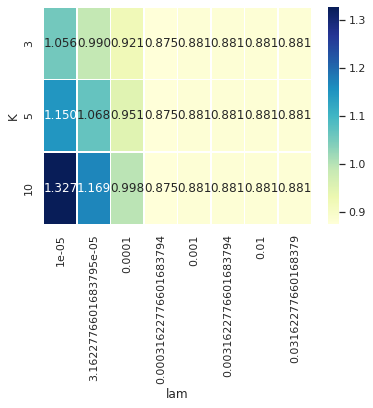

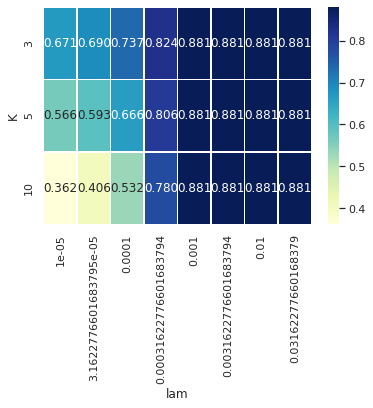

In [ ]:
Ks, lams = [3, 5, 10], 10**np.arange(-5, -1, .5)

MF_cv = MF_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
MF_cv.grid_search(train_pair, train_rating_res)
MF_cv.plot_grid('valid')
MF_cv.plot_grid('train')

In [ ]:
MF_cv.cv_result

,K,lam,train_rmse,valid_rmse
0,3,0.000010,0.670104,1.049989
1,3,0.000032,0.689655,0.986770
2,3,0.000100,0.735820,0.923531
3,3,0.000316,0.823671,0.874418
4,3,0.001000,0.880660,0.880635
5,3,0.003162,0.880669,0.880667
6,3,0.010000,0.880665,0.880650
7,3,0.031623,0.880667,0.880658
8,5,0.000010,0.566903,1.161174
9,5,0.000032,0.595106,1.057716


In [ ]:
MF_cv.best_model

K             3.000000
lam           0.000316
train_rmse    0.823671
valid_rmse    0.874418
Name: 3, dtype: float64

In [ ]:
## refit the best model by the best tuned Hps
best_MF = MF(n_user, n_item, K=int(MF_cv.best_model['K']), lam=MF_cv.best_model['lam'], verbose=1)
best_MF.fit(train_pair, train_rating_res)

Fitting Reg-MF: K: 3, lam: 0.00032
Reg-MF: ite: 0; diff: 0.911 Obj: 0.785
Reg-MF: ite: 1; diff: 0.013 Obj: 0.774
Reg-MF: ite: 2; diff: 0.004 Obj: 0.771
Reg-MF: ite: 3; diff: 0.005 Obj: 0.768
Reg-MF: ite: 4; diff: 0.003 Obj: 0.766
Reg-MF: ite: 5; diff: 0.001 Obj: 0.765
Reg-MF: ite: 6; diff: 0.000 Obj: 0.765
Reg-MF: ite: 7; diff: 0.000 Obj: 0.764
Reg-MF: ite: 8; diff: 0.000 Obj: 0.764
Reg-MF: ite: 9; diff: 0.000 Obj: 0.764


In [ ]:
pred = pred + best_MF.predict(test_pair)
print('user-item mean rmse: %.3f' %rmse(test_rating, pred))

user-item mean rmse: 0.966


## To-do list

- **STAT**
  - [ ] Idea of Gradient Descent (GD), Stochastic GD (SGD)
  - [ ] Combine BCD abd GD
  - [ ] Use BCD+GD to solve regularized MF
  - [ ] Use BCD+SGD to solve regularized MF
  - [ ] Try to formulate an GD-based algorithm for more general optimization problem

- **Code**
  - [ ] Implement MF by using BCD+GD, BCD+SGD
  - [ ] Implement a general ML optimization by SGD
  - [ ] Grid search and HP tuning for MF

# MF-based Models


In [ ]:
# Load and pro-processed dataset
import numpy as np
import pandas as pd

## Upload Netflix dataset in CUHK-STAT3009 Github repo

train_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/train.csv"
test_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/test.csv"

dtrain = pd.read_csv(train_url)
dtest = pd.read_csv(test_url)

train_rating = dtrain['rating'].values
train_rating = np.array(train_rating, dtype=float)
train_pair = dtrain[['user_id', 'movie_id']].values

test_rating = dtest['rating'].values
test_rating = np.array(test_rating, dtype=float)
test_pair = dtest[['user_id', 'movie_id']].values

## Take a subset for illustration: item_id < 200
train_rating = train_rating[train_pair[:,1] < 200]
train_pair = train_pair[train_pair[:,1] < 200]
test_rating = test_rating[test_pair[:,1] < 200]
test_pair = test_pair[test_pair[:,1] < 200]

n_user = max( max(train_pair[:,0]), max(test_pair[:,0]) ) + 1
n_item = max( max(train_pair[:,1]), max(test_pair[:,1]) ) + 1

def rmse(test_rating, pred_rating):
    return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

In [ ]:
print('number of ratings in the subset: %d' %len(train_pair))

number of ratings in the subset: 2400


## **N-SVD**

- Model:
	$$
  \widehat{r}_{ui} = \mathbf{q}_i^\intercal \big( \tau_u \sum_{i' \in \mathcal{I}_u} \mathbf{w}_{i'} \big)
	$$

- Formulation:
  $$
  \min_{\mathbf{Q}, \mathbf{W}} \frac{1}{|\Omega|} \sum_{(u,i) \in \Omega} \Big( r_{ui} - \mathbf{q}_i^\intercal \big( \tau_u \sum_{i' \in \mathcal{I}_u} \mathbf{w}_{i'} \big) \Big)^2 + \lambda \sum_{i=1}^m \big( \|\mathbf{q}_i\|_2^2 + \|\mathbf{w}_i\|_2^2 \big)
  $$

- ALGO: BCD

  - (Q-update)
  $$\mathbf{p}^{(l)}_u = \tau_u \sum_{i' \in \mathcal{I}_u} \mathbf{w}^{(l)}_{i'}, \quad \text{for } u = 1, \cdots, n$$
  - For $i = 1, \cdots, m$
$$ \mathbf{q}^{(l+1)}_i = ( \sum_{u \in \mathcal{U}_i} \mathbf{p}^{(l)}_u (\mathbf{p}^{(l)}_u)^T + \lambda |\Omega| \mathbf{I})^{-1} \sum_{u \in \mathcal{U}_i} r_{ui} \mathbf{p}^{(l)}_u $$
  - (W-update)
  - For $i = 1, \cdots, m$
$$\tilde{r}_{ui} = r_{ui} - \tau_u (\mathbf{q}^{(l)}_i)^\intercal \big( \sum_{j' \in \mathcal{I}_u; j' \neq j} \mathbf{w}^{(l)}_{j'} \big)$$
$$\mathbf{w}^{(l+1)}_{i} = \big( \sum_{ u: j \in \mathcal{I}_u } \frac{1}{|\mathcal{I}_u|} \sum_{i \in \mathcal{I}_u} \mathbf{q}^{(l+1)}_i {(\mathbf{q}^{(l+1)}_i)^\intercal} + \lambda |\Omega| \mathbf{I} \big)^{-1} \Big( \sum_{u: j \in \mathcal{I}_u } \tau_u \sum_{i \in \mathcal{I}_u} \tilde{r}_{ui} \mathbf{q}^{(l+1)}_i \Big)
	$$

### Make a `skikit-learn` compatible class


- **Parameter**:
    - #Users: `n`
    - #Items: `m`
    - latent factors for item2user: `W`
    - latent factors for items: `Q`
    - l2-weight (*hp*): `lam`
    - #Latent factors (*hp*): `K`

- **Method**:

  - `fit`:
    - *input*: `train_pair`, `train_rating`
    - *output*: fitted P and W
  - `predict`:
    - *input*: `test_pair`
    - *output*: predicted ratings
  - `rmse`:
    - *input*: `test_pair`, `test_rating`
    - *output*: RMSE for the predicted ratings

  - `obj`:
    - *input*: `test_pair`, `test_rating`
    - *output*: objective function for the MF method

  - `GenP`:
    - Generate fake P from current W
  
  - `update_W` and `update_Q`

In [ ]:
class NSVD(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=1000, tol=1e-4):
        # self.P = np.random.randn(n_user, K)
        self.W = np.random.randn(n_item, K)
        self.P_fake = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol

    def fit_Q(self, train_pair, train_rating):
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        for item_id in range(n_item):
            index_item_tmp = self.index_item[item_id]
            # compute `sum_pu` and `sum_matrix`
            sum_pu, sum_matrix = np.zeros(K), np.zeros((K,K))
            for record in index_item_tmp:
                user_id, rating_tmp = train_pair[record, 0], train_rating[record]
                sum_pu = sum_pu + rating_tmp*self.P_fake[user_id,:]
                sum_matrix = sum_matrix + np.outer(self.P_fake[user_id,:], self.P_fake[user_id,:])
            self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)),sum_pu)
            return self.obj(test_pair=train_pair, test_rating=train_rating)

    def fit_W(self, train_pair, train_rating):
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        Q_out = np.array([np.outer(self.Q[j,:], self.Q[j,:]) for j in range(n_item)])
        for item_id in range(n_item):
            U_j = self.index_item[item_id]
            if len(U_j) == 0:
                self.W[item_id] = 0.
                continue
            ## q_i * W_j
            pred_tmp = self.Q @ self.W[item_id]
            train_rating_res = train_rating - self.predict(train_pair) + pred_tmp[train_pair[:,1]] / np.sqrt(self.vol_I_u[train_pair[:, 0]])
            # compute `sum_pu` and `sum_matrix`
            sum_qi, sum_matrix = np.zeros(K), np.zeros((K,K))

            for idx in U_j:
                user_id = train_pair[idx, 0]
                I_u = self.index_user[user_id]
                for idx2 in I_u:
                    item_j = train_pair[idx2, 1]
                    sum_matrix += Q_out[item_j] / self.vol_I_u[user_id]
                    sum_qi += train_rating_res[idx2] * self.Q[item_j,:] / np.sqrt(self.vol_I_u[user_id])
            self.W[item_id] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_qi)
            ## update fake_P after W is updated
            self.GenP(train_pair)
        return self.obj(test_pair=train_pair, test_rating=train_rating)

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        ## compute the volumne of each user index set
        self.vol_I_u = np.array([ len(self.index_user[u]) for u in range(n_user)])

        obj = self.obj(test_pair=train_pair, test_rating=train_rating)
        print('Fitting Reg-NSVD: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            obj_old = obj
            ## Q update
            obj = self.fit_Q(train_pair, train_rating)
            print('Q-block: obj: %.3f' %obj)
            ## W update
            obj = self.fit_W(train_pair, train_rating)
            print('W-block: obj: %.3f' %obj)

            ## check the objective function
            diff = abs(obj - obj_old)
            rmse_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            print("Reg-NSVD: BCD - ite: %d; diff: %.3f; Obj: %.3f; RMSE: %.3f" %(i, diff, obj, rmse_new))
            if (diff < tol):
                break

    def GenP(self, train_pair):
        for u in range(self.n_user):
            I_u_tmp = self.index_user[u]
            if len(I_u_tmp) == 0:
                self.P_fake[u] = 0
            else:
                self.P_fake[u] = np.sum(self.W[train_pair[I_u_tmp, 1]], 0) / np.sqrt(self.vol_I_u[u])

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P_fake[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)

    def obj(self, test_pair, test_rating):
        return (self.rmse(test_pair, test_rating))**2 + self.lam*np.sum(self.W**2) + self.lam*np.sum(self.Q**2)

    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `MF`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

In [ ]:
# fitting
# cue = NSVD(n_user, n_item, K=3, lam=.0001, rd_ratio=1.)
cue = NSVD(n_user, n_item, K=5, lam=.0001)
cue.fit(train_pair=train_pair, train_rating=train_rating)

Fitting Reg-NSVD: K: 5, lam: 0.00010
Q-block: obj: 20.832
W-block: obj: 7.141
Reg-NSVD: BCD - ite: 0; diff: 13.699; Obj: 7.141; RMSE: 2.588
Q-block: obj: 7.133
W-block: obj: 5.822
Reg-NSVD: BCD - ite: 1; diff: 1.318; Obj: 5.822; RMSE: 2.336
Q-block: obj: 5.822
W-block: obj: 5.565
Reg-NSVD: BCD - ite: 2; diff: 0.258; Obj: 5.565; RMSE: 2.285
Q-block: obj: 5.565
W-block: obj: 5.476
Reg-NSVD: BCD - ite: 3; diff: 0.089; Obj: 5.476; RMSE: 2.268
Q-block: obj: 5.476
W-block: obj: 5.436
Reg-NSVD: BCD - ite: 4; diff: 0.040; Obj: 5.436; RMSE: 2.260
Q-block: obj: 5.436
W-block: obj: 5.415
Reg-NSVD: BCD - ite: 5; diff: 0.021; Obj: 5.415; RMSE: 2.256
Q-block: obj: 5.415
W-block: obj: 5.402
Reg-NSVD: BCD - ite: 6; diff: 0.013; Obj: 5.402; RMSE: 2.253
Q-block: obj: 5.402
W-block: obj: 5.393
Reg-NSVD: BCD - ite: 7; diff: 0.009; Obj: 5.393; RMSE: 2.251
Q-block: obj: 5.393
W-block: obj: 5.387
Reg-NSVD: BCD - ite: 8; diff: 0.006; Obj: 5.387; RMSE: 2.250
Q-block: obj: 5.387
W-block: obj: 5.383
Reg-NSVD: BC

In [ ]:
# pediction
pred_rating = cue.predict(test_pair)
pred_train_rating = cue.predict(train_pair)
print('train rmse: %.3f; test rmse: %.3f' %(rmse(train_rating, pred_train_rating), rmse(test_rating, pred_rating)))

train rmse: 1.000; test rmse: 2.729


## **SVD++**

- Model
  $$
  \widehat{r}_{ui} = \mathbf{q}_i^\intercal \big( \mathbf{p}_u + \tau_u \sum_{j \in \mathcal{I}_u} \mathbf{w}_{j} \big).
  $$

- Formulation
$$
\min_{\mathbf{P}, \mathbf{Q}, \mathbf{W}} \frac{1}{|\Omega|} \sum_{(u,i) \in \Omega} \Big( r_{ui} - \mathbf{q}_i^\intercal \big( \mathbf{p}_u + \tau_u \sum_{j \in \mathcal{I}_u} \mathbf{w}_{j} \big) \Big)^2 + \lambda \Big( \sum_{i=1}^m \big( \|\mathbf{q}_i\|_2^2 + \|\mathbf{w}_i\|_2^2 \big) + \sum_{u=1}^n \|\mathbf{p}_u\|_2^2 \Big)
$$

- ALGO (BCD)

  - (P update)
  $$ \tilde{r}_{ui} - r_{ui} - \tau_u (\mathbf{q}^{(l)}_i)^\intercal \sum_{j \in \mathcal{I}_u} \mathbf{w}^{(l)}_j $$

    - For $u = 1, \cdots, n$

  $$ \hat{\mathbf{p}}^{(l+1)}_u = ( \sum_{i \in \mathcal{I}_u} \mathbf{q}^{(l)}_i (\mathbf{q}^{(l)}_i)^\intercal + \lambda |\Omega| \mathbf{I})^{-1} \sum_{i \in \mathcal{I}_u} r_{ui} \mathbf{q}^{(l)}_i $$

  - (Q update)
  $$\tilde{\mathbf{p}}^{(l)}_u = \mathbf{p}^{(l+1)}_u + \tau_u \sum_{i' \in \mathcal{I}_u} \mathbf{w}^{(l)}_{i'}, \quad \text{for } u = 1, \cdots, n$$

    - For $i = 1, \cdots, m$

  $$ \mathbf{q}^{(l+1)}_i = ( \sum_{u \in \mathcal{U}_i} \mathbf{p}^{(l)}_u (\mathbf{p}^{(l)}_u)^T + \lambda |\Omega| \mathbf{I})^{-1} \sum_{u \in \mathcal{U}_i} r_{ui} \mathbf{p}^{(l)}_u $$

  - (W update)

  $$ \tilde{r}_{ui} = r_{ui} - (\mathbf{q}^{(l+1)}_i)^\intercal \mathbf{p}_u^{(l+1)} - \tau_u (\mathbf{q}^{(l)}_i)^\intercal \big( \sum_{j' \in \mathcal{I}_u; j' \neq j} \mathbf{w}^{(l)}_{j'} \big)$$

    - For $j = 1, \cdots, m$

  $$ \mathbf{w}^{(l+1)}_{i} = \big( \sum_{ u \in \mathcal{U}_j  } \frac{1}{|\mathcal{I}_u|} \sum_{i \in \mathcal{I}_u} \mathbf{q}^{(l+1)}_i {(\mathbf{q}^{(l+1)}_i)^\intercal} + \lambda |\Omega| \mathbf{I} \big)^{-1} \Big( \sum_{u \in \mathcal{U}_j  } \tau_u \sum_{i \in \mathcal{I}_u} \tilde{r}_{ui} \mathbf{q}^{(l+1)}_i \Big) $$

### Make a `skikit-learn` compatible class


- **Parameter**:
    - #Users: `n`
    - #Items: `m`
    - latent factors for item2user: `W`
    - latent factors for items: `Q`
    - l2-weight (*hp*): `lam`
    - #Latent factors (*hp*): `K`

- **Method**:

  - `fit`:
    - *input*: `train_pair`, `train_rating`
    - *output*: fitted P and W
  - `predict`:
    - *input*: `test_pair`
    - *output*: predicted ratings
  - `rmse`:
    - *input*: `test_pair`, `test_rating`
    - *output*: RMSE for the predicted ratings

  - `obj`:
    - *input*: `test_pair`, `test_rating`
    - *output*: objective function for the MF method

  - `GenP`:
    - Generate fake P from current W
  
  - `update_W` and `update_Q` and `update_P`

In [ ]:
class SVDpp(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=50, tol=1e-4, verbose=1, rd_ratio=.5):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        self.W = np.zeros((n_item, K))
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose
        self.fake_P = np.random.randn(n_user, K)
        self.rd_ratio=rd_ratio

    def fit_P(self, train_pair, train_rating):
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## update the rating by removing the effect from q @ fake_p
        train_rating_res = train_rating - self.predict(train_pair, option='fake_P')

        for user_id in range(n_user):
            index_user_tmp = self.index_user[user_id]
            if len(index_user_tmp) == 0:
                self.P[user_id,:] = 0.
                continue
            ## compute `sum_qi` and `sum_matrix`
            sum_qi, sum_matrix = np.zeros((K)), np.zeros((K, K))
            for record_ind in index_user_tmp:
                ## double-check
                if user_id != train_pair[record_ind][0]:
                    raise ValueError('the user_id is worning in updating P!')
                item_id, rating_tmp = train_pair[record_ind][1], train_rating_res[record_ind]
                sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                sum_qi = sum_qi + rating_tmp * self.Q[item_id,:]
            self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_qi)
        return self.obj(test_pair=train_pair, test_rating=train_rating)


    def fit_Q(self, train_pair, train_rating):
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        for item_id in range(n_item):
            index_item_tmp = self.index_item[item_id]
            if len(index_item_tmp) == 0:
                self.Q[item_id,:] = 0.
                continue
            ## compute `sum_pu` and `sum_matrix`
            sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
            for record_ind in index_item_tmp:
                ## double-check
                if item_id != train_pair[record_ind][1]:
                    raise ValueError('the item_id is worning in updating Q!')
                user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                ## replace everything related to fake_P as P + P_fake
                sum_matrix = sum_matrix + np.outer(self.fake_P[user_id,:] + self.P[user_id,:], self.fake_P[user_id,:] + self.P[user_id,:])
                sum_pu = sum_pu + rating_tmp * (self.fake_P[user_id,:] + self.P[user_id,:])
            self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
        return self.obj(test_pair=train_pair, test_rating=train_rating)

    def fit_W(self, train_pair, train_rating):
        K, lam, n_obs = self.K, self.lam, len(train_pair)
        Q_out = np.array([np.outer(self.Q[j,:], self.Q[j,:]) for j in range(self.n_item)])
        for item_id in range(n_item):
            # print('Fitting Reg-SVDpp: Block W-%d' %item_id)
            ## Users give rating to `item_id`
            U_j = self.index_item[item_id]
            if len(U_j) == 0:
              self.W[item_id,:] = np.zeros(self.K)
              continue
            pred_tmp = self.Q @ self.W[item_id]
            ## update rating by removing the effect from P, Q, and W_-j
            train_rating_res = train_rating - self.predict(train_pair) + pred_tmp[train_pair[:,1]] / np.sqrt(self.vol_I_u[train_pair[:,0]])
            ## compute `sum_pu` and `sum_matrix`
            sum_qi, sum_matrix = np.zeros((K)), np.zeros((K, K))

            for idx1 in np.random.choice(U_j, min(int(self.rd_ratio*len(U_j)), len(U_j)), replace=False):
                user_id = train_pair[idx1, 0]
                I_u = self.index_user[user_id]

                for idx2 in I_u:
                    item_j = train_pair[idx2, 1]
                    sum_matrix += Q_out[item_j] / self.vol_I_u[user_id]
                    sum_qi += train_rating_res[idx2] * self.Q[item_j,:] / np.sqrt(self.vol_I_u[user_id])
            self.W[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_qi)
            self.GenP(train_pair)
        return self.obj(test_pair=train_pair, test_rating=train_rating)


    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        ## compute the volumne of user index
        self.vol_I_u = np.array([len(self.index_user[u]) for u in range(self.n_user)]) + 1

        obj = self.obj(test_pair=train_pair, test_rating=train_rating)

        if self.verbose:
            print('Fitting Reg-SVDpp: K: %d, lam: %.5f' %(K, lam))

        for i in range(iterNum):
            obj_old = obj
            ## P update
            obj = self.fit_P(train_pair, train_rating)
            ## Q update
            obj = self.fit_Q(train_pair, train_rating)
            ## W update
            obj = self.fit_W(train_pair, train_rating)

            diff = abs(obj_old - obj) / obj_old
            if self.verbose:
                print("Reg-SVDpp: ite: %d; diff: %.3f Obj: %.3f" %(i, diff, obj))
            if(diff < tol):
                break

    def GenP(self, train_pair):
        for u in range(self.n_user):
          I_u_tmp = self.index_user[u]
          if len(I_u_tmp) == 0:
            self.fake_P[u] = 0
          else:
            self.fake_P[u,:] = np.sum(self.W[train_pair[I_u_tmp, 1]], 0) / np.sqrt(self.vol_I_u[u])

    def predict(self, test_pair, option='all_P'):
        # predict ratings for user-item pairs
        # P has two parts
        if option == 'all_P':
            pred_rating = [np.dot(self.fake_P[line[0]] + self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        elif option == 'fake_P':
            pred_rating = [np.dot(self.fake_P[line[0]], self.Q[line[1]]) for line in test_pair]
        else:
            pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)

    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `MF`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

    def obj(self, test_pair, test_rating):
        return (self.rmse(test_pair, test_rating))**2 + self.lam*np.sum(self.W**2) + self.lam*np.sum(self.Q**2) + self.lam*np.sum(self.P**2)


In [ ]:
# fitting
cue = SVDpp(n_user, n_item, K=3, lam=.0001, rd_ratio=1.)
cue.fit(train_pair=train_pair, train_rating=train_rating)

Fitting Reg-SVDpp: K: 3, lam: 0.00010
Reg-SVDpp: ite: 0; diff: 0.661 Obj: 6.972
Reg-SVDpp: ite: 1; diff: 0.518 Obj: 3.363
Reg-SVDpp: ite: 2; diff: 0.194 Obj: 2.712
Reg-SVDpp: ite: 3; diff: 0.185 Obj: 2.211
Reg-SVDpp: ite: 4; diff: 0.172 Obj: 1.831
Reg-SVDpp: ite: 5; diff: 0.186 Obj: 1.491
Reg-SVDpp: ite: 6; diff: 0.284 Obj: 1.067
Reg-SVDpp: ite: 7; diff: 0.248 Obj: 0.803
Reg-SVDpp: ite: 8; diff: 0.160 Obj: 0.674
Reg-SVDpp: ite: 9; diff: 0.089 Obj: 0.614
Reg-SVDpp: ite: 10; diff: 0.064 Obj: 0.575
Reg-SVDpp: ite: 11; diff: 0.052 Obj: 0.545
Reg-SVDpp: ite: 12; diff: 0.045 Obj: 0.521
Reg-SVDpp: ite: 13; diff: 0.040 Obj: 0.500
Reg-SVDpp: ite: 14; diff: 0.035 Obj: 0.483
Reg-SVDpp: ite: 15; diff: 0.032 Obj: 0.467
Reg-SVDpp: ite: 16; diff: 0.031 Obj: 0.452
Reg-SVDpp: ite: 17; diff: 0.029 Obj: 0.439
Reg-SVDpp: ite: 18; diff: 0.026 Obj: 0.428
Reg-SVDpp: ite: 19; diff: 0.024 Obj: 0.417
Reg-SVDpp: ite: 20; diff: 0.022 Obj: 0.408
Reg-SVDpp: ite: 21; diff: 0.019 Obj: 0.400
Reg-SVDpp: ite: 22; diff: 

In [ ]:
# pediction
pred_rating = cue.predict(test_pair)
pred_train_rating = cue.predict(train_pair)
print('train rmse: %.3f; test rmse: %.3f' %(rmse(train_rating, pred_train_rating), rmse(test_rating, pred_rating)))

train rmse: 0.314; test rmse: 2.664


# Real dataset: MovieLens and Data virtualization


## Load all developed methods
- `glb_mean`
- `user_mean`
- `item_mean`
- `MF` and `MF_CV`

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
from sklearn.model_selection import KFold
import itertools

def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0

	def fit(self, train_rating):
		self.glb_mean = np.mean(train_rating)

	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred

class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)

	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_rating[ind_train].mean()

	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)

	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_rating[ind_train].mean()

	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred

class MF(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=50, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]

        if self.verbose:
            print('Fitting Reg-MF: K: %d, lam: %.5f' %(K, lam))

        for i in range(iterNum):
            ## item update
            obj_old = self.obj(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                ## compute `sum_pu` and `sum_matrix`
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is worning in updating Q!')
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
                    sum_pu = sum_pu + rating_tmp * self.P[user_id,:]
                self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)

            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                ## compute `sum_qi` and `sum_matrix`
                sum_qi, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is worning in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                    sum_qi = sum_qi + rating_tmp * self.Q[item_id,:]
                self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_qi)
            # compute the new rmse score
            obj_new = self.obj(test_pair=train_pair, test_rating=train_rating)
            diff = abs(obj_new - obj_old) / obj_old
            if self.verbose:
                print("Reg-MF: ite: %d; diff: %.3f Obj: %.3f" %(i, diff, obj_new))
            if(diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)

    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `MF`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

    def obj(self, test_pair, test_rating):
        return (self.rmse(test_pair, test_rating))**2 + self.lam*np.sum(self.P**2) + self.lam*np.sum(self.Q**2)

class MF_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01],
				Ks=[3,5,10,20],
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = MF(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f'
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]

	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()


## Load ML-100K raw data
- `README` from MovieLens (https://grouplens.org/datasets/movielens/100k/)
- Data types for real dataset usually differ from the standard type in the lecture
- check the `user_id` and `item_id`: mapping item_id to a continuous sequence based on `sklean.preprocessing`
- use `sklearn.model_selection.train_test_split` to generate train and test dataset
- create `train_pair`, `train_rating`, `test_pair`

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip

--2022-10-27 05:29:43--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  3.46MB/s    in 1.4s    

2022-10-27 05:29:46 (3.46 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [ ]:
!unzip ml-100k.zip -d ./

Archive:  ml-100k.zip
   creating: ./ml-100k/
  inflating: ./ml-100k/allbut.pl     
  inflating: ./ml-100k/mku.sh        
  inflating: ./ml-100k/README        
  inflating: ./ml-100k/u.data        
  inflating: ./ml-100k/u.genre       
  inflating: ./ml-100k/u.info        
  inflating: ./ml-100k/u.item        
  inflating: ./ml-100k/u.occupation  
  inflating: ./ml-100k/u.user        
  inflating: ./ml-100k/u1.base       
  inflating: ./ml-100k/u1.test       
  inflating: ./ml-100k/u2.base       
  inflating: ./ml-100k/u2.test       
  inflating: ./ml-100k/u3.base       
  inflating: ./ml-100k/u3.test       
  inflating: ./ml-100k/u4.base       
  inflating: ./ml-100k/u4.test       
  inflating: ./ml-100k/u5.base       
  inflating: ./ml-100k/u5.test       
  inflating: ./ml-100k/ua.base       
  inflating: ./ml-100k/ua.test       
  inflating: ./ml-100k/ub.base       
  inflating: ./ml-100k/ub.test       


- For illustration, we focus on `u1.base` and `u1.test`

In [ ]:
!head -n 5 ./ml-100k/u1.base

1	1	5	874965758
1	2	3	876893171
1	3	4	878542960
1	4	3	876893119
1	5	3	889751712


In [ ]:
## train read_csv
train = pd.read_csv('./ml-100k/u1.base', delimiter='\t',
                    names = ['user_id', 'item_id', 'rating', 'timestamp'],
                    header=None)

In [ ]:
train.sample(5)

,user_id,item_id,rating,timestamp
67585,826,230,4,885690600
50131,642,451,5,885605794
23764,387,320,4,886480325
48042,621,298,4,883801703
21681,360,223,5,880355803


In [ ]:
## test - read_csv
test = pd.read_csv('./ml-100k/u1.test', delimiter='\t',
                    names = ['user_id', 'item_id', 'rating', 'timestamp'],
                    header=None)

In [ ]:
test.sample(5)

,user_id,item_id,rating,timestamp
9003,200,578,5,884130085
14708,303,1021,4,879484643
3257,64,582,4,889739834
18277,380,856,3,885479706
10215,226,147,3,883889479


In [ ]:
print('Total number of users: %d' %len(set(train['user_id'].append(test['user_id']))))
print('Max Id of users: %d' %max(set(train['user_id'].append(test['user_id']))))

Total number of users: 943
Max Id of users: 943


In [ ]:
print('Total number of items: %d' %len(set(train['item_id'].append(test['item_id']))))
print('Max Id of items: %d' %max(set(train['item_id'].append(test['item_id']))))

Total number of items: 1682
Max Id of items: 1682


## Exploratory data analysis (EDA)

### Rating-only

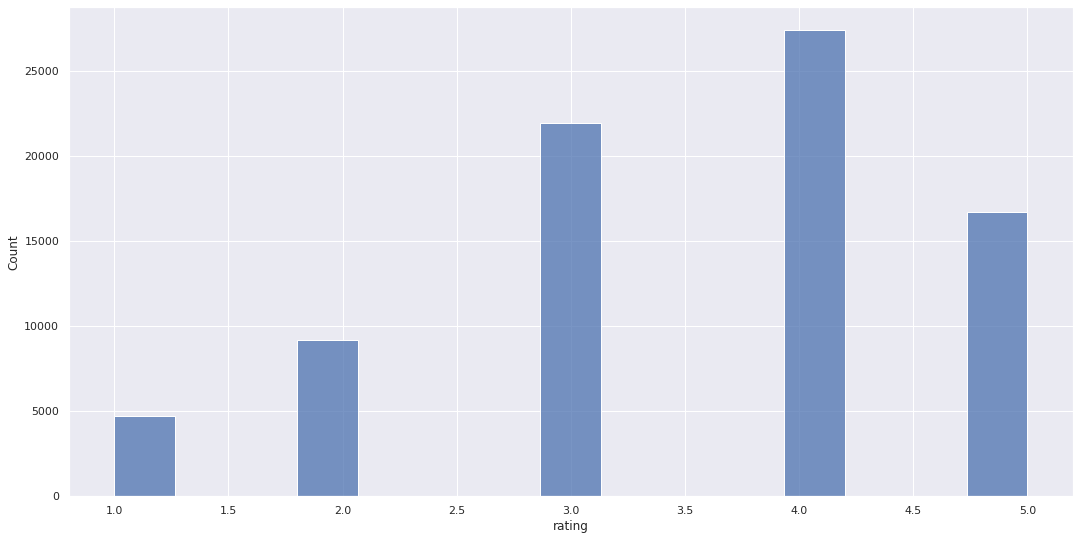

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 9)

sns.set_theme()
## histograms of rating
sns.histplot(data=train, x='rating', bins=15)
plt.show()

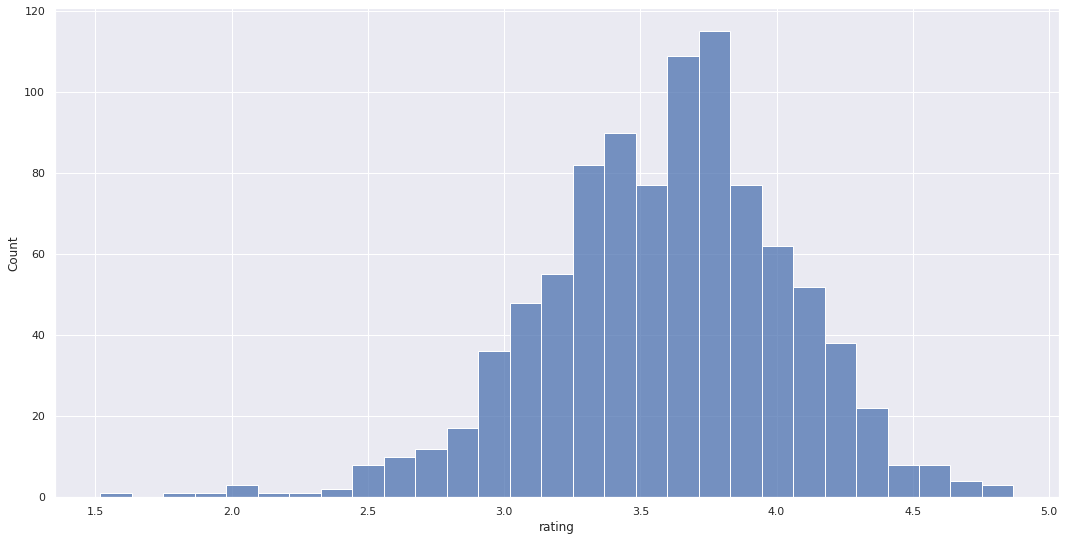

In [ ]:
## histograms of user mean: groupby
sns.histplot(train.groupby('user_id')['rating'].mean())
plt.show()

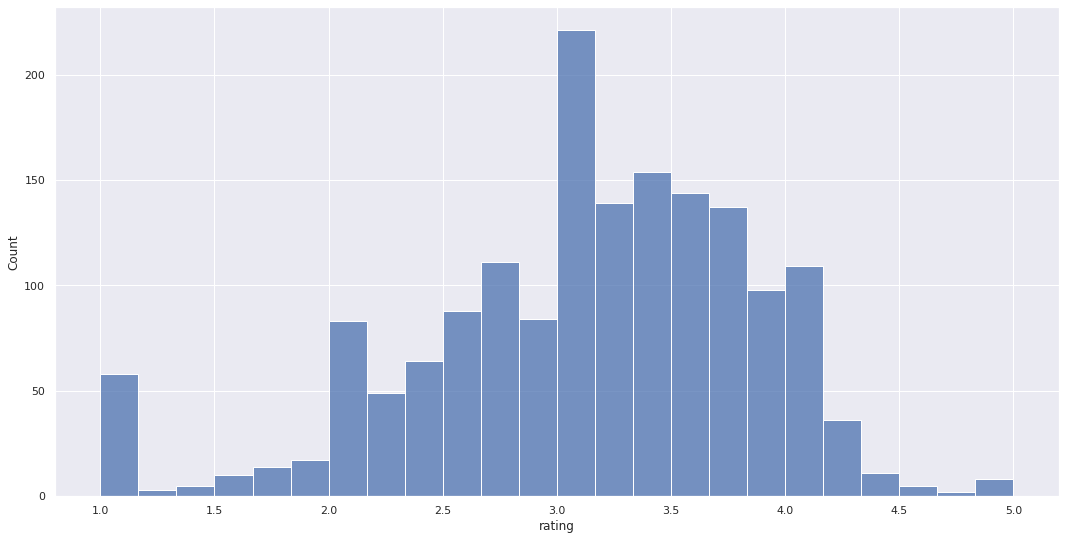

In [ ]:
## histograms of item mean using groupby
sns.histplot(train.groupby('item_id')['rating'].mean())
plt.show()

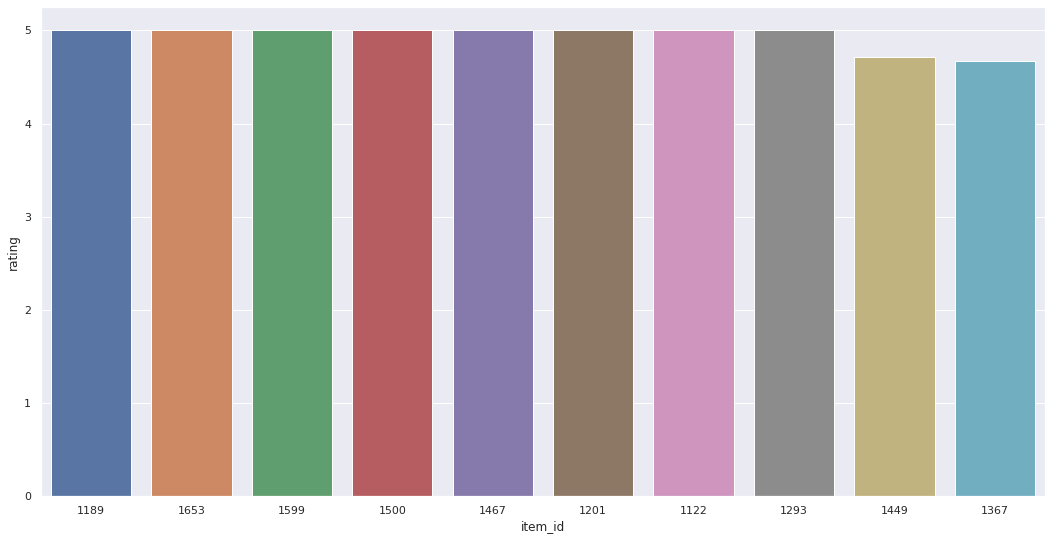

In [ ]:
## Find Top-10 highest rating movies -> barplot
di_hot = train.groupby('item_id')['rating'].mean().sort_values(ascending = False)[:10]
sns.barplot(x=di_hot.index, y=di_hot, order=di_hot.index)
plt.show()

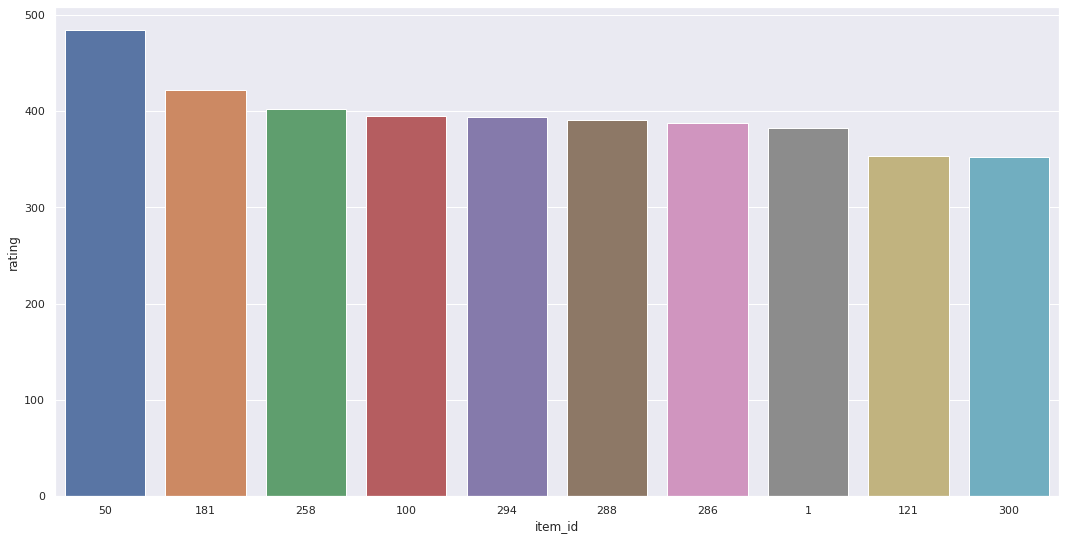

In [ ]:
## Find Top-10 most popular movies
di_pop = train.groupby('item_id')['rating'].count().sort_values(ascending = False)[:10]
sns.barplot(x=di_pop.index, y=di_pop, order=di_pop.index)
plt.show()

In [ ]:
n_user = len(set(train['user_id']).intersection(set(test['user_id'])))
du = {'user_id': [], 'count': [], 'mean': []}
for u in range(n_user):
  rating_tmp = train[train['user_id'] == u]
  if len(rating_tmp)>0:
    du['user_id'].append(u)
    du['count'].append(len(rating_tmp))
    du['mean'].append(np.mean(rating_tmp['rating']))
du = pd.DataFrame(du)

In [ ]:
du.sample(5)

,user_id,count,mean
447,448,35,3.371429
16,17,19,3.157895
70,71,22,3.818182
252,253,56,3.946429
243,244,117,3.709402


In [ ]:
n_item = len(set(train['item_id']).intersection(set(test['item_id'])))
di = {'item_id': [], 'count': [], 'mean': []}
for i in range(n_item):
  rating_tmp = train[train['item_id'] == i]
  if len(rating_tmp)>0:
    di['item_id'].append(i)
    di['count'].append(len(rating_tmp))
    di['mean'].append(np.mean(rating_tmp['rating']))
di = pd.DataFrame(di)

In [ ]:
di.sample(5)

,item_id,count,mean
1229,1238,7,3.285714
1116,1123,1,4.000000
213,214,87,3.344828
542,543,16,3.687500
139,140,49,3.285714


### Side information

### User side information EDA

In [ ]:
## cat table
!head -n 5 ./ml-100k/u.user

1|24|M|technician|85711
2|53|F|other|94043
3|23|M|writer|32067
4|24|M|technician|43537
5|33|F|other|15213


In [ ]:
n_cols = ['user_id', 'age', 'gender', 'occupation', 'zip code']
df_user = pd.read_csv('ml-100k/u.user', sep='|', names=n_cols , encoding='latin-1')

In [ ]:
df_user.sample(3).T

,465,634,527
user_id,466,635,528
age,22,22,18
gender,M,M,M
occupation,student,other,student
zip code,90804,23237,55104


In [ ]:
## Merge df
du_all = pd.merge(du, df_user, on='user_id', suffixes=('', ''))
du_all.sample(3).T

,121,220,306
user_id,122,221,307
count,34,83,54
mean,3.970588,3.614458,3.666667
age,32,19,25
gender,F,M,M
occupation,writer,student,student
zip code,22206,20685,55454


In [ ]:
# basic info()
du_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458 entries, 0 to 457
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     458 non-null    int64  
 1   count       458 non-null    int64  
 2   mean        458 non-null    float64
 3   age         458 non-null    int64  
 4   gender      458 non-null    object 
 5   occupation  458 non-null    object 
 6   zip code    458 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 28.6+ KB


In [ ]:
# unique
du_all.nunique()

user_id       458
count         171
mean          354
age            56
gender          2
occupation     21
zip code      415
dtype: int64

#### User Univariate effect

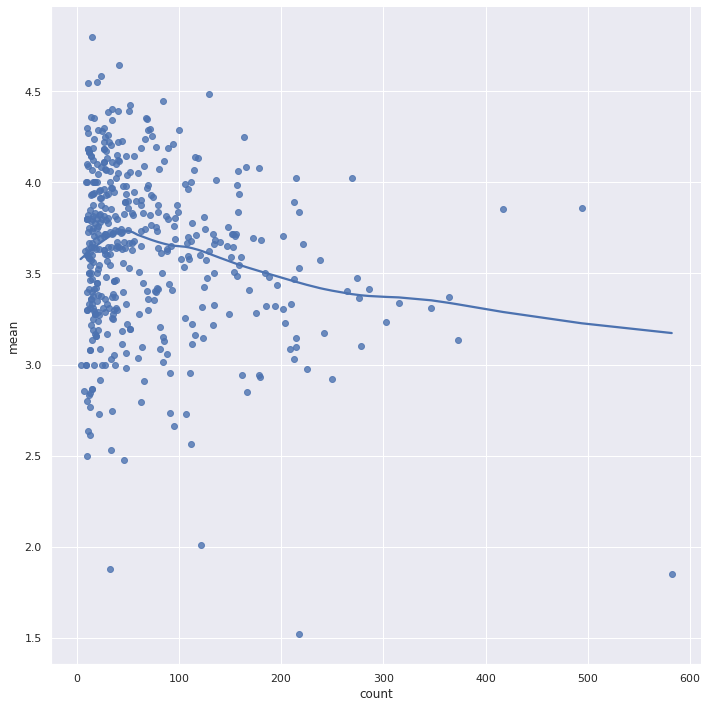

In [ ]:
## univariate
## count -> mean
sns.lmplot(data=du_all, x='count', y='mean', lowess=True, height=10)
plt.show()

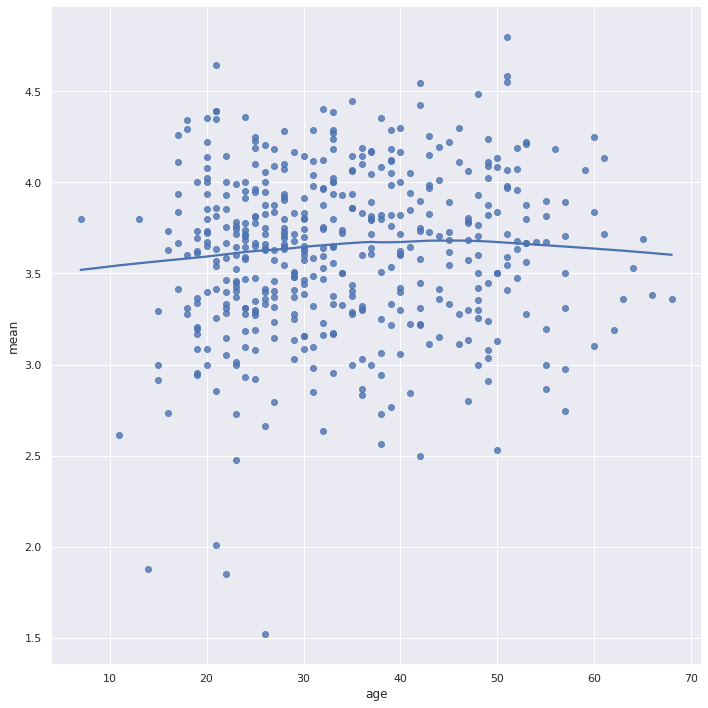

In [ ]:
# age -> mean: lowess=True
sns.lmplot(data=du_all, x='age', y='mean', lowess=True, height=10)
plt.show()

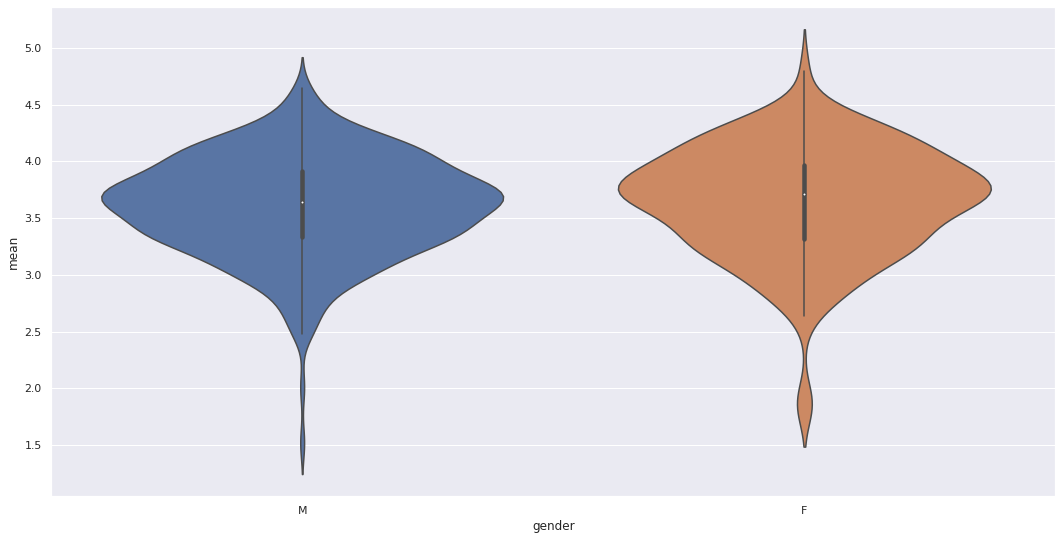

In [ ]:
# gender -> mean: violinplot
sns.violinplot(data=du_all, x='gender', y='mean')
plt.show()

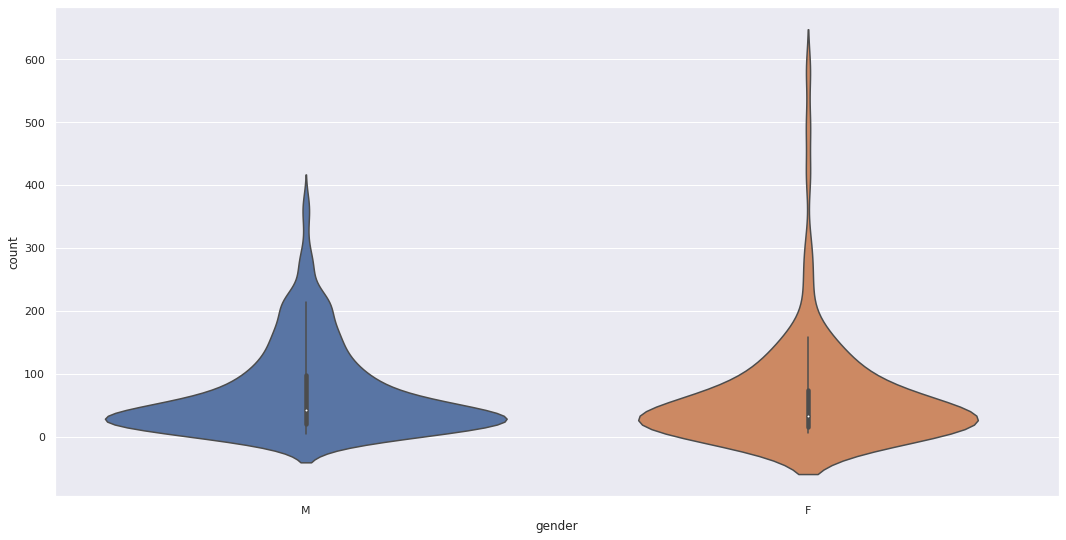

In [ ]:
sns.violinplot(data=du_all, x='gender', y='count')
plt.show()

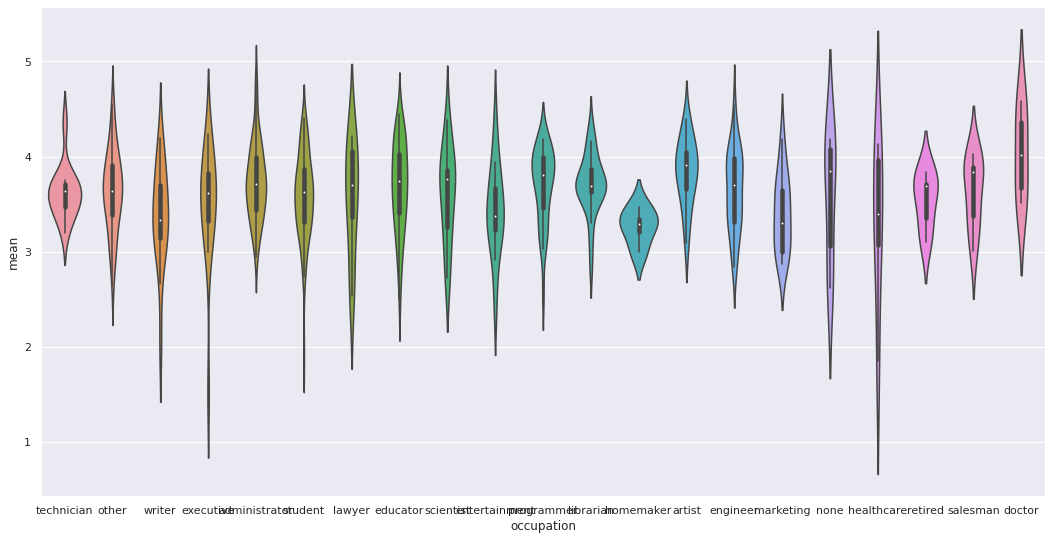

In [ ]:
# occupation -> mean
sns.violinplot(data=du_all, x='occupation', y='mean')
plt.show()

In [ ]:
zipcode_lst = du_all.groupby('zip code')['mean'].count()
popZ = zipcode_lst.index[zipcode_lst > 2]
popZ

Index(['20009', '22903', '55105', '55108', '55414', '60201', '80525', '94043'], dtype='object', name='zip code')

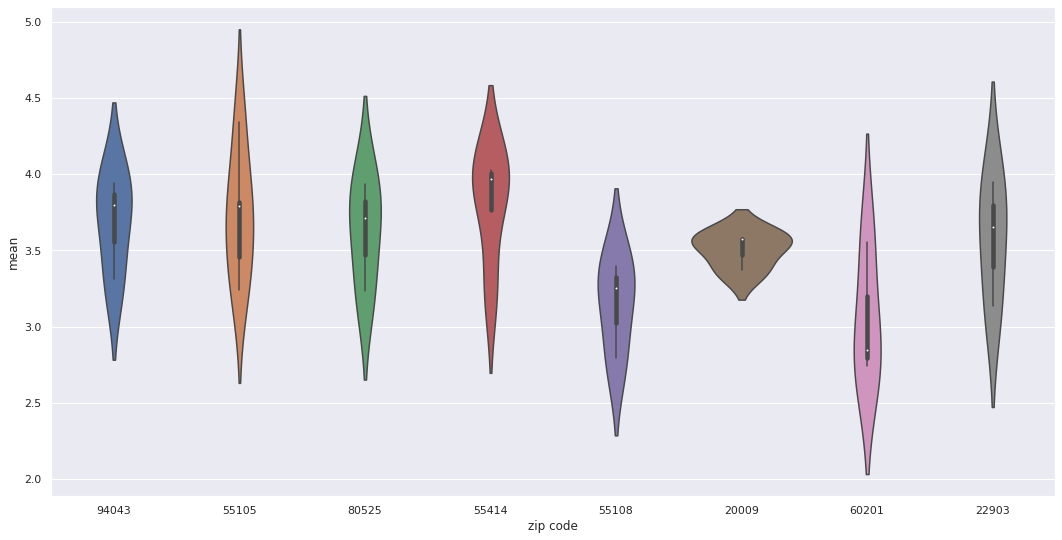

In [ ]:
## zipcode -> mean
sns.violinplot(data=du_all[np.isin(du_all['zip code'], popZ)], x='zip code', y='mean')
plt.show()

#### User Bivariate joint effect

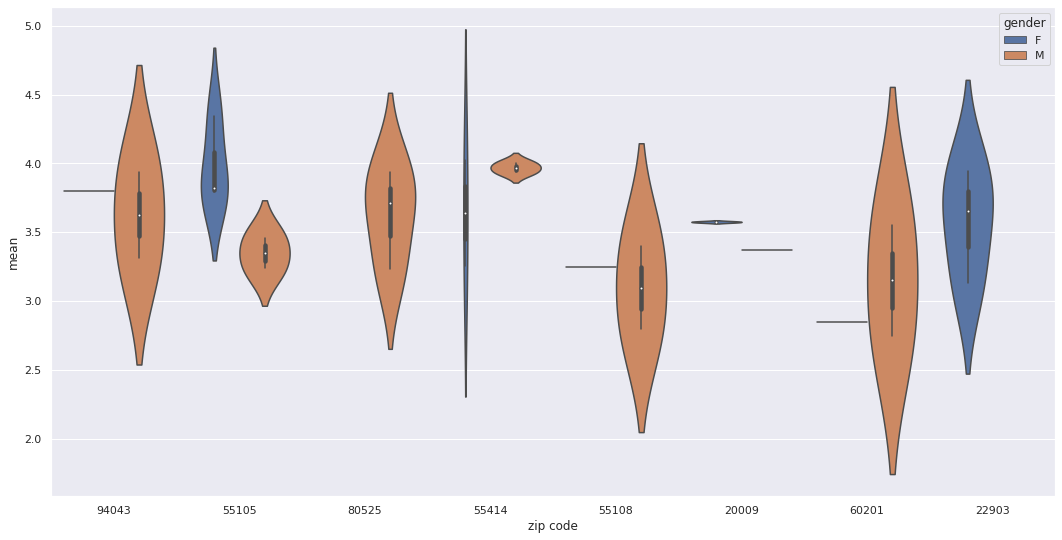

In [ ]:
## zipcode + gender -> mean
sns.violinplot(data=du_all[np.isin(du_all['zip code'], popZ)], x='zip code', hue='gender', y='mean')
plt.show()

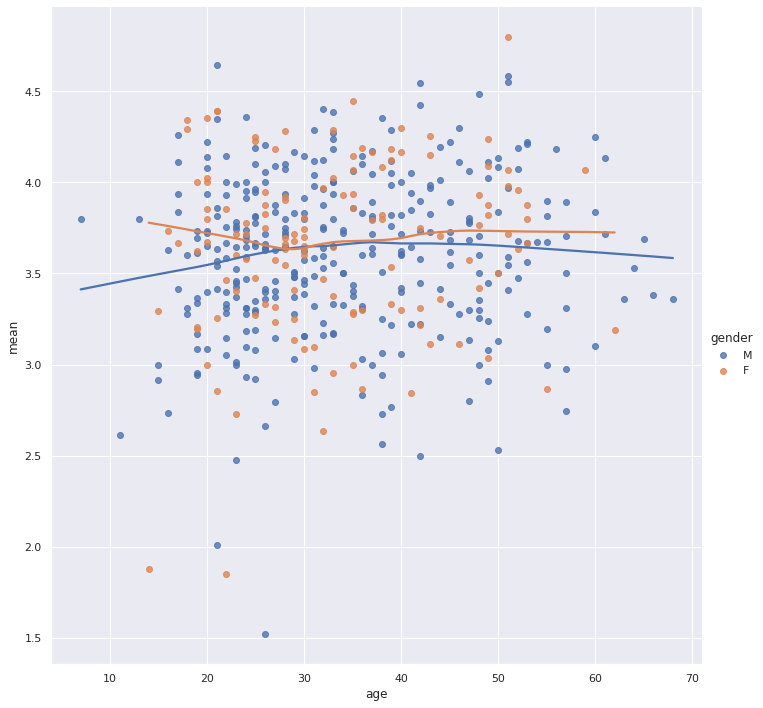

In [ ]:
## age + gender -> mean
sns.lmplot(data=du_all, x='age', y='mean', hue='gender', lowess=True, height=10)

### Item side information EDA

In [ ]:
!head -n 5 ml-100k/u.item

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0


In [ ]:
m_cols = ['item_id','title','date','video_date', 'URL',
          'unknown', 'Action', 'Adventure', 'Animation',
          'Children', 'Comedy', 'Crime', 'Documentary',
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
          'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
          'Western']
df_item = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols , encoding='latin-1')

In [ ]:
df_item.sample(3).T

,1625,1213,1650
item_id,1626,1214,1651
title,Nobody Loves Me (Keiner liebt mich) (1994),In the Realm of the Senses (Ai no corrida) (1976),"Spanish Prisoner, The (1997)"
date,09-Feb-1996,08-Mar-1976,27-Mar-1998
video_date,NaN,NaN,NaN
URL,http://us.imdb.com/M/title-exact?Keiner%20lieb...,http://us.imdb.com/M/title-exact?Ai%20no%20Cor...,"http://us.imdb.com/Title?Spanish+Prisoner,+The..."
unknown,0,0,0
Action,0,0,0
Adventure,0,0,0
Animation,0,0,0
Children,0,0,0


In [ ]:
di_all = pd.merge(di, df_item, on='item_id', suffixes=("", ""))
di_all.sample(3).T

,1083,1075,562
item_id,1090,1082,563
count,29,5,24
mean,2.517241,2.6,2.458333
title,Sliver (1993),Female Perversions (1996),Stephen King's The Langoliers (1995)
date,01-Jan-1993,25-Apr-1997,01-Jan-1995
video_date,NaN,NaN,NaN
URL,http://us.imdb.com/M/title-exact?Sliver%20(1993),http://us.imdb.com/M/title-exact?Female%20Perv...,http://us.imdb.com/M/title-exact?%22Langoliers...
unknown,0,0,0
Action,0,0,0
Adventure,0,0,0


In [ ]:
## remove NaN
del di_all['video_date']
## remove URL, might be useful, but we do not use it in the STAT3009
del di_all['URL']

In [ ]:
## Generate year and month
di_all['year'] = pd.DatetimeIndex(di_all['date']).year
di_all['month'] = pd.DatetimeIndex(di_all['date']).month

In [ ]:
di_all.sample(3).T

,1195,144,244
item_id,1203,145,245
count,18,52,193
mean,3.888889,2.519231,3.15544
title,Top Hat (1935),"Lawnmower Man, The (1992)","Devil's Own, The (1997)"
date,01-Jan-1935,01-Jan-1992,26-Mar-1997
unknown,0,0,0
Action,0,1,1
Adventure,0,0,0
Animation,0,0,0
Children,0,0,0


#### Item univariate effect

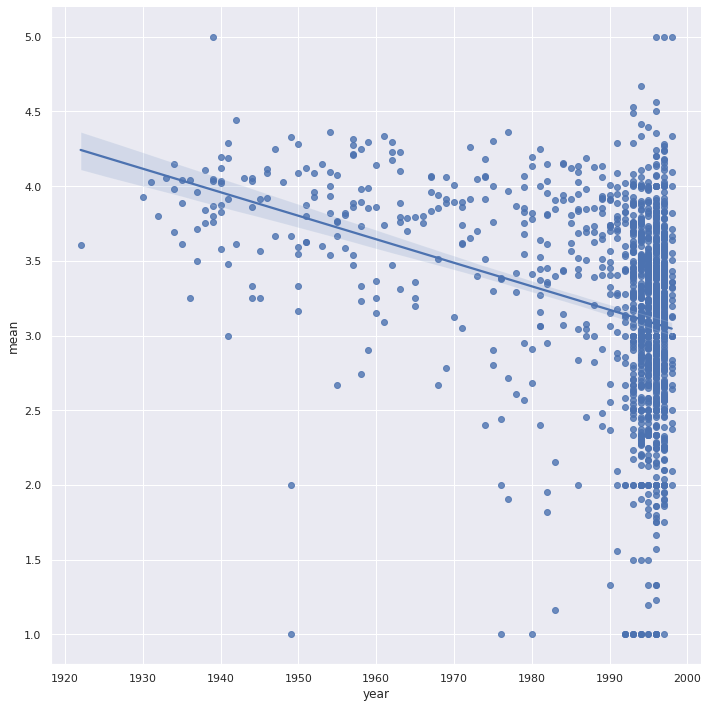

In [ ]:
# year -> mean
sns.lmplot(data=di_all, x='year', y='mean', height=10)

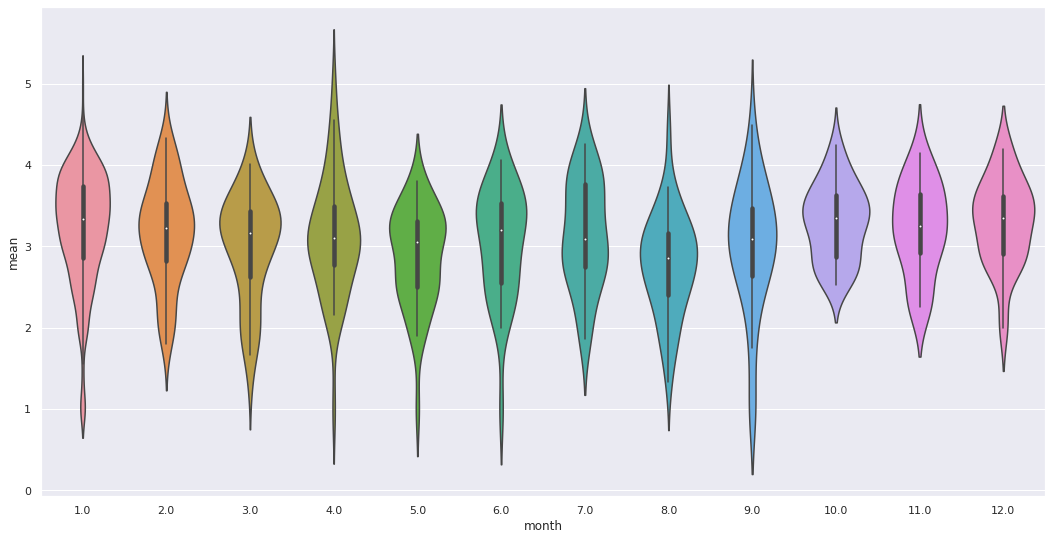

In [ ]:
# month -> mean
sns.violinplot(data=di_all, x='month', y='mean')

In [ ]:
# gene -> mean
m_cols[5:]

['unknown',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [ ]:
## from dummy to label
di_all['gene'] = di_all[m_cols[5:]].idxmax(axis=1)
di_all.sample(3).T

,1043,1064,850
item_id,1050,1071,856
count,36,11,28
mean,3.666667,2.818182,3.714286
title,"Ghost and Mrs. Muir, The (1947)",Party Girl (1995),Night on Earth (1991)
date,01-Jan-1947,01-Jan-1995,01-Jan-1991
unknown,0,0,0
Action,0,0,0
Adventure,0,0,0
Animation,0,0,0
Children,0,0,0


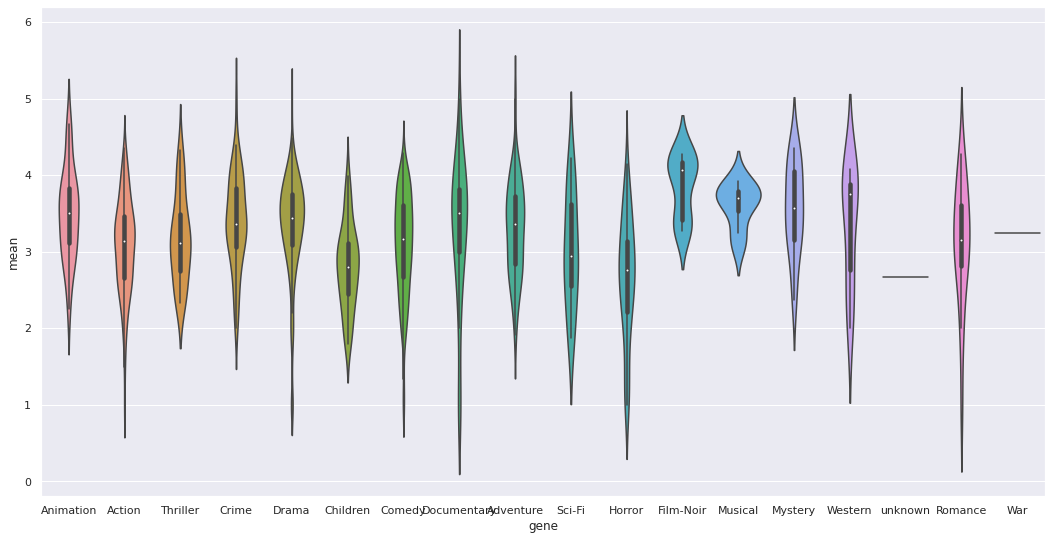

In [ ]:
## violinplot
sns.violinplot(data=di_all, x='gene', y='mean')
plt.show()

#### Item Bivariate joint effect


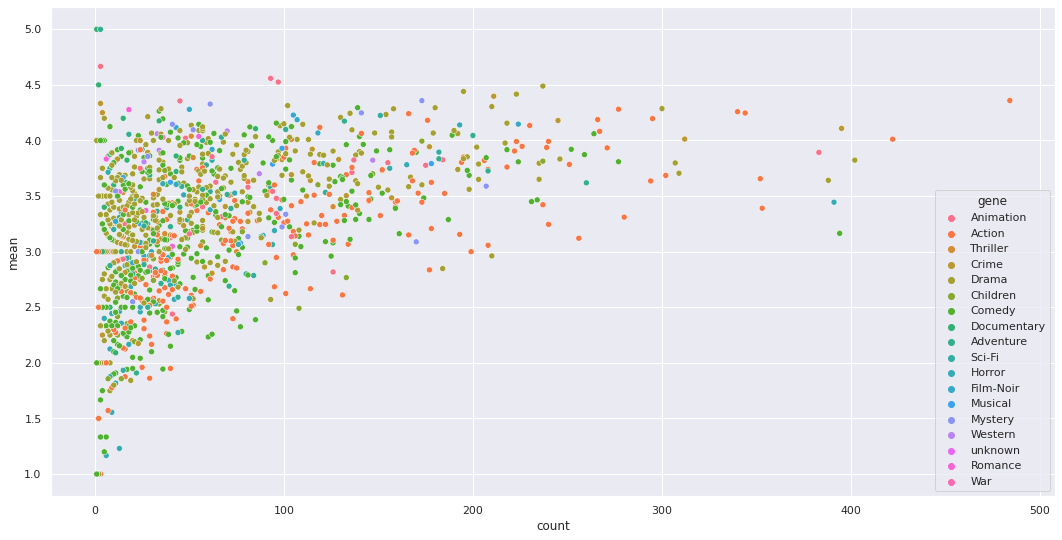

In [ ]:
## count + gene -> mean
sns.scatterplot(data=di_all, x='count', y='mean', hue='gene')
plt.show()

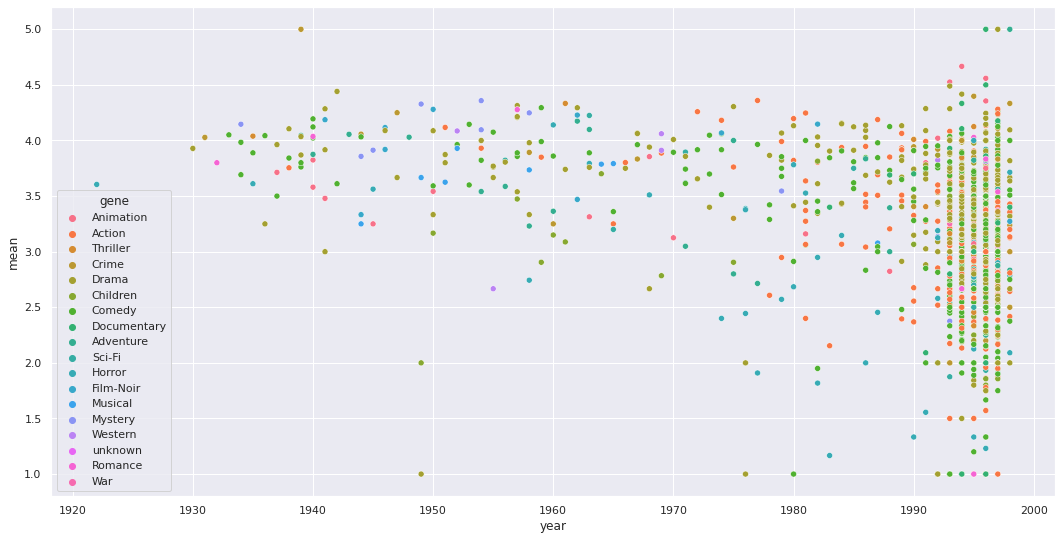

In [ ]:
## year + gene -> mean: scatterplot
sns.scatterplot(data=di_all, x='year', y='mean', hue='gene')
plt.show()

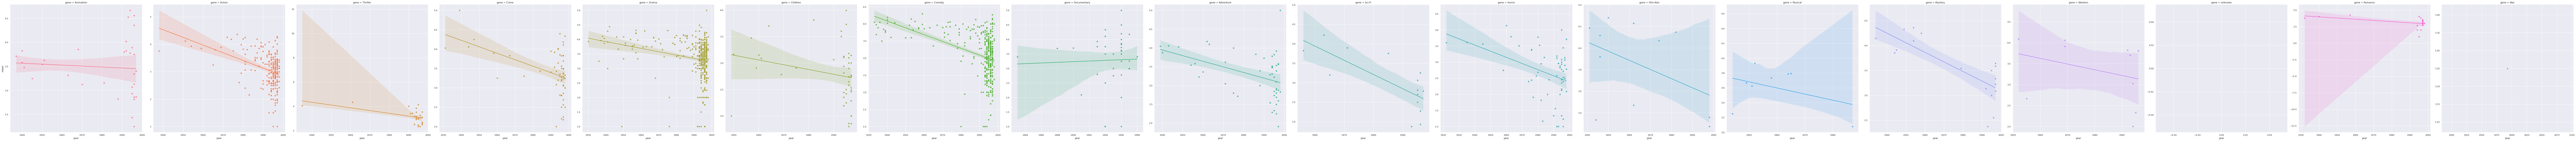

In [ ]:
## year + gene -> mean: lmplot col option
sns.lmplot(data=di_all, x='year', y='mean', col='gene', hue='gene', height=10,
           facet_kws=dict(sharex=False, sharey=False))

In [ ]:
## month + gene -> mean: relplot with col + kind options


## Conclusion

- Both **side informtion** for *users*/*items* are important
- The **joint effect** from features is significant to rating prediction

## **Personalization**: do we still need **MF** term?

In [ ]:
du_all.sort_values(by=['count'], ascending=False)

,user_id,count,mean,age,gender,occupation,zip code
404,405,582,1.848797,22,F,healthcare,10019
449,450,494,3.858300,35,F,educator,11758
415,416,417,3.851319,20,F,student,92626
12,13,373,3.136729,47,M,educator,29206
428,429,364,3.370879,27,M,student,29205
...,...,...,...,...,...,...,...
92,93,9,3.000000,48,M,executive,23112
35,36,9,4.000000,19,F,student,93117
257,258,8,3.625000,19,F,student,77801
227,228,7,2.857143,21,F,student,22003


We going to look at the records:

|user_id|count|mean|age|gender|occupation|zip code|
|--- |--- |	--- |	--- |	--- |	--- |---|
|450 |494|3.858300 | 35 | F |	educator |11758|
|330 |85 |4.447059 | 35 |	F |	educator |33884|


In [ ]:
dp = train[(train['user_id'] == 450) | (train['user_id'] == 330)]
dp

,user_id,item_id,rating,timestamp
19580,330,1,5,876544432
19581,330,15,5,876544366
19582,330,21,5,876544953
19583,330,25,5,876544582
19584,330,28,5,876546526
...,...,...,...,...
30783,450,1480,3,882468686
30784,450,1490,3,882396929
30785,450,1518,4,887138957
30786,450,1521,3,882812350


In [ ]:
dp = pd.merge(dp, di_all[['item_id', 'year', 'date', 'gene', 'month']], on='item_id')

In [ ]:
dp.sample(5)

,user_id,item_id,rating,timestamp,year,date,gene,month
357,450,489,4,882373464,1946.0,01-Jan-1946,Film-Noir,1.0
130,450,732,3,882395662,1993.0,01-Jan-1993,Comedy,1.0
19,330,91,4,876547426,1993.0,01-Jan-1993,Children,1.0
217,450,169,5,882371732,1993.0,01-Jan-1993,Animation,1.0
81,450,318,5,882373531,1993.0,01-Jan-1993,Drama,1.0


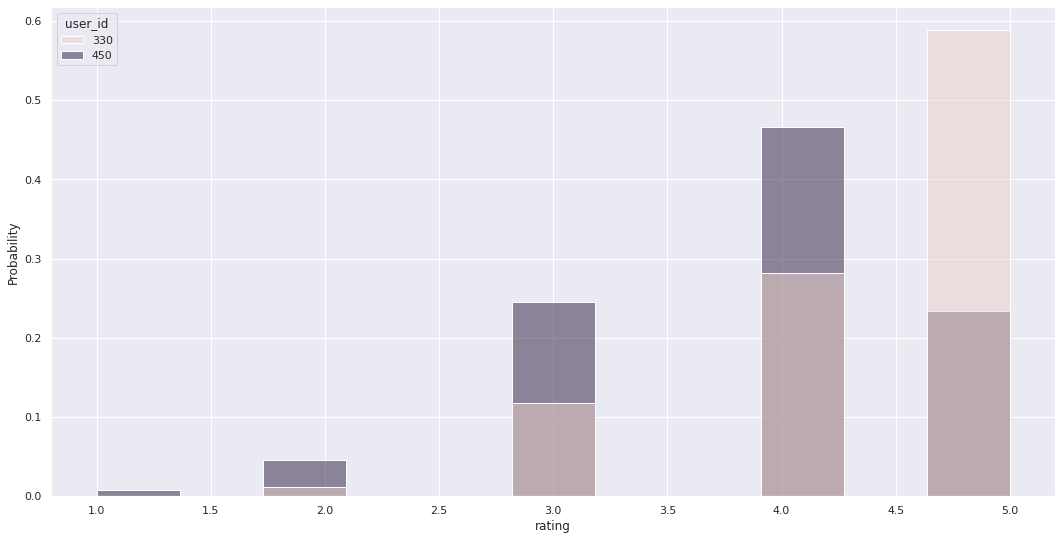

In [ ]:
## overall histplot
sns.histplot(data=dp, x='rating', hue='user_id', stat='probability', common_norm=False)

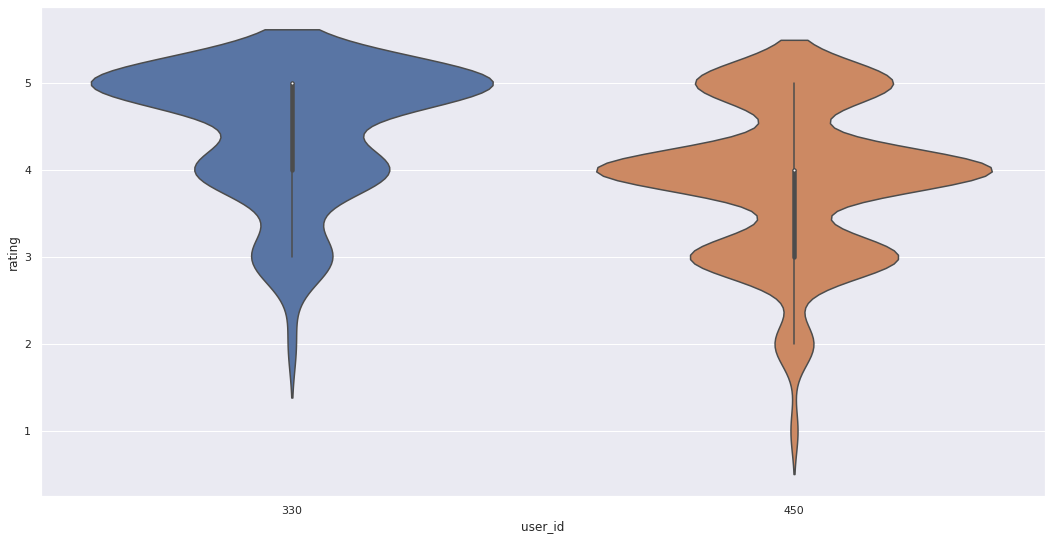

In [ ]:
## overall violinplot
sns.violinplot(data=dp, x="user_id", y="rating")

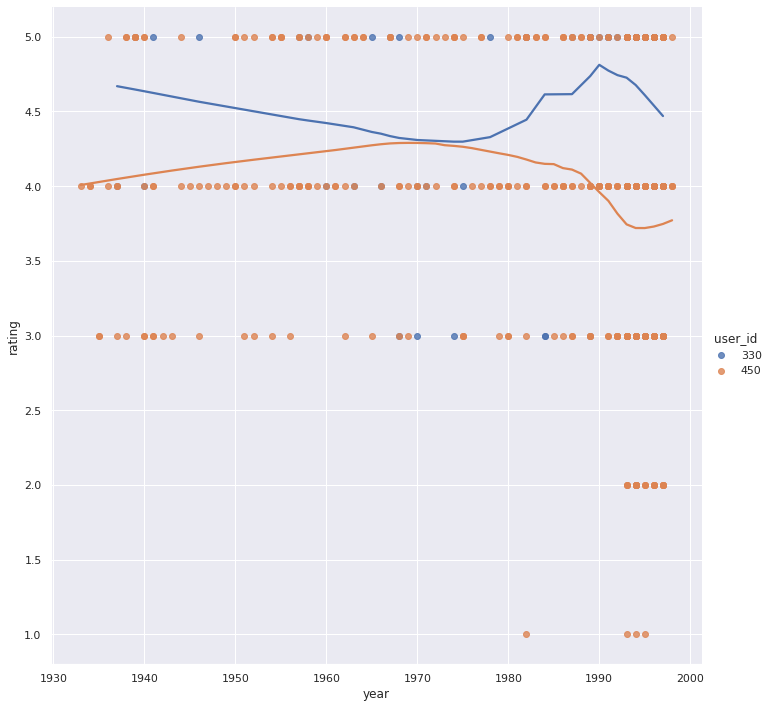

In [ ]:
## year -> rating: lmplot
sns.lmplot(data=dp, x='year', y='rating', hue='user_id', lowess=True, height=10)

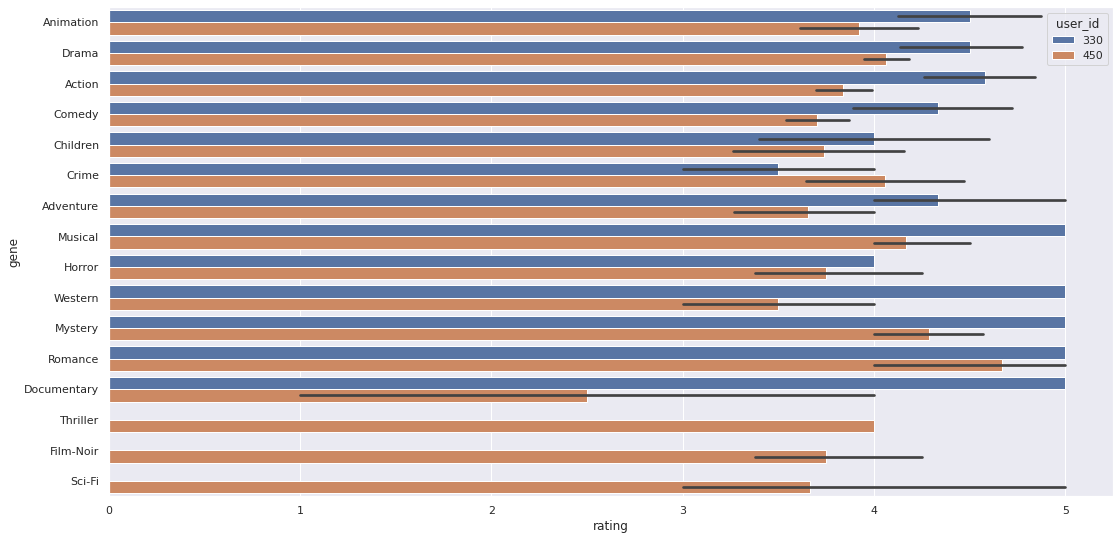

In [ ]:
## gene -> rating: barplot
sns.barplot(data=dp, x='rating', y='gene', hue='user_id')

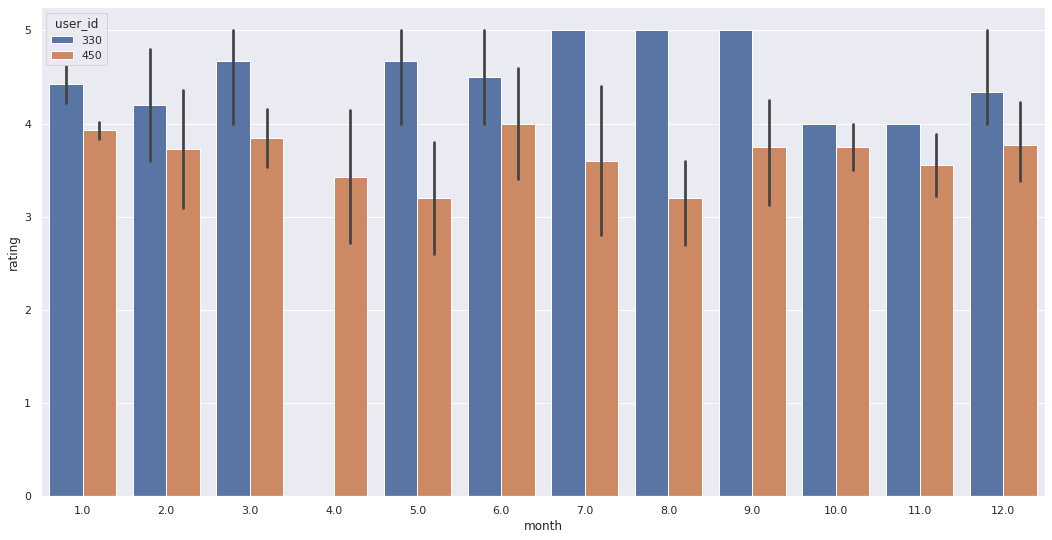

In [ ]:
## month -> rating: barplot
sns.barplot(data=dp, x='month', y='rating', hue='user_id')

## Conclusion
- **Personalization** is still important
- **Joint effecct** from (`user_id`, `gene`), (`user_id`, `year`), ... should be taken into account in the model.

## Method

### Pre-processing

- The ML-100K use `user id` and `item id` starting from 1, we should redefine the IDs starting from 0
- The simplest way is to minus all IDs by 1, but more generally we use `sklearn.preprocessing.LabelEncoder`

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
## example
le.fit([1, 2, 2, 6])
le.transform([1,2,6])

array([0, 1, 2])

In [ ]:
## Label encoding for users/items


In [ ]:
print('Total number of users: %d' %len(set(train['user_id'].append(test['user_id']))))
print('Max Id of users: %d' %max(set(train['user_id'].append(test['user_id']))))

Total number of users: 943
Max Id of users: 942


In [ ]:
print('Total number of items: %d' %len(set(train['item_id'].append(test['item_id']))))
print('Max Id of items: %d' %max(set(train['item_id'].append(test['item_id']))))

Total number of items: 1682
Max Id of items: 1681


In [ ]:
del train['timestamp']
train.sample(5)

,user_id,item_id,rating
70300,851,288,2
59387,732,321,2
67429,824,242,4
613,6,648,5
1593,17,715,5


In [ ]:
del test['timestamp']
test.sample(5)

,user_id,item_id,rating
8701,193,1219,3
12713,275,549,4
587,7,300,4
15872,320,1027,2
7071,155,47,4


In [ ]:
## stadard data type
train_pair = train[['user_id', 'item_id']].values
train_rating = train['rating'].values

test_pair = test[['user_id', 'item_id']].values
test_rating = test['rating'].values
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

In [ ]:
## Baseline
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred_glb = glb_ave.predict(test_pair)
print('RSME for gbl mean: %.3f' %rmse(test_rating, pred_glb))

RSME for gbl mean: 1.154


In [ ]:
# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
pred_user_mean = pred_glb + user_ave.predict(test_pair)
print('RSME for user-mean: %.3f' %rmse(test_rating, pred_user_mean))

RSME for user-mean: 1.063


In [ ]:
## item mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
pred_item_mean = pred_glb + item_ave.predict(test_pair)
print('RSME for item-mean: %.3f' %rmse(test_rating, pred_item_mean))

RSME for item-mean: 1.033


3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.845, valid_rmse: 0.945
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.843, valid_rmse: 0.950
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.844, valid_rmse: 0.950
3-Fold CV for K: 2; lam: 0.00002: train_rmse: 0.847, valid_rmse: 0.941
3-Fold CV for K: 2; lam: 0.00002: train_rmse: 0.849, valid_rmse: 0.935
3-Fold CV for K: 2; lam: 0.00002: train_rmse: 0.844, valid_rmse: 0.949
3-Fold CV for K: 2; lam: 0.00004: train_rmse: 0.850, valid_rmse: 0.941
3-Fold CV for K: 2; lam: 0.00004: train_rmse: 0.854, valid_rmse: 0.935
3-Fold CV for K: 2; lam: 0.00004: train_rmse: 0.856, valid_rmse: 0.929
3-Fold CV for K: 2; lam: 0.00008: train_rmse: 0.868, valid_rmse: 0.924
3-Fold CV for K: 2; lam: 0.00008: train_rmse: 0.865, valid_rmse: 0.932
3-Fold CV for K: 2; lam: 0.00008: train_rmse: 0.861, valid_rmse: 0.940
3-Fold CV for K: 2; lam: 0.00016: train_rmse: 0.890, valid_rmse: 0.930
3-Fold CV for K: 2; lam: 0.00016: train_rmse: 0.886, valid_rmse: 0.939
3-Fold

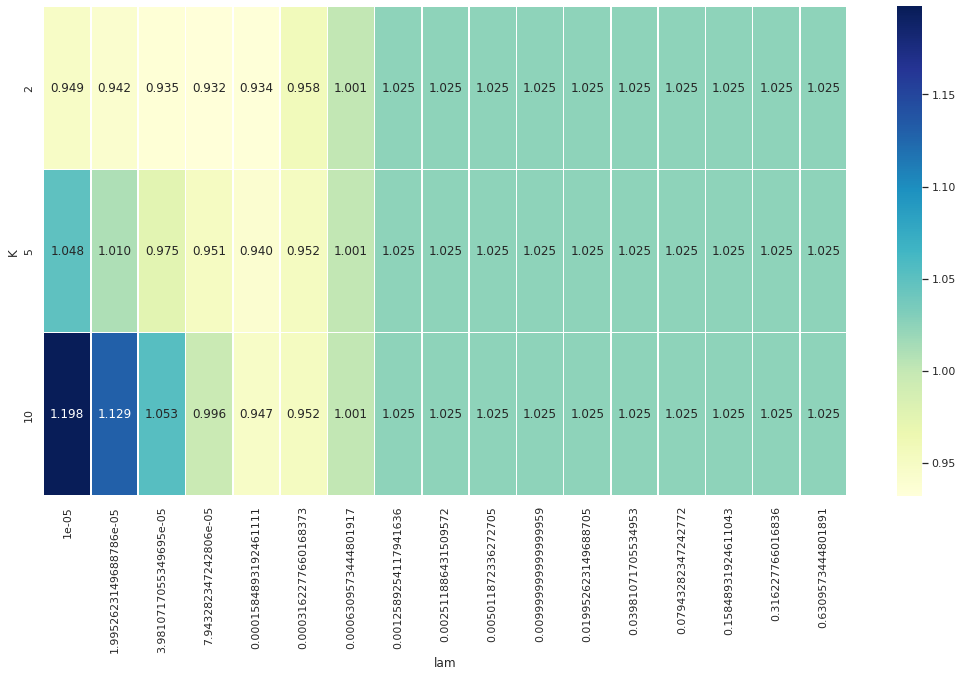

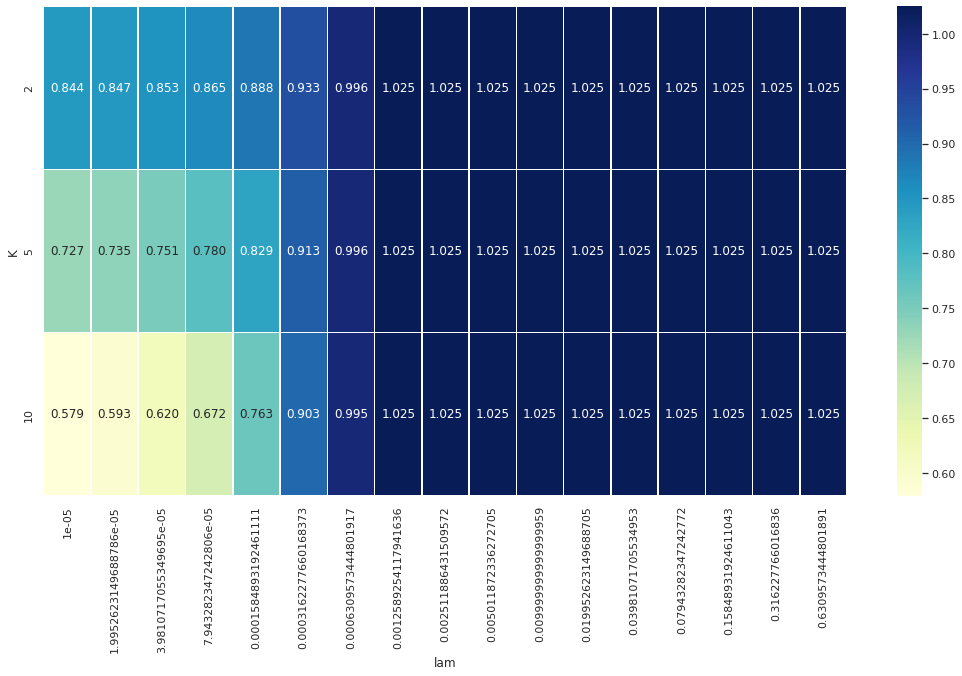

In [ ]:
# fit user_mean + MF_CV by residual ratings
train_rating_res = train_rating_cm - user_ave.predict(train_pair)

Ks, lams = [2, 5, 10], 10**np.arange(-5, 0., .3)
ML_MF_cv = MF_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
ML_MF_cv.grid_search(train_pair, train_rating_res)
ML_MF_cv.plot_grid('valid')
ML_MF_cv.plot_grid('train')

In [ ]:
print(ML_MF_cv.best_model)
best_K, best_lam = ML_MF_cv.best_model['K'], ML_MF_cv.best_model['lam']

K             2.000000
lam           0.000079
train_rmse    0.864738
valid_rmse    0.932019
Name: 3, dtype: float64


In [ ]:
best_MF = MF(n_user, n_item, K=int(best_K), lam=best_lam)
best_MF.fit(train_pair, train_rating_res)

Fitting Reg-MF: K: 2, lam: 0.00008
Reg-MF: ite: 0; diff: 0.700 Obj: 1.032
Reg-MF: ite: 1; diff: 0.135 Obj: 0.893
Reg-MF: ite: 2; diff: 0.030 Obj: 0.867
Reg-MF: ite: 3; diff: 0.011 Obj: 0.857
Reg-MF: ite: 4; diff: 0.005 Obj: 0.853
Reg-MF: ite: 5; diff: 0.003 Obj: 0.851
Reg-MF: ite: 6; diff: 0.001 Obj: 0.850
Reg-MF: ite: 7; diff: 0.000 Obj: 0.849
Reg-MF: ite: 8; diff: 0.000 Obj: 0.849
Reg-MF: ite: 9; diff: 0.000 Obj: 0.849


In [ ]:
pred_MF = pred_user_mean + best_MF.predict(test_pair)
print('RMSE for user_mean + MF: %.3f' %rmse(test_rating, pred_MF))

RMSE for user_mean + MF: 0.949


### Model dicsussion

- Incorproate **side information**
- Other than the joint effect from (`user_id`,`item_id`), we need to consider joint effects from (items' side info <-> users' side info), (`user_id` <-> items' side info) and (`item_id` <-> users' side info)

# Neural Networks




## Introduction to Deep learning with Keras

- `Model`: input -> layers -> output
- `Loss`: find an appropriate loss function for your problem
- `Algo`: SGD, Adam, ...
- `Data`: Define the model, then feed the data
- `metric`: final evaluation or something you care



## Example: Imbalanced classification: credit card fraud detection

Adapted from:
- Author: fchollet
- Date created: 2019/05/28
- Last modified: 2020/04/17
- Description: Demonstration of how to handle highly imbalanced classification problems.

In [ ]:
!wget https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv

--2022-11-03 05:35:54--  https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102634230 (98M) [text/plain]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>]  97.88M   173MB/s    in 0.6s    

2022-11-03 05:36:02 (173 MB/s) - ‘creditcard.csv’ saved [102634230/102634230]



In [ ]:
!head -n 5 creditcard.csv

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807134,-0.072781173,2.536346738,1.378155224,-0.33832077,0.462387778,0.239598554,0.098697901,0.36378697,0.090794172,-0.551599533,-0.617800856,-0.991389847,-0.311169354,1.468176972,-0.470400525,0.207971242,0.02579058,0.40399296,0.251412098,-0.018306778,0.277837576,-0.11047391,0.066928075,0.128539358,-0.189114844,0.133558377,-0.021053053,149.62,0
0,1.191857111,0.266150712,0.166480113,0.448154078,0.060017649,-0.082360809,-0.078802983,0.085101655,-0.255425128,-0.166974414,1.612726661,1.065235311,0.489095016,-0.143772296,0.635558093,0.463917041,-0.114804663,-0.18336127,-0.145783041,-0.069083135,-0.225775248,-0.638671953,0.101288021,-0.339846476,0.167170404,0.125894532,-0.008983099,0.014724169,2.69,0
1,-1.358354062,-1.340163075,1.773209343,0.379779593,-0.503198133,1.800499381,0.791460956,0.247675787,-1.514654323,0.207642865,0.624501459,0.066083685,0.717292731,-0.165

In [ ]:
# https://keras.io/examples/structured_data/imbalanced_classification/

import csv
import numpy as np
import pandas as pd

fname = "./creditcard.csv"

df = pd.read_csv(fname)

targets = np.array(df['Class'], dtype="uint8")
df.drop(['Class', 'Amount', 'Time'], axis=1)
features = np.array(df.values, dtype="float32")
print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

features.shape: (284807, 31)
targets.shape: (284807,)


In [ ]:
df.sample(3).T

,67001,205706,42213
Time,52321.000000,135876.000000,40999.000000
V1,0.445912,-0.033097,1.144381
V2,-1.561890,1.010923,0.462180
V3,0.703760,-1.456802,0.896351
V4,0.499253,-0.368694,2.739373
V5,-1.337210,0.887812,-0.257581
V6,0.230322,-1.120082,-0.114159
V7,-0.200763,0.845973,0.029601
V8,0.068205,0.161031,-0.076993
V9,1.084253,-0.350342,-0.371443


In [ ]:
## create train and valid datasets

num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
test_features = features[-num_val_samples:]
test_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of testing samples:", len(test_features))

Number of training samples: 227846
Number of testing samples: 56961


In [ ]:
## Data pre-processing
mean = np.mean(train_features, axis=0)
train_features -= mean
test_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
test_features /= std

## How to implement a neural network `tf.keras.Model`?

- Define a network: input -> Layers -> output
- compile a network: `model.compile`
- fit a network: `model.fit`

### Define a neural network by `tf.keras.Model`

> `tf.keras.Model(*args, **kwargs)`

**Args**
- inputs:	The input(s) of the model: a keras.Input object or list of keras.Input objects.

- outputs: The output(s) of the model. See Functional API example below.
name 	String, the name of the model.

- Layers: use different types of layers to construct your own networks

The key point is how to connect from `inputs` to `outputs`

In [ ]:
## Build binary classifcation model

## Input -> Dense(256) -> Dense(256) -> output(Prob)
from tensorflow import keras
model = keras.Sequential(
    [
    keras.layers.Dense(128, activation='relu', input_shape=(train_features.shape[1],) ),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
    ]
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               4096      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,465
Trainable params: 14,465
Non-trainable params: 0
_________________________________________________________________


### Explore `model.compile` function in `tf.keras`
```python
    compile(
        optimizer='rmsprop',
        loss=None,
        metrics=None,
        loss_weights=None,
        weighted_metrics=None,
        run_eagerly=None,
        steps_per_execution=None,
        jit_compile=None,
        **kwargs
    )
```
- Key args: `optimizer`, `loss`, `metrics`
- Ref:[
A Comprehensive Guide on Deep Learning Optimizers
](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/)
- IMPORTANT! Pair your loss function and the outcome of your network (activation function in the last layer)

In [ ]:
## compile model
opt = keras.optimizers.SGD(learning_rate=1e-1)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()])

### Explore `model.fit` function in `keras`
```python
    fit(
        x=None,
        y=None,
        batch_size=None,
        epochs=1,
        verbose='auto',
        callbacks=None,
        validation_split=0.0,
        validation_data=None,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
        validation_batch_size=None,
        validation_freq=1,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False
    )
```
Check [**Args**](https://www.tensorflow.org/api_docs/python/tf/keras/Model):

- key args: `x`, `y`, `epochs`, `batch_size`, `verbose`, `callbacks`, `validation_split`, `validation_data`



In [ ]:
model.fit(
    x = train_features,
    y = train_targets,
    epochs=10,
    batch_size=2048,
    verbose=2,
)

Epoch 1/10
112/112 - 2s - loss: 0.2427 - binary_accuracy: 0.9982 - auc: 0.0250 - 2s/epoch - 15ms/step
Epoch 2/10
112/112 - 2s - loss: 0.2059 - binary_accuracy: 0.9982 - auc: 0.0246 - 2s/epoch - 15ms/step
Epoch 3/10
112/112 - 2s - loss: 0.1753 - binary_accuracy: 0.9982 - auc: 0.0252 - 2s/epoch - 15ms/step
Epoch 4/10
112/112 - 1s - loss: 0.1500 - binary_accuracy: 0.9982 - auc: 0.0272 - 1s/epoch - 12ms/step
Epoch 5/10
112/112 - 1s - loss: 0.1291 - binary_accuracy: 0.9982 - auc: 0.0290 - 1s/epoch - 9ms/step
Epoch 6/10
112/112 - 1s - loss: 0.1118 - binary_accuracy: 0.9982 - auc: 0.0357 - 1s/epoch - 9ms/step
Epoch 7/10
112/112 - 1s - loss: 0.0974 - binary_accuracy: 0.9982 - auc: 0.0462 - 1s/epoch - 10ms/step
Epoch 8/10
112/112 - 1s - loss: 0.0853 - binary_accuracy: 0.9982 - auc: 0.0657 - 1s/epoch - 9ms/step
Epoch 9/10
112/112 - 1s - loss: 0.0751 - binary_accuracy: 0.9982 - auc: 0.0994 - 1s/epoch - 9ms/step
Epoch 10/10
112/112 - 1s - loss: 0.0664 - binary_accuracy: 0.9982 - auc: 0.1527 - 1s/e

In [ ]:
test_prob = model.predict(test_features)

1781/1781 [==============================] - 3s 2ms/step


In [ ]:
pred_targets = np.round(test_prob)

In [ ]:
pred_targets

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
test_targets

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
model.evaluate(test_features, test_targets)

1781/1781 [==============================] - 4s 2ms/step - loss: 0.0608 - binary_accuracy: 0.9987 - auc: 0.2557


[0.06080695241689682, 0.9986833333969116, 0.2557182312011719]

### Early-stopping in neural networks

- Define `callback` with `EarlyStopping` in `model.fit`
- Use `validation_data` or `validation_split` in `model.fit`

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=0,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False)


In [ ]:
## callback
callback = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          min_delta=1e-3,
                                          mode="auto",
                                          restore_best_weights=True)]

model.fit(
    x = train_features,
    y = train_targets,
    epochs=50,
    batch_size=2048,
    verbose=2,
    validation_split=.2,
    callbacks = callback,
)

Epoch 1/50
90/90 - 2s - loss: 3.3684e-09 - binary_accuracy: 1.0000 - auc_3: 1.0000 - val_loss: 5.5192e-09 - val_binary_accuracy: 1.0000 - val_auc_3: 1.0000 - 2s/epoch - 24ms/step
Epoch 2/50
90/90 - 2s - loss: 3.3684e-09 - binary_accuracy: 1.0000 - auc_3: 1.0000 - val_loss: 5.5192e-09 - val_binary_accuracy: 1.0000 - val_auc_3: 1.0000 - 2s/epoch - 18ms/step
Epoch 3/50
90/90 - 1s - loss: 3.3684e-09 - binary_accuracy: 1.0000 - auc_3: 1.0000 - val_loss: 5.5192e-09 - val_binary_accuracy: 1.0000 - val_auc_3: 1.0000 - 1s/epoch - 15ms/step
Epoch 4/50
90/90 - 1s - loss: 3.3684e-09 - binary_accuracy: 1.0000 - auc_3: 1.0000 - val_loss: 5.5192e-09 - val_binary_accuracy: 1.0000 - val_auc_3: 1.0000 - 1s/epoch - 15ms/step
Epoch 5/50
90/90 - 1s - loss: 3.3684e-09 - binary_accuracy: 1.0000 - auc_3: 1.0000 - val_loss: 5.5192e-09 - val_binary_accuracy: 1.0000 - val_auc_3: 1.0000 - 1s/epoch - 15ms/step
Epoch 6/50
90/90 - 1s - loss: 3.3684e-09 - binary_accuracy: 1.0000 - auc_3: 1.0000 - val_loss: 5.5192e-09

In [ ]:
## make prediction
pred_prob = model.predict(test_features)
pred_label = 1*(pred_prob > .5)

print(pred_label)

model.evaluate(test_features, test_targets)

1781/1781 [==============================] - 3s 2ms/step
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
1781/1781 [==============================] - 4s 2ms/step - loss: 4.2847e-09 - binary_accuracy: 1.0000 - auc_3: 1.0000


[4.2847227987863334e-09, 1.0, 1.0]

### InClass Practice

- Define a network with two Dense layers with 128 neurons for each layer;
- Report `AUC` score for each epoch
- Earlystopping with `patient=10` based on `AUC` score on a validation set.

## Not a sequential model?

- By subclassing the Model class: in that case, you should define your layers in __init__() and you should implement the model's forward pass in call().

```python
import tensorflow as tf

class MyModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.dense1(inputs)
    return self.dense2(x)

  model = MyModel()
```

- The point is to define `layer` and **PATH** separately

In [ ]:
class SemiM(keras.Model):

  def __init__(self):
    super().__init__()
    self.dense1 = keras.layers.Dense(128, activation='relu', input_shape=(train_features.shape[1],))
    self.dense2 = keras.layers.Dense(64, activation='relu')
    self.dense3 = keras.layers.Dense(32, activation='relu')
    self.concatenate = keras.layers.Concatenate()
    self.out = keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    x = self.dense3(x)
    final_x = self.concatenate([x, inputs])
    out = self.out(final_x)
    return out


In [ ]:
SemiM_ = SemiM()

In [ ]:
metrics = [
    keras.metrics.BinaryAccuracy(name='acc'),
]

SemiM_.compile(
    optimizer=keras.optimizers.SGD(1e-4),
    loss="binary_crossentropy",
    metrics=metrics
)

In [ ]:
SemiM_.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=20,
    verbose=2,
)

Epoch 1/20
112/112 - 2s - loss: 0.8833 - acc: 0.4124 - 2s/epoch - 15ms/step
Epoch 2/20
112/112 - 1s - loss: 0.8694 - acc: 0.4256 - 1s/epoch - 9ms/step
Epoch 3/20
112/112 - 1s - loss: 0.8560 - acc: 0.4383 - 1s/epoch - 9ms/step
Epoch 4/20
112/112 - 1s - loss: 0.8431 - acc: 0.4510 - 1s/epoch - 10ms/step
Epoch 5/20
112/112 - 1s - loss: 0.8306 - acc: 0.4634 - 1s/epoch - 10ms/step
Epoch 6/20
112/112 - 1s - loss: 0.8185 - acc: 0.4755 - 1s/epoch - 9ms/step
Epoch 7/20
112/112 - 1s - loss: 0.8068 - acc: 0.4878 - 1s/epoch - 9ms/step
Epoch 8/20
112/112 - 1s - loss: 0.7954 - acc: 0.4998 - 1s/epoch - 9ms/step
Epoch 9/20
112/112 - 1s - loss: 0.7843 - acc: 0.5117 - 1s/epoch - 9ms/step
Epoch 10/20
112/112 - 1s - loss: 0.7735 - acc: 0.5235 - 1s/epoch - 9ms/step
Epoch 11/20
112/112 - 1s - loss: 0.7630 - acc: 0.5350 - 1s/epoch - 9ms/step
Epoch 12/20
112/112 - 1s - loss: 0.7527 - acc: 0.5462 - 1s/epoch - 10ms/step
Epoch 13/20
112/112 - 1s - loss: 0.7426 - acc: 0.5575 - 1s/epoch - 9ms/step
Epoch 14/20
112/1

In [ ]:
SemiM_.summary()

Model: "semi_m"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             multiple                  4096      
                                                                 
 dense_8 (Dense)             multiple                  8256      
                                                                 
 dense_9 (Dense)             multiple                  2080      
                                                                 
 concatenate (Concatenate)   multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  64        
                                                                 
Total params: 14,496
Trainable params: 14,496
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## make prediction
pred_prob = model.predict(test_features)
pred_label = np.round(pred_prob)

print(pred_label)

model.evaluate(test_features, test_targets)

1781/1781 [==============================] - 4s 2ms/step
[[1.]
 [1.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
1781/1781 [==============================] - 4s 2ms/step - loss: 0.7766 - acc: 0.0694


[0.7765597701072693, 0.06941591948270798]

## To-do list

- **STAT**
  - [ ] Math formulation of Neural networks
  - [ ] Idea of Back-propogation
  - [ ] Terms in (Batch) SGD: epochs, batch size, ...

- **Code**
  - [ ] From math -> Diagram -> TF code
  - [ ] Custom metrics, model structure, losses, and other components in TF

# Neural Collaborative Filtering

##  Latent factor model (matrix factorization) by `tf.keras`

- Before introduce NCF model for recommender systems, we first develop `LFM` by `tf.keras`
- `LFM` is **NOT** a sequential model, it is difficult to construct `LFM` by `keras.Sequential`
- First define `layers` -> `Keras.Model.call` to connect `input` to `output`
- Illustrate based on [MovieLens-latest-small](https://grouplens.org/datasets/movielens/) dataset

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip -d ./

--2022-11-10 05:02:07--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  24.8MB/s    in 0.2s    

2022-11-10 05:02:07 (24.8 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ./ml-100k/
  inflating: ./ml-100k/allbut.pl     
  inflating: ./ml-100k/mku.sh        
  inflating: ./ml-100k/README        
  inflating: ./ml-100k/u.data        
  inflating: ./ml-100k/u.genre       
  inflating: ./ml-100k/u.info        
  inflating: ./ml-100k/u.item        
  inflating: ./ml-100k/u.occupation  
  inflating: ./ml-100k/u.user        
  inflating: ./ml-100k/u1.base       
  inflating: ./ml-100k/u1.test       
  inflating: ./ml-100k/u

In [ ]:
import numpy as np
import pandas as pd

## train read_csv
train = pd.read_csv('./ml-100k/u1.base', delimiter='\t',
                    names = ['user_id', 'item_id', 'rating', 'timestamp'],
                    header=None)
## test - read_csv
test = pd.read_csv('./ml-100k/u1.test', delimiter='\t',
                    names = ['user_id', 'item_id', 'rating', 'timestamp'],
                    header=None)

## MF of MovieLens dataset based on `tf.keras`

- The code is adapted from [Keras Code Example](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)


### Pre-process the ML-100K raw data

- check the `user_id` and `item_id`: mapping `item_id` to a continuous sequence based on `sklean.preprocessing`
- use `sklearn.model_selection.train_test_split` to generate train and test dataset

In [ ]:
## mapping
from sklearn import preprocessing
le_item = preprocessing.LabelEncoder()
le_item.fit(train['item_id'].append(test['item_id']))

train['item_id'] = le_item.transform(train['item_id'])
test['item_id'] = le_item.transform(test['item_id'])

In [ ]:
le_user = preprocessing.LabelEncoder()
le_user.fit(train['user_id'].append(test['user_id']))

train['user_id'] = le_user.transform(train['user_id'])
test['user_id'] = le_user.transform(test['user_id'])

In [ ]:
## save real ratings for test set for evaluation.
test_rating = np.array(test['rating'])
## remove the ratings in the test set to simulate prediction
test = test.drop(columns='rating')

In [ ]:
train.sample(5).T

,19148,54243,23304,72302,14228
user_id,325,670,380,872,267
item_id,428,264,587,341,119
rating,5,3,3,4,2
timestamp,879875175,884035992,892697338,891392698,875743282


In [ ]:
# tran_pair, train_rating
train_pair = train[['user_id', 'item_id']].values
train_rating = train['rating'].values

# test_pair
test_pair = test[['user_id', 'item_id']].values
# get descriptive parameters for the dataset
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1
print('total number of users: %d; total number of items: %d' %(n_user, n_item))

total number of users: 943; total number of items: 1682


### Define LFM by `tf.keras`
- Define the layers: embedding layers: embed both users and movies in to 50-dimensional vectors.
- Connect from `input` to `output`: LFM computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias.

Take a close look to [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

    tf.keras.layers.Embedding(
        input_dim,
        output_dim,
        embeddings_initializer='uniform',
        embeddings_regularizer=None,
        activity_regularizer=None,
        embeddings_constraint=None,
        mask_zero=False,
        input_length=None,
        **kwargs
    )

- `input_dim`: Integer. Size of the vocabulary, i.e. maximum integer index + 1.

- `output_dim`: Integer. Dimension of the dense embedding.

- `embeddings_initializer`: Initializer for the embeddings matrix (see keras.initializers).

- `embeddings_regularizer`: Regularizer function applied to the embeddings matrix (see keras.regularizers).

- `embeddings_constraint`: Constraint function applied to the embeddings matrix (see keras.constraints).

- `mask_zero`: Boolean, whether or not the input value 0 is a special "padding" value that should be masked out. This is useful when using recurrent layers which may take variable length input. If this is True, then all subsequent layers in the model need to support masking or an exception will be raised. If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1).

- `input_length`: Length of input sequences, when it is constant. This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
class LFactorNet(keras.Model):
    ## r_{u,i} = p_u @ q_i + mu_u + mu_i
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(LFactorNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        # layers
        self.user_embedding = layers.Embedding(input_dim = num_users,
                                               output_dim=embedding_size,
                                              #  embeddings_initializer='he_normal',
                                               embeddings_regularizer=keras.regularizers.l2(1e-2))
        self.user_bias = layers.Embedding(input_dim = num_users, output_dim=1)
        self.item_embedding = layers.Embedding(input_dim = num_movies,
                                               output_dim=embedding_size,
                                              #  embeddings_initializer='he_normal',
                                               embeddings_regularizer=keras.regularizers.l2(1e-2))
        self.item_bias = layers.Embedding(input_dim = num_movies, output_dim=1)

    def call(self, inputs):
        # p_u
        user_vec = self.user_embedding(inputs[:,0])
        user_mu = self.user_bias(inputs[:,0])
        # q_i
        item_vec = self.item_embedding(inputs[:,1])
        item_mu = self.item_bias(inputs[:,1])

        # tf.matmul(user_vec, tf.transpose(item_vec))
        # p_u @ q_i
        return tf.tensordot(user_vec, item_vec, 2) + user_mu + item_mu

In [ ]:
# class MF_mean(keras.Model):
#     ## r_{u,i} = p_u @ q_i + a_u + b_i + mu
#     def __init__(self, num_users, num_movies, embedding_size, **kwargs):
#         super(MF_mean, self).__init__(**kwargs)

### Quick **memo**

- `Model`: `LFactorNet`
- `Loss`: MSE
- `Algo`: SGD, Adam, ... + `callback`
- `Data`: [u,i] -> rating
- `metric`: RMSE, MAE

In [ ]:
## compile
model = LFactorNet(num_users=n_user, num_movies=n_item, embedding_size=30)

metrics = [keras.metrics.MeanAbsoluteError(name='mae'),
           keras.metrics.RootMeanSquaredError(name='rmse')]

model.compile(optimizer=keras.optimizers.SGD(1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=metrics
              )

In [ ]:
## fit
callbacks = [keras.callbacks.EarlyStopping(
            monitor='val_rmse', patience=5, restore_best_weights=True,
            mode='min')]

model.fit(x=train_pair,
          y=train_rating[:,np.newaxis],
          batch_size=64,
          epochs=100,
          verbose=2,
          callbacks=callbacks,
          validation_split=.2)

Epoch 1/100
1000/1000 - 2s - loss: 14.1934 - mae: 3.5046 - rmse: 3.6811 - val_loss: 14.3895 - val_mae: 3.5457 - val_rmse: 3.7093 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.7001 - mae: 3.4370 - rmse: 3.6162 - val_loss: 14.2672 - val_mae: 3.5306 - val_rmse: 3.6945 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 12.6934 - mae: 3.2875 - rmse: 3.4743 - val_loss: 14.1657 - val_mae: 3.5128 - val_rmse: 3.6783 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 9.9022 - mae: 2.8155 - rmse: 3.0369 - val_loss: 14.1545 - val_mae: 3.4925 - val_rmse: 3.6622 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 5.2574 - mae: 1.8474 - rmse: 2.1027 - val_loss: 14.2643 - val_mae: 3.4760 - val_rmse: 3.6519 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 2.8142 - mae: 1.1356 - rmse: 1.3520 - val_loss: 14.3338 - val_mae: 3.4693 - val_rmse: 3.6480 - 2s/epoch - 2ms/step
Epoch 7/100
1000/1000 - 2s - loss: 2.4646 - mae: 0.9845 - rmse: 1.1957 - val_loss: 14.3328 - val_

In [ ]:
## evaluation
model.evaluate(test_pair, test_rating[:,np.newaxis])

625/625 [==============================] - 1s 2ms/step - loss: 13.1565 - mae: 3.4257 - rmse: 3.6153


[13.156512260437012, 3.4257395267486572, 3.6152937412261963]

### Define NCF by `tf.keras`
- Recall the figure
- Define the layers: `layers.Embedding` + `layers.concatenate` + `layers.Dense`
- Connect from `input` to `output`...

- `layers.concatnate`

```python
>>> x1 = tf.keras.layers.Dense(8)(np.arange(10).reshape(5, 2))
>>> x2 = tf.keras.layers.Dense(8)(np.arange(10, 20).reshape(5, 2))
>>> concatted = tf.keras.layers.Concatenate()([x1, x2])
>>> concatted.shape
TensorShape([5, 16])
```

In [ ]:
from tensorflow.keras.layers import Embedding, Flatten, Input, Dropout, Dense, Concatenate

class NCF(keras.Model):
    ## r_{u,i} = net([p_u, q_i])
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(NCF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        # layers
        self.user_embedding = layers.Embedding(input_dim = num_users,
                                               output_dim=embedding_size,
                                              #  embeddings_initializer='he_normal',
                                               embeddings_regularizer=keras.regularizers.l2(1e-2))
        self.user_bias = layers.Embedding(input_dim = num_users, output_dim=1)
        self.item_embedding = layers.Embedding(input_dim = num_movies,
                                               output_dim=embedding_size,
                                              #  embeddings_initializer='he_normal',
                                               embeddings_regularizer=keras.regularizers.l2(1e-2))
        self.item_bias = layers.Embedding(input_dim = num_movies, output_dim=1)
        self.FC1 = layers.Dense(64, activation='relu')
        self.FC2 = layers.Dense(32, activation='relu')
        self.FC3 = layers.Dense(1, activation='linear')
        self.concat = layers.Concatenate()

    def call(self, inputs):
        # p_u
        user_vec = self.user_embedding(inputs[:,0])
        user_mu = self.user_bias(inputs[:,0])
        # q_i
        item_vec = self.item_embedding(inputs[:,1])
        item_mu = self.item_bias(inputs[:,1])

        concat_vec = self.concat([user_vec, item_vec])
        fc1 = self.FC1(concat_vec)
        fc2 = self.FC2(fc1)
        fc_out = self.FC3(fc2)
        # h([p_u, q_i]) + a_u + b_i
        return fc_out + user_mu + item_mu

In [ ]:
## compile
model = NCF(num_users=n_user, num_movies=n_item, embedding_size=30)

metrics = [keras.metrics.MeanAbsoluteError(name='mae'),
           keras.metrics.RootMeanSquaredError(name='rmse')]

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=metrics
              )

## fit
callbacks = [keras.callbacks.EarlyStopping(
            monitor='val_rmse', patience=5, restore_best_weights=True,
            mode='min')]

model.fit(x=train_pair,
          y=train_rating[:,np.newaxis],
          batch_size=64,
          epochs=100,
          verbose=2,
          callbacks=callbacks,
          validation_split=.2)

Epoch 1/100
1000/1000 - 4s - loss: 1.7048 - mae: 0.9269 - rmse: 1.2471 - val_loss: 1.1269 - val_mae: 0.8335 - val_rmse: 1.0196 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 2s - loss: 1.0173 - mae: 0.7718 - rmse: 0.9704 - val_loss: 1.0780 - val_mae: 0.8140 - val_rmse: 1.0063 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 3s - loss: 0.9867 - mae: 0.7642 - rmse: 0.9617 - val_loss: 1.0620 - val_mae: 0.8076 - val_rmse: 1.0026 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 2s - loss: 0.9640 - mae: 0.7535 - rmse: 0.9508 - val_loss: 1.0676 - val_mae: 0.8156 - val_rmse: 1.0032 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 0.9574 - mae: 0.7490 - rmse: 0.9456 - val_loss: 1.0611 - val_mae: 0.8067 - val_rmse: 0.9998 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 0.9487 - mae: 0.7448 - rmse: 0.9410 - val_loss: 1.0608 - val_mae: 0.8010 - val_rmse: 0.9976 - 2s/epoch - 2ms/step
Epoch 7/100
1000/1000 - 2s - loss: 0.9407 - mae: 0.7413 - rmse: 0.9365 - val_loss: 1.0509 - val_mae: 0.801

In [ ]:
## evaluation
model.evaluate(test_pair, test_rating)

625/625 [==============================] - 2s 2ms/step - loss: 0.9446 - mae: 0.7379 - rmse: 0.9412


[0.9445515871047974, 0.7379273176193237, 0.9412230253219604]

## Additive NCF (A-NCF):

- Recall the figure
- Define the layers: layers.Embedding + layers.concatenate + layers.Dense
- Connect from input to output...

In [ ]:
class ANCF(keras.Model):
    ## r_{u,i} = net([a_u, b_i]) + p_u @ q_i
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(ANCF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        # layers
        self.user_embedding = layers.Embedding(input_dim = num_users,
                                               output_dim=embedding_size,
                                              #  embeddings_initializer='he_normal',
                                               embeddings_regularizer=keras.regularizers.l2(1e-2))
        self.fc_user_embedding = layers.Embedding(input_dim = num_users,
                                        output_dim=embedding_size,
                                      #  embeddings_initializer='he_normal',
                                        embeddings_regularizer=keras.regularizers.l2(1e-2))
        self.user_bias = layers.Embedding(input_dim = num_users, output_dim=1)

        self.item_embedding = layers.Embedding(input_dim = num_movies,
                                               output_dim=embedding_size,
                                              #  embeddings_initializer='he_normal',
                                               embeddings_regularizer=keras.regularizers.l2(1e-2))
        self.fc_item_embedding = layers.Embedding(input_dim = num_movies,
                                        output_dim=embedding_size,
                                      #  embeddings_initializer='he_normal',
                                        embeddings_regularizer=keras.regularizers.l2(1e-2))
        self.item_bias = layers.Embedding(input_dim = num_movies, output_dim=1)
        self.FC1 = layers.Dense(64, activation='relu')
        self.FC2 = layers.Dense(32, activation='relu')
        self.FC3 = layers.Dense(1, activation='linear')
        self.concat = layers.Concatenate()

    def call(self, inputs):
        # p_u
        user_vec = self.user_embedding(inputs[:,0])
        user_mu = self.user_bias(inputs[:,0])
        # q_i
        item_vec = self.item_embedding(inputs[:,1])
        item_mu = self.item_bias(inputs[:,1])

        # s_u
        fc_user_vec = self.fc_user_embedding(inputs[:,0])
        # t_i
        fc_item_vec = self.fc_item_embedding(inputs[:,1])
        # FC path
        concat_vec = self.concat([fc_user_vec, fc_item_vec])
        fc1 = self.FC1(concat_vec)
        fc2 = self.FC2(fc1)
        fc_out = self.FC3(fc2)
        # MF path
        mf_out = tf.tensordot(user_vec, item_vec, 2)
        return fc_out + mf_out + user_mu + item_mu

In [ ]:
## compile
model = ANCF(num_users=n_user, num_movies=n_item, embedding_size=30)

metrics = [keras.metrics.MeanAbsoluteError(name='mae'),
           keras.metrics.RootMeanSquaredError(name='rmse')]

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=metrics
              )

## fit
callbacks = [keras.callbacks.EarlyStopping(
            monitor='val_rmse', patience=5, restore_best_weights=True,
            mode='min')]

model.fit(x=train_pair,
          y=train_rating[:,np.newaxis],
          batch_size=64,
          epochs=100,
          verbose=2,
          callbacks=callbacks,
          validation_split=.2)

Epoch 1/100
1000/1000 - 4s - loss: 1.8912 - mae: 0.9491 - rmse: 1.2798 - val_loss: 1.1500 - val_mae: 0.8321 - val_rmse: 1.0202 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 1.0223 - mae: 0.7712 - rmse: 0.9702 - val_loss: 1.0829 - val_mae: 0.8164 - val_rmse: 1.0071 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 0.9884 - mae: 0.7630 - rmse: 0.9610 - val_loss: 1.0688 - val_mae: 0.8168 - val_rmse: 1.0041 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 0.9676 - mae: 0.7539 - rmse: 0.9508 - val_loss: 1.0540 - val_mae: 0.8038 - val_rmse: 0.9976 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 0.9497 - mae: 0.7455 - rmse: 0.9421 - val_loss: 1.0605 - val_mae: 0.8061 - val_rmse: 0.9989 - 3s/epoch - 3ms/step
Epoch 6/100
1000/1000 - 3s - loss: 0.9398 - mae: 0.7401 - rmse: 0.9354 - val_loss: 1.0527 - val_mae: 0.8053 - val_rmse: 0.9963 - 3s/epoch - 3ms/step
Epoch 7/100
1000/1000 - 3s - loss: 0.9314 - mae: 0.7362 - rmse: 0.9312 - val_loss: 1.0607 - val_mae: 0.806

In [ ]:
## evaluation
model.evaluate(test_pair, test_rating)

625/625 [==============================] - 4s 4ms/step - loss: 0.9471 - mae: 0.7378 - rmse: 0.9398


[0.9471423029899597, 0.737797737121582, 0.9398050904273987]

In [ ]:
model.summary()

Model: "ancf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    multiple                  28290     
                                                                 
 embedding_33 (Embedding)    multiple                  28290     
                                                                 
 embedding_34 (Embedding)    multiple                  943       
                                                                 
 embedding_35 (Embedding)    multiple                  50460     
                                                                 
 embedding_36 (Embedding)    multiple                  50460     
                                                                 
 embedding_37 (Embedding)    multiple                  1682      
                                                                 
 dense_3 (Dense)             multiple                  3904   

## Neural NCF (NeuMF):
- Recall the figure
- Define the layers: `layers.Embedding` + `layers.concatenate` + `layers.Dense`
- Connect from `input` to `output`...

In [ ]:
class NeuMF(keras.Model):
    ## r_{u,i} = net([a_u, b_i, p_u * q_i])
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(NeuMF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        # layers
        self.user_embedding = layers.Embedding(input_dim = num_users,
                                               output_dim=embedding_size,
                                              #  embeddings_initializer='he_normal',
                                               embeddings_regularizer=keras.regularizers.l2(1e-2))
        self.fc_user_embedding = layers.Embedding(input_dim = num_users,
                                        output_dim=embedding_size,
                                      #  embeddings_initializer='he_normal',
                                        embeddings_regularizer=keras.regularizers.l2(1e-2))
        self.user_bias = layers.Embedding(input_dim = num_users, output_dim=1)

        self.item_embedding = layers.Embedding(input_dim = num_movies,
                                               output_dim=embedding_size,
                                              #  embeddings_initializer='he_normal',
                                               embeddings_regularizer=keras.regularizers.l2(1e-2))
        self.fc_item_embedding = layers.Embedding(input_dim = num_movies,
                                        output_dim=embedding_size,
                                      #  embeddings_initializer='he_normal',
                                        embeddings_regularizer=keras.regularizers.l2(1e-2))
        self.item_bias = layers.Embedding(input_dim = num_movies, output_dim=1)
        self.FC1 = layers.Dense(64, activation='relu')
        self.FC2 = layers.Dense(32, activation='relu')
        self.FC3 = layers.Dense(16, activation='linear')
        self.concat1 = layers.Concatenate()
        self.concat2 = layers.Concatenate()
        self.comb_FC1 = layers.Dense(32, activation='relu')
        self.comb_FC2 = layers.Dense(16, activation='relu')
        self.comb_FC3 = layers.Dense(1, activation='linear')

    def call(self, inputs):
        # p_u
        user_vec = self.user_embedding(inputs[:,0])
        user_mu = self.user_bias(inputs[:,0])
        # q_i
        item_vec = self.item_embedding(inputs[:,1])
        item_mu = self.item_bias(inputs[:,1])

        # s_u
        fc_user_vec = self.fc_user_embedding(inputs[:,0])
        # t_i
        fc_item_vec = self.fc_item_embedding(inputs[:,1])
        # FC path
        concat_vec = self.concat1([fc_user_vec, fc_item_vec])
        fc1 = self.FC1(concat_vec)
        fc2 = self.FC2(fc1)
        fc_out = self.FC3(fc2)
        # MF path
        mf_out = user_vec * item_vec
        # comb path
        comb_vec = self.concat2([fc_out, mf_out])
        comb_fc1 = self.comb_FC1(comb_vec)
        comb_fc2 = self.comb_FC2(comb_fc1)
        comb_out = self.comb_FC3(comb_fc2)
        return comb_out + user_mu + item_mu


In [ ]:
## compile
model = NeuMF(num_users=n_user, num_movies=n_item, embedding_size=30)

metrics = [keras.metrics.MeanAbsoluteError(name='mae'),
           keras.metrics.RootMeanSquaredError(name='rmse')]

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=metrics
              )

## fit
callbacks = [keras.callbacks.EarlyStopping(
            monitor='val_rmse', patience=5, restore_best_weights=True,
            mode='min')]

model.fit(x=train_pair,
          y=train_rating[:,np.newaxis],
          batch_size=64,
          epochs=100,
          verbose=2,
          callbacks=callbacks,
          validation_split=.2)

Epoch 1/100
1000/1000 - 4s - loss: 1.5439 - mae: 0.8969 - rmse: 1.1980 - val_loss: 1.0880 - val_mae: 0.8107 - val_rmse: 1.0059 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 1.0083 - mae: 0.7686 - rmse: 0.9677 - val_loss: 1.0747 - val_mae: 0.8140 - val_rmse: 1.0039 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 0.9932 - mae: 0.7613 - rmse: 0.9592 - val_loss: 1.0842 - val_mae: 0.8195 - val_rmse: 1.0042 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 0.9752 - mae: 0.7532 - rmse: 0.9503 - val_loss: 1.0659 - val_mae: 0.8035 - val_rmse: 0.9968 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 0.9610 - mae: 0.7470 - rmse: 0.9438 - val_loss: 1.0579 - val_mae: 0.8044 - val_rmse: 0.9961 - 3s/epoch - 3ms/step
Epoch 6/100
1000/1000 - 4s - loss: 0.9489 - mae: 0.7436 - rmse: 0.9393 - val_loss: 1.0610 - val_mae: 0.8118 - val_rmse: 0.9985 - 4s/epoch - 4ms/step
Epoch 7/100
1000/1000 - 3s - loss: 0.9434 - mae: 0.7407 - rmse: 0.9363 - val_loss: 1.0609 - val_mae: 0.802

In [ ]:
## evaluation
model.evaluate(test_pair, test_rating)

625/625 [==============================] - 3s 4ms/step - loss: 0.9544 - mae: 0.7420 - rmse: 0.9407


[0.9544326066970825, 0.7420390248298645, 0.9406529068946838]

## To-do list

- **STAT**
  - [ ] Math formulation of NCF-based models

- **Code**
  - [ ] Implementation of NCF-based models
  - [ ] Custom model structure with different tf.keras layers

# RS with side information


## Load `MovieLens` dataset

- PPE for the dataset
- Missing value imputation

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip -d ./

--2022-11-17 06:28:12--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.1’

ml-100k.zip.1       100%[===================>]   4.70M  17.0MB/s    in 0.3s    

2022-11-17 06:28:12 (17.0 MB/s) - ‘ml-100k.zip.1’ saved [4924029/4924029]

Archive:  ml-100k.zip
replace ./ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
train = pd.read_csv('./ml-100k/u1.base',
                 delimiter='\t',
                 names=['user_id','item_id','rating','timestamp'],
                 header=None)

In [ ]:
test = pd.read_csv('./ml-100k/u1.test',
                 delimiter='\t',
                 names=['user_id','item_id','rating','timestamp'],
                 header=None)

In [ ]:
print('Total number of users: %d' %len(set(train['user_id'].append(test['user_id']))))
print('Max Id of users: %d' %max(set(train['user_id'].append(test['user_id']))))

Total number of users: 943
Max Id of users: 943


In [ ]:
print('Total number of items: %d' %len(set(train['item_id'].append(test['item_id']))))
print('Max Id of items: %d' %max(set(train['item_id'].append(test['item_id']))))

Total number of items: 1682
Max Id of items: 1682


In [ ]:
train.sample(5)

,user_id,item_id,rating,timestamp
68739,840,71,3,891209572
43554,566,96,3,881650171
22138,368,89,4,889783678
27292,416,785,3,888703399
48185,622,125,3,882590457


## Gathering side information

- user/item side information
- rating pattern

### Merge all user side info

In [ ]:
## gathering user rating pattern
n_user = len(set(train['user_id']).union(set(test['user_id'])))
du = {'user_id': [], 'count': [], 'mean': []}
for u in range(n_user):
    rating_tmp = train[train['user_id']==u]
    if len(rating_tmp) > 0:
        du['user_id'].append(u)
        du['count'].append(len(rating_tmp))
        du['mean'].append(np.mean(rating_tmp['rating']))
du = pd.DataFrame(du)

In [ ]:
n_cols = ['user_id', 'age', 'gender', 'occupation', 'zip code']
df_user = pd.read_csv('ml-100k/u.user', sep='|', names=n_cols , encoding='latin-1')

In [ ]:
du_all = pd.merge(du, df_user, on='user_id', suffixes=("", ""))
du_all.sample(3).T

,18,346,450
user_id,19,347,451
count,10,121,91
mean,3.6,3.603306,2.736264
age,40,18,16
gender,M,M,M
occupation,librarian,student,student
zip code,02138,90210,48446


### Merge all item side information

In [ ]:
## gathering item rating pattern
n_item = len(set(train['item_id']).union(set(test['item_id'])))
di = {'item_id': [], 'count': [], 'mean': []}
for i in range(n_item):
    rating_tmp = train[train['item_id']==i]
    if len(rating_tmp) > 0:
        di['item_id'].append(i)
        di['count'].append(len(rating_tmp))
        di['mean'].append(np.mean(rating_tmp['rating']))
di = pd.DataFrame(di)

In [ ]:
m_cols = ['item_id','title','date','video_date', 'URL',
          'unknown', 'Action', 'Adventure', 'Animation',
          'Children', 'Comedy', 'Crime', 'Documentary',
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
          'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
          'Western']
df_item = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols , encoding='latin-1')

In [ ]:
df_item.sample(3).T

,501,1014,423
item_id,502,1015,424
title,Bananas (1971),Shiloh (1997),Children of the Corn: The Gathering (1996)
date,01-Jan-1971,23-May-1997,01-Jan-1996
video_date,NaN,NaN,NaN
URL,http://us.imdb.com/M/title-exact?Bananas%20(1971),http://us.imdb.com/M/title-exact?Shiloh%20%281...,http://us.imdb.com/M/title-exact?Children%20of...
unknown,0,0,0
Action,0,0,0
Adventure,0,0,0
Animation,0,0,0
Children,0,1,0


In [ ]:
df_item['gene'] = df_item[m_cols[5:]].idxmax(axis=1)

In [ ]:
df_item.sample(3).T

,271,1154,9
item_id,272,1155,10
title,Good Will Hunting (1997),"Rendezvous in Paris (Rendez-vous de Paris, Les...",Richard III (1995)
date,01-Jan-1997,28-Jun-1996,22-Jan-1996
video_date,NaN,NaN,NaN
URL,http://us.imdb.com/M/title-exact?imdb-title-11...,http://us.imdb.com/M/title-exact?Rendez-vous%2...,http://us.imdb.com/M/title-exact?Richard%20III...
unknown,0,0,0
Action,0,0,0
Adventure,0,0,0
Animation,0,0,0
Children,0,0,0


In [ ]:
di_all = pd.merge(di, df_item[['item_id', 'date', 'gene']], on='item_id', suffixes=("", ""))
di_all.sample(3).T

,1088,1244,448
item_id,1095,1253,449
count,17,3,96
mean,2.823529,2.333333,2.947917
date,25-Oct-1996,01-Jan-1995,01-Jan-1979
gene,Comedy,Thriller,Action


In [ ]:
## Generate year and month
di_all['year'] = pd.DatetimeIndex(di_all['date']).year
di_all['month'] = pd.DatetimeIndex(di_all['date']).month
del di_all['date']

In [ ]:
di_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1362 entries, 0 to 1361
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   item_id  1362 non-null   int64  
 1   count    1362 non-null   int64  
 2   mean     1362 non-null   float64
 3   gene     1362 non-null   object 
 4   year     1361 non-null   float64
 5   month    1361 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 74.5+ KB


In [ ]:
di_all.sample(3)

,item_id,count,mean,gene,year,month
546,547,33,3.181818,Crime,1996.0,2.0
708,710,67,3.567164,Comedy,1985.0,1.0
305,306,75,3.960000,Drama,1997.0,1.0


In [ ]:
di_all[di_all['year'].isnull()]

,item_id,count,mean,gene,year,month
266,267,3,2.666667,unknown,NaN,NaN


### Impute the missing data

- [sklearn Docs: Imputation of missing values](https://scikit-learn.org/stable/modules/impute.html)

In [ ]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
di_all['year'] = imp_mean.fit_transform(di_all['year'].values.reshape(-1,1))

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
di_all['month'] = imp_mean.fit_transform(di_all['month'].values.reshape(-1,1))

## Encoding the ML-100K raw data **MovieLens**

 - `sklearn.preprocessing.LabelEncoder` to encode `categorical feat`
 - `sklearn.preprocessing.StandardScaler` to standardize `continuous feat`

In [ ]:
du_all.sample(3).T

,354,388,371
user_id,355,389,372
count,20,202,44
mean,4.1,3.707921,4.227273
age,25,44,25
gender,M,F,F
occupation,student,writer,student
zip code,60135,83702,66046


In [ ]:
di_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1362 entries, 0 to 1361
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   item_id  1362 non-null   int64  
 1   count    1362 non-null   int64  
 2   mean     1362 non-null   float64
 3   gene     1362 non-null   object 
 4   year     1362 non-null   float64
 5   month    1362 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 74.5+ KB


In [ ]:
from sklearn import preprocessing

user_cate = ['user_id', 'gender', 'occupation', 'zip code']
item_cate = ['item_id', 'gene', 'month']

user_cont = ['count', 'mean', 'age']
item_cont = ['count', 'mean', 'year']

## user/item encoding
for cate_tmp in ['user_id', 'item_id']:
  le_tmp = preprocessing.LabelEncoder()
  if cate_tmp == 'user_id':
    le_tmp.fit(pd.concat([train[cate_tmp], test[cate_tmp], du_all[cate_tmp]]))
  if cate_tmp == 'item_id':
    le_tmp.fit(pd.concat([train[cate_tmp], test[cate_tmp], di_all[cate_tmp]]))
  # le_tmp.fit(train[cate_tmp].append(test[cate_tmp]))
  train[cate_tmp] = le_tmp.transform(train[cate_tmp])
  test[cate_tmp] = le_tmp.transform(test[cate_tmp])
  if cate_tmp == 'user_id':
    du_all[cate_tmp] = le_tmp.transform(du_all[cate_tmp])
  if cate_tmp == 'item_id':
    di_all[cate_tmp] = le_tmp.transform(di_all[cate_tmp])

In [ ]:
train.sample(3)

,user_id,item_id,rating,timestamp
28315,427,537,4,885944005
15405,278,853,1,875306613
67195,822,12,5,878438642


In [ ]:
## user categorical encoding
for cate_tmp in user_cate:
  le_tmp = preprocessing.LabelEncoder()
  le_tmp.fit(du_all[cate_tmp].values.reshape(-1,1))
  du_all[cate_tmp] = le_tmp.transform(du_all[cate_tmp])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
du_all.sample(3)

,user_id,count,mean,age,gender,occupation,zip code
289,289,79,3.417722,40,1,4,363
159,159,66,4.090909,27,1,14,275
331,331,116,4.137931,20,1,18,164


In [ ]:
## user continuous standardization
scaler = preprocessing.StandardScaler()
du_all[user_cont] = scaler.fit_transform(du_all[user_cont].values)

In [ ]:
du_all.sample(3).T

,403,303,143
user_id,403.000000,303.000000,143.00000
count,-0.457444,-0.762291,0.49686
mean,-0.821071,-0.350683,0.10545
age,-0.425092,-1.021785,1.62071
gender,0.000000,0.000000,1.00000
occupation,14.000000,18.000000,14.00000
zip code,226.000000,283.000000,101.00000


In [ ]:
## item categorical encoding
for cate_tmp in item_cate:
  le_tmp = preprocessing.LabelEncoder()
  le_tmp.fit(di_all[cate_tmp].values.reshape(-1,1))
  di_all[cate_tmp] = le_tmp.transform(di_all[cate_tmp])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
## user continuous standardization
scaler = preprocessing.StandardScaler()
di_all[item_cont] = scaler.fit_transform(di_all[item_cont].values)

In [ ]:
di_all.sample(3).T

,613,926,1182
item_id,613.000000,926.000000,1182.000000
count,-0.103642,-0.605099,-0.737838
mean,1.244317,-0.787678,-0.090074
gene,14.000000,7.000000,4.000000
year,-3.783607,0.487097,0.557109
month,0.000000,9.000000,3.000000


### Clarify the dataset

In [ ]:
# tran_pair, train_rating
train_pair = train[['user_id', 'item_id']].values
train_rating = train['rating'].values

# test_pair
test_pair = test[['user_id', 'item_id']].values
# get descriptive parameters for the dataset
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1
print('total number of users: %d; total number of items: %d' %(n_user, n_item))

total number of users: 943; total number of items: 1682


In [ ]:
## user embedding - user: cate: [user_id, gender, occupation, zip code]; cout: [count, mean, age]
## movie embedding - item: [item_id, gene, month]; cout: [count, mean, year]
train = pd.merge(train, du_all[['user_id', 'gender', 'occupation', 'zip code', 'count', 'mean', 'age']],
                 on='user_id', suffixes=("", "_user"))
test = pd.merge(test, du_all[['user_id', 'gender', 'occupation', 'zip code', 'count', 'mean', 'age']],
                on='user_id', suffixes=("", "_user"))

train = pd.merge(train, di_all[['item_id', 'gene', 'month', 'count', 'mean', 'year']],
                 on='item_id', suffixes=("", "_item"))
test = pd.merge(test, di_all[['item_id', 'gene', 'month', 'count', 'mean', 'year']],
                on='item_id', suffixes=("", "_item"))

In [ ]:
train.sample(3)

,user_id,item_id,rating,timestamp,gender,occupation,zip code,count,mean,age,gene,month,count_item,mean_item,year
19597,322,221,3,878739251,1,18,87,-0.351410,0.038067,-1.107026,0,10,3.480302,0.655862,0.487097
26941,449,701,4,882371904,0,3,64,5.612989,0.531575,0.086358,7,0,-0.634596,0.311316,0.347074
14935,434,22,4,884132942,1,4,249,3.664618,-0.691304,-0.851301,7,1,1.459725,1.298640,0.487097


In [ ]:
## find the max number of each categorical data -> define a net
num_cate = np.max(train[['gender', 'occupation', 'zip code', 'gene', 'month']].append(test[['gender', 'occupation', 'zip code', 'gene', 'month']]), axis=0) + 1

In [ ]:
num_cate

gender          2
occupation     21
zip code      415
gene           18
month          12
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train, test_size=0.30, random_state=42)

In [ ]:
valid.sample(3)

,user_id,item_id,rating,timestamp,gender,occupation,zip code,count,mean,age,gene,month,count_item,mean_item,year
18339,456,596,3,882393908,0,16,133,2.630789,0.904531,-0.084125,0,5,1.592463,-0.052705,0.487097
27476,158,987,3,880485529,0,18,235,-0.020055,-0.474633,-0.936543,7,5,-0.767335,-1.002326,0.557109
27670,89,170,2,891384476,1,3,301,1.239096,1.402579,2.217403,4,0,-0.029898,1.108885,0.137039


## Build up neural networks

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

- user_cate: ['user_id', 'gender', 'occupation', 'zip code']
- item_cate: ['item_id', 'gene', 'month']

- user_cont: ['count', 'mean', 'age']
- item_cont: ['count', 'mean', 'year']

### **LinearRS**: linear models in RS with side information
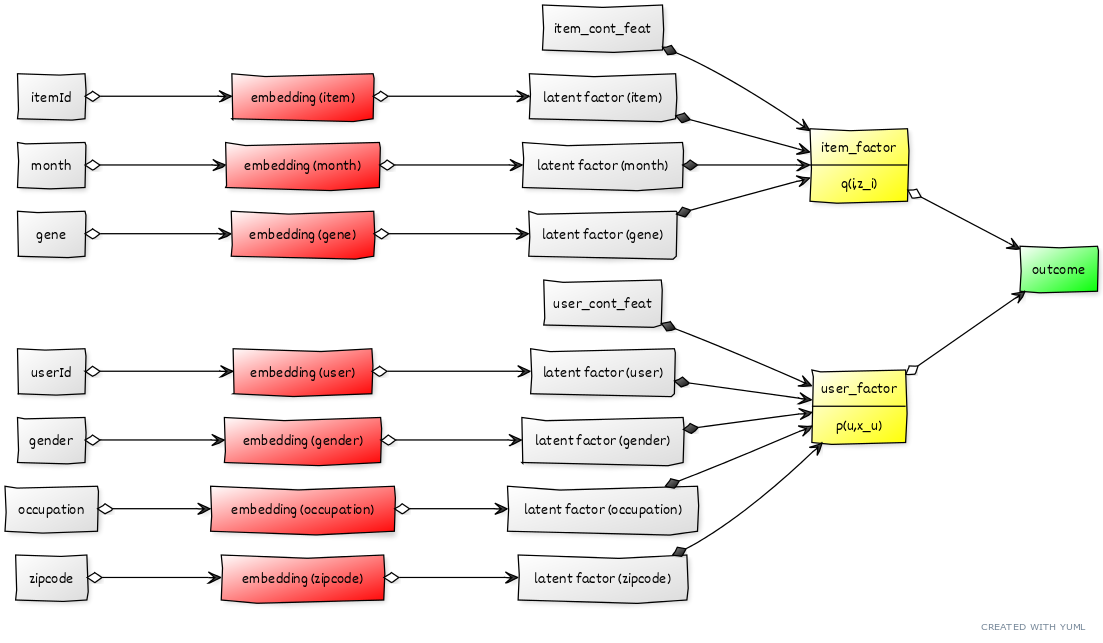

In [ ]:
class LinearRS(keras.Model):
    def __init__(self, num_users, num_movies, num_gender, num_occupation, num_zipcode, num_gene, num_month, embedding_size, **kwargs):
        super(LinearRS, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.num_gender = num_gender
        self.num_occupation = num_occupation
        self.num_zipcode = num_zipcode
        self.embedding_size = embedding_size

        ## Embedding layers
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.gender_embedding = layers.Embedding(
            num_gender,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.occupation_embedding = layers.Embedding(
            num_occupation,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.zipcode_embedding = layers.Embedding(
            num_zipcode,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.gene_embedding = layers.Embedding(
            num_gene,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.month_embedding = layers.Embedding(
            num_month,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        ## Linear Mapping layers
        self.user_dense = layers.Dense(embedding_size, name='user_cont', activation='linear')
        self.item_dense = layers.Dense(embedding_size, name='item_cont', activation='linear')

    def call(self, inputs):
        ## multi source inputs: cate/cont data
        user_cont_feat, item_cont_feat, user_cate_feat, item_cate_feat = inputs[0], inputs[1], inputs[2], inputs[3]

        ## user embedding - user: [user_id, gender, occupation, zipcode]
        user_vec = self.user_embedding(user_cate_feat[:,0])
        gender_vec = self.gender_embedding(user_cate_feat[:,1])
        occupation_vec = self.occupation_embedding(user_cate_feat[:,2])
        zipcode_vec = self.zipcode_embedding(user_cate_feat[:,3])

        ## movie embedding - item: [item_id, gene, month]
        movie_vec = self.movie_embedding(item_cate_feat[:,0])
        gene_vec = self.gene_embedding(item_cate_feat[:,1])
        month_vec = self.month_embedding(item_cate_feat[:,2])

        ## user cont mapping
        user_cont_vec = self.user_dense(user_cont_feat)
        item_cont_vec = self.item_dense(item_cont_feat)

        ## product
        user_factor = user_vec + gender_vec + occupation_vec + zipcode_vec + user_cont_vec
        item_factor = movie_vec + gene_vec + month_vec + item_cont_vec

        return tf.reduce_sum(user_factor * item_factor, axis=1, keepdims=True)


In [ ]:
train.sample(3)

,user_id,item_id,rating,timestamp,gender,occupation,zip code,count,mean,age,gene,month,count_item,mean_item,year
966,392,21,4,887745973,1,18,316,3.240483,-0.621648,-1.277510,0,1,2.536383,1.383807,0.487097
10279,167,120,4,884287731,1,13,312,-0.470698,-0.805188,1.194502,0,6,4.350478,0.298085,0.487097
22331,435,91,3,887770115,0,0,81,0.735436,0.281930,-0.339850,0,0,0.338820,0.646484,0.277063


In [ ]:
## user_cont_feat, item_cont_feat, user_cate_feat, item_cate_feat
# [user_id, gender, occupation, zipcode]
# [item_id, gene, month]

# inputs = [0, 1, 2, 3, 4]
train_input = [train[['count', 'mean', 'age']].values,
               train[['count_item', 'mean_item', 'year']].values,
               train[['user_id', 'gender', 'occupation', 'zip code']].astype(int).values,
               train[['item_id', 'gene', 'month']].astype(int).values
               ]

In [ ]:
train_input

[array([[ 0.51011385,  0.76506504, -0.16936684],
        [-0.7490371 ,  1.64082769, -0.85130101],
        [-0.73578288,  0.69842353, -1.19226809],
        ...,
        [-0.39117314,  1.33478523,  0.93877619],
        [ 5.61298876,  0.53157474,  0.08635848],
        [ 1.51743461, -0.66781924, -0.25460861]]),
 array([[ 1.82844306,  1.03470159, -1.26319138],
        [ 1.90218676,  0.14896477,  0.55710876],
        [-0.50185781, -0.27252468,  0.41708567],
        ...,
        [ 0.01434808,  1.16233864,  0.41708567],
        [ 3.56879434,  1.605497  ,  0.1370395 ],
        [ 0.22083043, -0.4724702 ,  0.41708567]]),
 array([[188,   1,   1, 377],
        [  3,   1,  19, 177],
        [138,   1,  18,  47],
        ...,
        [ 13,   1,  17, 224],
        [449,   0,   3,  64],
        [144,   1,   5, 413]]),
 array([[178,  13,   0],
        [300,   4,   8],
        [459,   7,   0],
        ...,
        [ 18,   7,   0],
        [ 97,   7,   0],
        [553,   0,   0]])]

In [ ]:
valid_input = [valid[['count', 'mean', 'age']].values, valid[['count_item', 'mean_item', 'year']].values, \
              valid[['user_id', 'gender', 'occupation', 'zip code']].astype(int).values,\
              valid[['item_id', 'gene', 'month']].astype(int).values]

test_input = [test[['count', 'mean', 'age']].values, test[['count_item', 'mean_item', 'year']].values, \
              test[['user_id', 'gender', 'occupation', 'zip code']].astype(int).values,\
              test[['item_id', 'gene', 'month']].astype(int).values]

In [ ]:
# num_users, num_movies, num_gender, num_occupation, num_zipcode, num_gene, num_month, embedding_size:

model = LinearRS(num_users=n_user, num_movies=n_item,
                 num_gender=num_cate[0], num_occupation=num_cate[1],
                 num_zipcode=num_cate[2], num_gene=num_cate[3], num_month=num_cate[4],
                 embedding_size=100)

metrics = [
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.RootMeanSquaredError(name='rmse')
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=metrics
)

In [ ]:
## TF debugging
# user_cont_feat, item_cont_feat, user_cate_feat, item_cate_feat = valid_input[0], valid_input[1], valid_input[2], valid_input[3]

# model.month_embedding(item_cate_feat[:,])

<tf.Tensor: shape=(9574,), dtype=float32, numpy=
array([ 0.65974236, -0.00761331, -0.0301231 , ..., -0.9677737 ,
        0.2161798 , -0.46740878], dtype=float32)>

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(
    monitor='val_rmse', min_delta=0, patience=5, verbose=1,
    mode='min', baseline=None, restore_best_weights=True)]

history = model.fit(
    x=train_input,
    y=train['rating'].astype(float).values[:,np.newaxis],
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_data=(valid_input, valid['rating'].astype(float).values[:,np.newaxis])
)

Epoch 1/50
350/350 [==============================] - 3s 9ms/step - loss: 0.9483 - mae: 0.7372 - rmse: 0.9325 - val_loss: 1.0035 - val_mae: 0.7526 - val_rmse: 0.9627
Epoch 2/50
350/350 [==============================] - 3s 7ms/step - loss: 0.9465 - mae: 0.7375 - rmse: 0.9316 - val_loss: 1.0081 - val_mae: 0.7541 - val_rmse: 0.9666
Epoch 3/50
350/350 [==============================] - 4s 10ms/step - loss: 0.9439 - mae: 0.7354 - rmse: 0.9310 - val_loss: 1.0093 - val_mae: 0.7641 - val_rmse: 0.9674
Epoch 4/50
350/350 [==============================] - 2s 7ms/step - loss: 0.9431 - mae: 0.7364 - rmse: 0.9307 - val_loss: 0.9980 - val_mae: 0.7642 - val_rmse: 0.9622
Epoch 5/50
350/350 [==============================] - 3s 8ms/step - loss: 0.9398 - mae: 0.7350 - rmse: 0.9298 - val_loss: 1.0031 - val_mae: 0.7591 - val_rmse: 0.9640
Epoch 6/50
350/350 [==============================] - 2s 7ms/step - loss: 0.9462 - mae: 0.7353 - rmse: 0.9297 - val_loss: 1.0296 - val_mae: 0.7582 - val_rmse: 0.9741
Epo

In [ ]:
model.evaluate(test_input, test['rating'].astype(float).values[:,np.newaxis])

620/620 [==============================] - 4s 6ms/step - loss: 1.0347 - mae: 0.7716 - rmse: 0.9817


[1.0346639156341553, 0.7716012597084045, 0.9816654324531555]

### **TTowerRS**: two-tower models for RS
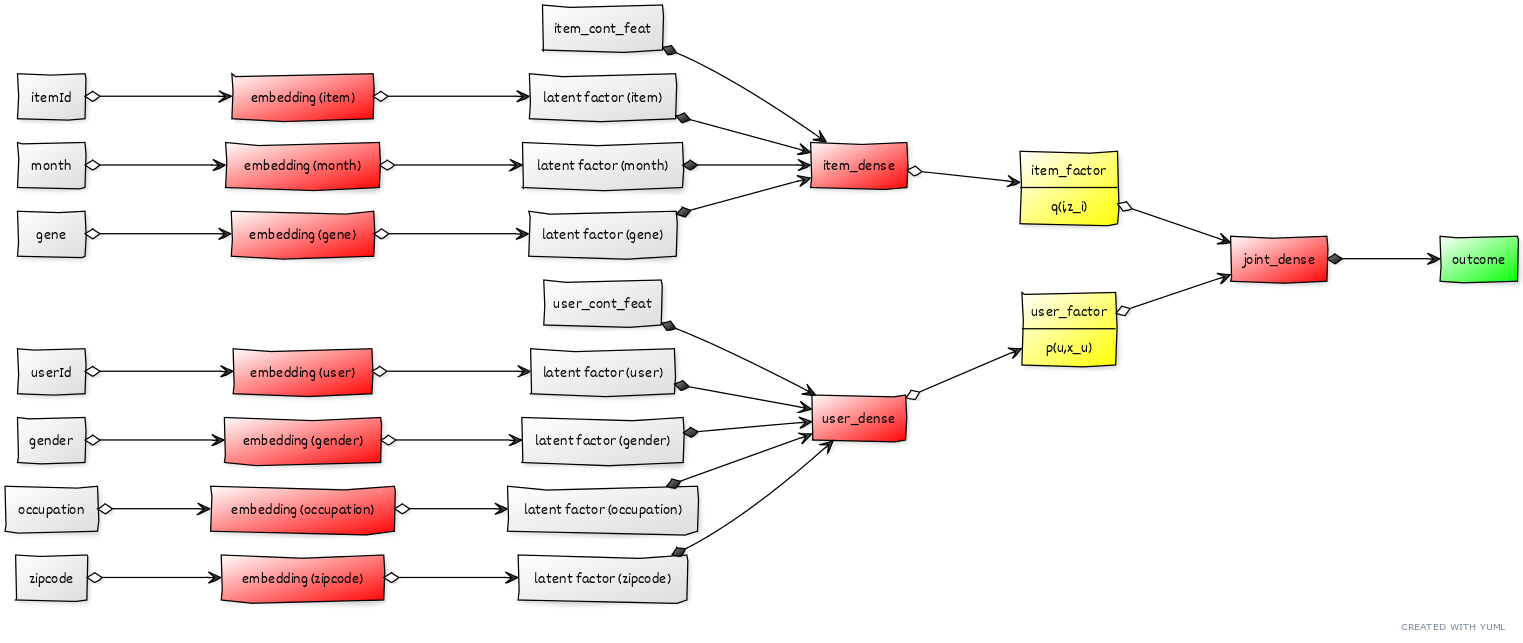

In [ ]:
class TTowerRS(keras.Model):
    def __init__(self, num_users, num_movies, num_gender, num_occupation, num_zipcode, num_gene, num_month, embedding_size, dense_size, **kwargs):
        super(TTowerRS, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.num_gender = num_gender
        self.num_occupation = num_occupation
        self.num_zipcode = num_zipcode
        self.embedding_size = embedding_size
        ## Embedding layers
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-3),
        )
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-3),
        )
        self.gender_embedding = layers.Embedding(
            num_gender,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-3),
        )
        self.occupation_embedding = layers.Embedding(
            num_occupation,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-3),
        )
        self.zipcode_embedding = layers.Embedding(
            num_zipcode,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-3),
        )
        self.gene_embedding = layers.Embedding(
            num_gene,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-3),
        )
        self.month_embedding = layers.Embedding(
            num_month,
            embedding_size,
            embeddings_regularizer=keras.regularizers.l2(1e-3),
        )
        ##  Mapping layers
        self.user_dense = layers.Dense(dense_size, name='user_dense', activation='relu')
        self.item_dense = layers.Dense(dense_size, name='item_dense', activation='relu')
        self.joint_dense = layers.Dense(dense_size, name='joint_dense', activation='relu')
        self.out_dense = layers.Dense(1, name='out_dense', activation='linear')

    def call(self, inputs):
        ## cate/cont data
        user_cont_feat, item_cont_feat, user_cate_feat, item_cate_feat = inputs[0], inputs[1], inputs[2], inputs[3]

        ## user embedding - user: [user_id, gender, occupation, zipcode]
        user_vec = self.user_embedding(user_cate_feat[:, 0])
        gender_vec = self.gender_embedding(user_cate_feat[:, 1])
        occupation_vec = self.occupation_embedding(user_cate_feat[:, 2])
        zipcode_vec = self.zipcode_embedding(user_cate_feat[:, 3])

        ## movie embedding - item: [item_id, gene, month]
        movie_vec = self.movie_embedding(item_cate_feat[:, 0])
        gene_vec = self.gene_embedding(item_cate_feat[:, 1])
        month_vec = self.month_embedding(item_cate_feat[:, 2])

        ## user/item dense mapping
        user_all_vec = layers.Concatenate()([user_cont_feat, user_vec, gender_vec, occupation_vec, zipcode_vec])
        item_all_vec = layers.Concatenate()([item_cont_feat, movie_vec, gene_vec, month_vec])

        user_dense_vec = self.user_dense(user_all_vec)
        item_dense_vec = self.item_dense(item_all_vec)

        ## joint dense
        joint_vec = layers.Concatenate()([user_dense_vec, item_dense_vec])
        joint_vec = self.joint_dense(joint_vec)
        out = self.out_dense(joint_vec)
        return out

In [ ]:
model = TTowerRS(num_users=n_user, num_movies=n_item,
                 num_gender=num_cate[0], num_occupation=num_cate[1],
                 num_zipcode=num_cate[2], num_gene=num_cate[3], num_month=num_cate[4],
                 embedding_size=100, dense_size=100)
metrics = [
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.RootMeanSquaredError(name='rmse')
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=metrics
)

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(
    monitor='val_rmse', min_delta=0, patience=5, verbose=1,
    mode='min', baseline=None, restore_best_weights=True)]

history = model.fit(
    x=train_input,
    y=train['rating'].astype(float).values[:,np.newaxis],
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_data=(valid_input, valid['rating'].astype(float).values[:,np.newaxis])
)

Epoch 1/50
350/350 [==============================] - 5s 11ms/step - loss: 3.9920 - mae: 1.5188 - rmse: 1.9531 - val_loss: 1.1615 - val_mae: 0.8041 - val_rmse: 1.0113
Epoch 2/50
350/350 [==============================] - 5s 14ms/step - loss: 1.0779 - mae: 0.7748 - rmse: 0.9767 - val_loss: 1.0594 - val_mae: 0.7702 - val_rmse: 0.9727
Epoch 3/50
350/350 [==============================] - 4s 11ms/step - loss: 1.0023 - mae: 0.7488 - rmse: 0.9465 - val_loss: 1.0324 - val_mae: 0.7599 - val_rmse: 0.9654
Epoch 4/50
350/350 [==============================] - 4s 11ms/step - loss: 0.9597 - mae: 0.7338 - rmse: 0.9294 - val_loss: 1.0185 - val_mae: 0.7592 - val_rmse: 0.9627
Epoch 5/50
350/350 [==============================] - 4s 10ms/step - loss: 0.9307 - mae: 0.7240 - rmse: 0.9178 - val_loss: 1.0147 - val_mae: 0.7625 - val_rmse: 0.9641
Epoch 6/50
350/350 [==============================] - 4s 11ms/step - loss: 0.9127 - mae: 0.7187 - rmse: 0.9111 - val_loss: 1.0106 - val_mae: 0.7601 - val_rmse: 0.964

In [ ]:
model.evaluate(test_input, test['rating'].astype(float).values[:,np.newaxis])

620/620 [==============================] - 2s 4ms/step - loss: 0.9902 - mae: 0.7605 - rmse: 0.9767


[0.9901753067970276, 0.7605390548706055, 0.9767396450042725]

In [ ]:
model.summary()

Model: "t_tower_rs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     multiple                  94300     
                                                                 
 embedding_8 (Embedding)     multiple                  168200    
                                                                 
 embedding_9 (Embedding)     multiple                  200       
                                                                 
 embedding_10 (Embedding)    multiple                  2100      
                                                                 
 embedding_11 (Embedding)    multiple                  41500     
                                                                 
 embedding_12 (Embedding)    multiple                  1800      
                                                                 
 embedding_13 (Embedding)    multiple                  1

## To-do list

- **STAT**
  - [ ] Math formulation of RS models with side information
  - [ ] Understand the procedure of `embedding` layers

- **Code**
  - [ ] Pre-processing the side information
  - [ ] Implementation of `linearRS` and `TTowerRS` models
  - [ ] Custom model with side information by using different tf.keras layers
